# 0. REPOSITORY INITIALIZATION + INSTALLATIONS

In [1]:
# Clone the repository to the local environment
!git clone https://github.com/Jiang-Muyun/FAST.git

# Move module files (FAST.py, utils.py, etc.) to the root directory for direct import
!cp -r FAST/* .

# Remove the now empty repository folder to maintain a clean workspace
!rm -rf FAST

print("Initialization complete: Model dependencies loaded.")

Cloning into 'FAST'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 57 (delta 29), reused 33 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (57/57), 20.29 KiB | 3.38 MiB/s, done.
Resolving deltas: 100% (29/29), done.
Initialization complete: Model dependencies loaded.


In [2]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 14.8 MB/s eta 0:00:00


# 1. IMPORTS & SETUP

In [1]:
# ==================================================================================
# Source: BCIC2020Track3_train.py (Lines 1-41)
# ==================================================================================

import os
import sys
import random
import time
import numpy as np
import pandas as pd
import scipy.io
import h5py               # For reading the .h5 data files
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# --- PyTorch & Deep Learning Imports ---
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchmetrics       # For calculating Accuracy/F1 (Metric tracking)
import lightning as pl    # PyTorch Lightning framework
import logging
import einops             # For tensor reshaping operations (Critical for FAST)
from sklearn.model_selection import KFold
from transformers import PretrainedConfig
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

# --- Configuration ---
torch.set_num_threads(8) # Optimization: Uses 8 CPU cores for data loading
logging.getLogger('pytorch_lightning').setLevel(logging.WARNING) # Keep output clean

# --- Local Module Imports ---
# These load the custom code from the uploaded files
from FAST import FAST as Tower
from utils import green, yellow
from BCIC2020Track3_preprocess import Electrodes, Zones

# --- Reproducibility Setup ---
def seed_all(seed):
    """
    Fixes random seeds for reproducibility.
    Ensures that results can be replicated exactly.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.set_float32_matmul_precision('medium') # Optimization for newer GPUs

# Initialize the environment
seed_all(42)
print("Environment ready. Random seed set to 42.")

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Environment ready. Random seed set to 42.


# 2. UTILITIES & DATASET WRAPPER


In [2]:
# ==================================================================================
# Source: BCIC2020Track3_train.py (Lines 43-75)
# ==================================================================================

def cosine_scheduler(base_value, final_value, epochs, niter_per_ep, warmup_epochs=0, start_warmup_value=0):
    """
    Calculates learning rate adjustments for each training step.
    
    Logic:
    1. Linear Warmup: Gradually increases LR from 0 to base_value.
    2. Cosine Decay: Smoothly decreases LR from base_value to final_value.
    
    Purpose: Critical for stabilizing Transformer training convergence.
    """
    warmup_schedule = np.array([])
    warmup_iters = warmup_epochs * niter_per_ep
    
    # Phase 1: Linear Warmup (0 -> Base LR)
    if warmup_epochs > 0:
        warmup_schedule = np.linspace(start_warmup_value, base_value, warmup_iters)

    # Phase 2: Cosine Decay (Base LR -> Final LR)
    iters = np.arange(epochs * niter_per_ep - warmup_iters)
    schedule = final_value + 0.5 * (base_value - final_value) * (1 + np.cos(np.pi * iters / len(iters)))
    
    schedule = np.concatenate((warmup_schedule, schedule))
    assert len(schedule) == epochs * niter_per_ep
    return schedule

class Loader(Dataset):
    """
    PyTorch Dataset wrapper for EEG data.
    """
    def __init__(self, data, label):
        self.data = data
        self.label = label
        
    def __getitem__(self, index):
        # Returns a single sample: (EEG_Signal, Class_Label)
        return self.data[index], self.label[index]
        
    def __len__(self):
        # Returns total number of samples
        return len(self.data)

In [5]:
# ==================================================================================
# DIAGNOSTIC: FIND DATA PATHS
# We list the input directory to locate the 'Training set' and 'Validation set'.
# ==================================================================================


print("Scanning Kaggle Input Directory...")
found_training = False

for root, dirs, files in os.walk("/kaggle/input"):
    if "Training set" in dirs:
        print(f"FOUND Training set at: {root}/Training set")
        found_training = True
    if "Validation set" in dirs:
        print(f"FOUND Validation set at: {root}/Validation set")

if not found_training:
    print("\nWARNING: Could not find a folder named 'Training set'.")
    print("Here is the full structure:")
    # Fallback: simple listing if specific folders aren't found
    os.system("ls -R /kaggle/input")

Scanning Kaggle Input Directory...
FOUND Training set at: /kaggle/input/bcic2020track3/Training set
FOUND Validation set at: /kaggle/input/bcic2020track3/Validation set


# 3. DATA ENVIRONMENT SETUP & PREPROCESSING


In [6]:
# ==================================================================================
# Remaps data paths and executes the data ingestion module.
# ==================================================================================

# 1. Reset Workspace
# Clear any previous broken links to ensure a clean slate
if os.path.exists("./BCIC2020Track3"):
    os.system("rm -rf ./BCIC2020Track3")

# 2. Establish Directory Structure
os.makedirs("./BCIC2020Track3")

# 3. Map Data Sources
# Link the uploaded dataset (bcic2020track3) to the expected workspace location
os.system('ln -s "/kaggle/input/bcic2020track3/Training set" "./BCIC2020Track3/Training set"')
os.system('ln -s "/kaggle/input/bcic2020track3/Validation set" "./BCIC2020Track3/Validation set"')

# 4. Execute Preprocessing Module
print("Executing preprocessing script...")
!python BCIC2020Track3_preprocess.py

Executing preprocessing script...
13 (350, 64, 800) (350,)
07 (350, 64, 800) (350,)
08 (350, 64, 800) (350,)
06 (350, 64, 800) (350,)
11 (350, 64, 800) (350,)
03 (350, 64, 800) (350,)
15 (350, 64, 800) (350,)
01 (350, 64, 800) (350,)
05 (350, 64, 800) (350,)
14 (350, 64, 800) (350,)
10 (350, 64, 800) (350,)
04 (350, 64, 800) (350,)
12 (350, 64, 800) (350,)
09 (350, 64, 800) (350,)
02 (350, 64, 800) (350,)
01 (350, 64, 800) (350,) (array([0, 1, 2, 3, 4], dtype=uint8), array([70, 70, 70, 70, 70]))
02 (350, 64, 800) (350,) (array([0, 1, 2, 3, 4], dtype=uint8), array([70, 70, 70, 70, 70]))
03 (350, 64, 800) (350,) (array([0, 1, 2, 3, 4], dtype=uint8), array([70, 70, 70, 70, 70]))
04 (350, 64, 800) (350,) (array([0, 1, 2, 3, 4], dtype=uint8), array([70, 70, 70, 70, 70]))
05 (350, 64, 800) (350,) (array([0, 1, 2, 3, 4], dtype=uint8), array([70, 70, 70, 70, 70]))
06 (350, 64, 800) (350,) (array([0, 1, 2, 3, 4], dtype=uint8), array([70, 70, 70, 70, 70]))
07 (350, 64, 800) (350,) (array([0, 1, 

In [3]:
# ==================================================================================
# 3.1: DATA MATRIX VISUALIZATION 
# Purpose: Display a single trial as a readable 2D Table (Rows & Columns).
# ==================================================================================

# 1. Open the file
with h5py.File('Processed/BCIC2020Track3.h5', 'r') as f:
    # 2. Extract Data for Subject 01
    X = f['01']['X'][()]  # Shape: (350, 64, 800)

# 3. Select ONE Trial (The first one) to visualize
# Shape becomes (64, 800) -> 64 Electrodes, 800 Timepoints
one_trial_matrix = X[0] 

# 4. Convert to Pandas DataFrame for a pretty table view
# We will show just the first 10 timepoints to keep it readable
df = pd.DataFrame(one_trial_matrix)
df.index.name = "Electrodes (Rows)"
df.columns.name = "Timepoints (Cols)"

# Display the first 10 columns (Time 0 to 10)
print(f"Showing Data for Subject 01, Trial 0 (Values in microvolts):")
display(df.iloc[:, :10]) # Use 'display()' for nice formatting in Jupyter, or print()

Showing Data for Subject 01, Trial 0 (Values in microvolts):


Timepoints (Cols),0,1,2,3,4,5,6,7,8,9
Electrodes (Rows),,,,,,,,,,
0,-32.316410,-20.137415,-25.662806,-15.526828,-14.574009,-14.773732,-14.353067,-15.919027,-10.525989,-15.739365
1,-12.672948,-4.891340,-32.791264,-23.876413,-20.884031,-22.804869,-31.195715,-39.169983,-31.959141,-29.429192
2,14.669548,26.554760,29.753229,47.470036,52.810455,47.445900,55.372330,41.580853,53.161629,43.530895
3,22.764944,26.189428,25.061802,30.676361,33.130932,32.013042,33.888294,32.501396,38.982025,39.306011
4,28.273333,27.386555,20.437632,23.944395,30.304382,29.415707,23.206415,21.387560,25.805708,27.813725
...,...,...,...,...,...,...,...,...,...,...
59,94.100952,96.764198,93.108749,92.761353,94.995255,96.080299,90.620651,84.403450,86.992691,93.245956
60,44.732597,47.678345,42.154648,42.221409,44.623650,45.807655,42.533306,34.587925,39.964489,46.211285
61,90.967537,91.437592,85.054008,86.136528,87.777733,88.497162,81.102745,74.839638,81.184631,89.105957


In [4]:
# ==================================================================================
# 3.2: DATA EXPORT
# Purpose: Export a single trial to CSV for external inspection.
# ==================================================================================

# 1. Extract Data
with h5py.File('Processed/BCIC2020Track3.h5', 'r') as f:
    # Subject 01, Data Matrix X, First Trial [0]
    # Dimensions: (64 Electrodes, 800 Timepoints)
    data_matrix = f['01']['X'][()][0]

# 2. Convert to DataFrame
df = pd.DataFrame(data_matrix)
df.index.name = "Electrodes"
df.columns.name = "Timepoints"

# 3. Save
filename = "Subject01_Trial0.csv"
df.to_csv(filename)

print(f"Saved: {filename}")

Saved: Subject01_Trial0.csv


In [9]:
# ==================================================================================
# 3.3 INSPECT LABELS (Y)
# Purpose: View the "Answer Key" for the first few trials.
# ==================================================================================
import h5py
import numpy as np

# 1. Load Data
with h5py.File('Processed/BCIC2020Track3.h5', 'r') as f:
    # Get the Answer Key (Y) for Subject 01
    Y_inspect = f['01']['Y'][()] # <-- SAFE VARIABLE NAME

# 2. Print Stats
print(f"Y Shape: {Y_inspect.shape} ...")
print(f"Unique Labels Found: {np.unique(Y_inspect)}")

# 3. Show the first 10 Labels
print("\n--- First 10 Labels (Answer Key) ---")
print(Y_inspect[:10])

# 4. Decode what they mean (Based on dataset documentation)
label_map = {0: 'Hello', 1: 'Help Me', 2: 'Stop', 3: 'Thank You', 4: 'Yes'}
print("\n--- Translation ---")
print(f"Trial 0 Label: {Y_inspect[0]} -> {label_map[Y_inspect[0]]}")

Y Shape: (350,) ...
Unique Labels Found: [0 1 2 3 4]

--- First 10 Labels (Answer Key) ---
[1 1 0 1 3 1 3 4 2 0]

--- Translation ---
Trial 0 Label: 1 -> Help Me


# 4. TRAINING ENGINE & MODEL DEFINITION


In [19]:
# ==================================================================================
# Source: BCIC2020Track3_train.py (Lines 55-110)
# ==================================================================================

def load_standardized_h5(cache_fn):
    X, Y = [], []
    with h5py.File(cache_fn, 'r') as f:
        subjects = list(f.keys())
        for subject in subjects:
            X.append(f[subject]['X'][()])
            Y.append(f[subject]['Y'][()])
    X, Y = np.array(X), np.array(Y)
    print('Loaded from', cache_fn, X.shape, Y.shape)
    return X, Y

def inference_on_loader(model, loader):
    model.eval()
    model.cuda()
    with torch.no_grad():
        Pred, Real = [], []
        for x, y in loader:
            preds = torch.argmax(model(x.cuda()), dim=1).cpu()
            Pred.append(preds)
            Real.append(y)
        Pred, Real = torch.cat(Pred), torch.cat(Real)
    return Pred.numpy(), Real.numpy()

class BasicDataset(Dataset):
    def __init__(self, data, label):
        # Handle 4D input (Multiple Subjects) by flattening into 3D
        if len(data.shape) == 4:
            data = np.concatenate(data, axis=0)
            label = np.concatenate(label, axis=0)
        
        # Convert to Tensors (Works for both 3D and flattened 4D)
        self.data = torch.from_numpy(data).float()
        self.labels = torch.from_numpy(label).long()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

class EEG_Encoder_Module(pl.LightningModule):
    def __init__(self, config, max_epochs, niter_per_ep):
        super().__init__()
        self.config = config
        self.model = Tower(config)
        self.loss = nn.CrossEntropyLoss()
        self.cosine_lr_list = cosine_scheduler(1, 0.1, max_epochs, niter_per_ep, warmup_epochs=10)
        
        # Metrics: Accuracy (Original) + F1 Score (Added)
        self.accuracy = torchmetrics.Accuracy('multiclass', num_classes = config.n_classes)
        self.f1 = torchmetrics.F1Score(task='multiclass', num_classes=config.n_classes, average='macro')

    def configure_optimizers(self):
        self.optimizer = optim.AdamW(self.parameters(), lr=0.0005)
        self.scheduler = optim.lr_scheduler.LambdaLR(self.optimizer, lambda epoch: self.cosine_lr_list[self.global_step-1])
        return [self.optimizer], [{'scheduler': self.scheduler, 'interval': 'step'}]

    def training_step(self, batch, batch_idx):
        x, y = batch
        pred = self.model(x)
        # 1. Calculate Loss
        loss = self.loss(pred, y)
        # 2. Log it
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    def validation_step(self, batch, batch_idx):
        x, y = batch
        pred = self.model(x)
        loss = self.loss(pred, y)
        acc = (torch.argmax(pred, dim=1) == y).float().mean()
        # Use 'val_loss' to match the callbacks in Block 6
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

# 5. INITIAL TRAINING CHECKUP (PIPELINE VERIFICATION)

CHANGE BACK TO CODE CELL-TYPE AND DELETE THIS LINE TO RUN THIS BLOCK
# ==================================================================================
# Source Logic: BCIC2020Track3_train.py (Lines 112-160)
# ==================================================================================

"""
BLOCK 5: INITIAL TRAINING CHECKUP

Purpose: 
Executes a minimal "Smoke Test" (5-Fold CV on Subject 1) to validate the full training 
pipeline, including parallel data loading and file persistence, before running the 
full-scale experiment.

Modifications for Validation:
1. num_workers=2: Enables parallel subprocesses for data loading (optimization).
2. FOLDS=[0]: Limits execution to Subject 01 only.
3. MAX_EPOCHS=10: Reduced from 200 to verify pipeline completion speed.
"""

from sklearn.metrics import f1_score 

# --- 1. Global Configuration ---

GPU_ID = 0
FOLDS = [0]          # Scope: Only Subject 01 (Index 0)
MAX_EPOCHS = 10       # Scope: 10 Epochs for rapid pipeline verification
RESULTS_DIR = "Results/FAST/"

os.makedirs(RESULTS_DIR, exist_ok=True)

def Finetune(config, Data_X, Data_Y, logf, max_epochs=200, ckpt_pretrain=None):
    """
    Executes 5-Fold Cross-Validation for a single subject.
    """
    seed_all(42) # Ensure reproducibility across runs
    
    Pred, Real = [], []
    kf = KFold(n_splits=5, shuffle=False) # Standard 5-fold split
    
    for _train_idx, _test_idx in kf.split(Data_X):
        # Data Slicing
        x_train, y_train = Data_X[_train_idx], Data_Y[_train_idx]
        x_val, y_val = Data_X[_test_idx], Data_Y[_test_idx]

        train_data = BasicDataset(x_train, y_train)
        val_data = BasicDataset(x_val, y_val)
        
        # DataLoader Configuration
        # MODIFICATION: num_workers=2 (prevents CPU bottleneck during GPU training)
        train_loader = DataLoader(train_data, batch_size=len(x_train), shuffle=True, num_workers=2, pin_memory=True)
        val_loader = DataLoader(val_data, batch_size=len(x_val), shuffle=False, num_workers=2, pin_memory=True)

        # Model Initialization (Fresh instance per fold)
        model = EEG_Encoder_Module(config, max_epochs, len(train_loader))
        if ckpt_pretrain is not None:
            model.model.load_state_dict(torch.load(ckpt_pretrain, weights_only=True))

        # Trainer Configuration
        # MODIFICATION: enable_progress_bar=True (for visual monitoring)
        trainer = pl.Trainer(
            strategy='auto', 
            accelerator='gpu', 
            devices=[GPU_ID], 
            max_epochs=max_epochs, 
            callbacks=[], 
            enable_progress_bar=True, 
            enable_checkpointing=False, 
            precision='bf16-mixed', # bf16 reduces VRAM usage while maintaining stability
            logger=False
        )
        
        # Execute Training & Inference
        trainer.fit(model, train_dataloaders=train_loader)
        pred, real = inference_on_loader(model.model, val_loader)
        
        Pred.append(pred)
        Real.append(real)
    
    # Persistence: Aggregate folds and save to disk
    Pred, Real = np.concatenate(Pred), np.concatenate(Real)
    np.savetxt(logf, np.array([Pred, Real]).T, delimiter=',', fmt='%d')
    print(f"Pipeline Success: Results saved to {logf}")

# --- 2. Main Execution Loop ---

sfreq = 250
config = PretrainedConfig(
    # Spatial / Input Parameters
    electrodes=Electrodes, # 64-channel map
    zone_dict=Zones,       # Functional area grouping
    dim_cnn=32,            # Spatial feature dimension per area
    
    # Temporal / Transformer Parameters
    dim_token=32,          # Transformer embedding dimension
    seq_len=800,           # Input duration (800 pts / 250Hz = 3.2s)
    window_len=sfreq,      # Attention window (1s)
    slide_step=sfreq//2,   # Window overlap (0.5s)
    
    # Architecture Depth
    head='Conv4Layers',    # Classifier head type
    n_classes=5,           # Output classes
    num_layers=4,          # Transformer depth
    num_heads=8,           # Attention heads
    dropout=0.1,           # Regularization
)

# Load Data (Raw values, shape: Subjects x Trials x Channels x Time)
X, Y = load_standardized_h5('Processed/BCIC2020Track3.h5')

for fold in range(15):
    # Filter for selected subjects
    if fold not in FOLDS:
        continue
    
    flog = f"{RESULTS_DIR}/{fold}-Tune.csv"
    
    # Cleanup: Remove partial files from any previous interrupted runs
    if os.path.exists(flog):
        os.remove(flog)
        
    print(f"Initiating Training Checkup: Subject {fold} | Epochs: {MAX_EPOCHS} | Workers: 2")
    Finetune(config, X[fold], Y[fold], flog, max_epochs=MAX_EPOCHS)

print("\n--- Checkup Complete ---")

CHANGE BACK TO CODE CELL-TYPE AND DELETE THIS LINE TO RUN THIS BLOCK
# ==================================================================================
# [Analysis of Training Results]
# ==================================================================================

# --- New Imports (Visualization & Metrics) ---
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Load the Results
# Structure: Column 0 = Predictions, Column 1 = Real Labels
results_file = "Results/FAST/0-Tune.csv"

try:
    # Uses 'np' from Cell 17
    data = np.loadtxt(results_file, delimiter=',') 
    preds = data[:, 0]
    real = data[:, 1]
    
    print(f"Successfully loaded {len(preds)} predictions from {results_file}")

    # 2. Calculate Core Metrics
    acc = accuracy_score(real, preds)
    print(f"\n>>> Checkup Accuracy: {acc*100:.2f}% (Chance Level: 20.00%)")

    # 3. Detailed Report
    # Checks for class collapse (e.g., model predicting 'Hello' for everything)
    target_names = ['Hello', 'Help Me', 'Stop', 'Thank You', 'Yes']
    print("\n--- Classification Report ---")
    print(classification_report(real, preds, target_names=target_names, zero_division=0))

    # 4. Visualization (Confusion Matrix)
    # Identifies specific confusion patterns between classes
    cm = confusion_matrix(real, preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Checkup Run Confusion Matrix (10 Epochs)')
    plt.show()

except FileNotFoundError:
    print(f"Error: Could not find {results_file}. Ensure the Training Checkup (Step 5) finished successfully.")

# 6. TRAINING SCALE-UP (Subject 01 | 200 Epochs)


CHANGE BACK TO CODE CELL-TYPE AND DELETE THIS LINE TO RUN THIS BLOCK
# ==================================================================================
# Source: BCIC2020Track3_train.py (Lines 112-160)
# Modifications: 
#   1. Added EarlyStopping and ModelCheckpoint callbacks.
#   2. Restricted execution to Subject 01, Fold 0 only (Validation efficiency).
#   3. Enabled checkpointing in Trainer.
# ==================================================================================
# ==============================================================================
# BLOCK 6: VALIDATED TRAINING & BEST MODEL SELECTION
# ==============================================================================
# This block executes a single-fold training process for Subject 01. 
# It utilizes a validation split to monitor generalization and saves the 
# optimal weights based on validation loss performance.
# ==============================================================================

from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

# --- Global Training Configuration ---
GPU_ID = 0
FOLDS = [0]
MAX_EPOCHS = 200

def Finetune(config, Data_X, Data_Y, logf, max_epochs=200, ckpt_pretrain=None):
    seed_all(42) 
    
    Pred, Real = [], []
    kf = KFold(n_splits=5, shuffle=False)
    
    # Execute only the first fold for Subject 01
    for fold_idx, (_train_idx, _val_idx) in enumerate(kf.split(Data_X)):
        if fold_idx > 0: 
            break 
        
        print(f"Starting Fold {fold_idx+1}/5...")
        
        # Partition data into Training and Validation sets
        x_train, y_train = Data_X[_train_idx], Data_Y[_train_idx]
        x_val, y_val = Data_X[_val_idx], Data_Y[_val_idx]

        train_data = BasicDataset(x_train, y_train)
        val_data = BasicDataset(x_val, y_val)
        
        # Initialize DataLoaders
        train_loader = DataLoader(train_data, batch_size=len(x_train), shuffle=True, num_workers=2, pin_memory=True)
        val_loader = DataLoader(val_data, batch_size=len(x_val), shuffle=False, num_workers=2, pin_memory=True)

        # Initialize Lightning Module with learning rate scheduler configuration
        model = EEG_Encoder_Module(config, max_epochs, len(train_loader))
        if ckpt_pretrain is not None:
            model.model.load_state_dict(torch.load(ckpt_pretrain, weights_only=True))

        # Define Early Stopping to prevent overfitting based on validation loss
        early_stop = EarlyStopping(
            monitor="val_loss",
            patience=20,          
            mode="min",
            verbose=True
        )

        # Define Checkpoint callback to persist the best performing model weights
        checkpoint_callback = ModelCheckpoint(
            dirpath="SavedModels/",
            filename="Subject01_Best",
            monitor="val_loss",
            mode="min",
            save_top_k=1,
            enable_version_counter=False
        )

        # Configure PyTorch Lightning Trainer
        trainer = pl.Trainer(
            strategy='auto', 
            accelerator='gpu', 
            devices=[GPU_ID], 
            max_epochs=max_epochs, 
            callbacks=[early_stop, checkpoint_callback],
            enable_progress_bar=True, 
            enable_checkpointing=True,
            precision='bf16-mixed',
            logger=True # Enables logging for metrics extraction
        )
        
        # Execute training with simultaneous validation monitoring
        trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
        
        # Post-training inference on validation set
        pred, real = inference_on_loader(model.model, val_loader)
        Pred.append(pred)
        Real.append(real)
    
    # Metrics aggregation and persistence
    Pred, Real = np.concatenate(Pred), np.concatenate(Real)
    val_acc = (Pred == Real).mean()
    np.savetxt(logf, np.array([Pred, Real]).T, delimiter=',', fmt='%d')
    
    print(f"Subject 01 Internal Validation Accuracy: {val_acc*100:.2f}%")

# Ensure dataset is loaded in memory
if 'X' not in locals() or 'Y' not in locals():
    X, Y = load_standardized_h5('Processed/BCIC2020Track3.h5')

# Ensure directory structure for results exists
if not os.path.exists("Results/FAST"):
    os.makedirs("Results/FAST")

flog = f"Results/FAST/0-Tune.csv"
if os.path.exists(flog): 
    os.remove(flog)

# Execute the Finetune process
Finetune(config, X[0], Y[0], flog, max_epochs=MAX_EPOCHS)

CHANGE BACK TO CODE CELL-TYPE AND DELETE THIS LINE TO RUN THIS BLOCK
# ==================================================================================
# SCALED-UP TRAINING ANALYSIS (Subject 01)
# Source: Custom Analysis Module
# Purpose: Evaluate performance against the paper benchmark (Table 7).
# ==================================================================================

# 1. Load the Results
results_file = "Results/FAST/0-Tune.csv"

try:
    data = np.loadtxt(results_file, delimiter=',')
    preds = data[:, 0]
    real = data[:, 1]
    
    print(f"Successfully loaded {len(preds)} predictions from {results_file}")

    # 2. Calculate Core Metrics
    acc = accuracy_score(real, preds)
    
    # [Correction] Target updated to match Jiang et al. (2025) Table VII
    print(f"\n>>> Scale-Up Accuracy: {acc*100:.2f}% (Paper Benchmark: 54.8 ± 9.1%)")

    # 3. Detailed Report
    target_names = ['Hello', 'Help Me', 'Stop', 'Thank You', 'Yes']
    print("\n--- Classification Report ---")
    print(classification_report(real, preds, target_names=target_names, zero_division=0))

    # 4. Visualization (Confusion Matrix)
    cm = confusion_matrix(real, preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Subject 01 Scale-Up (200 Epochs)\nAccuracy: {acc*100:.1f}%')
    plt.show()

except FileNotFoundError:
    print(f"Error: Could not find {results_file}. Ensure Block 6 finished successfully.")

# 7. TEST DATA INGESTION



In [12]:
# ==============================================================================
# CONFIGURATION
# ==============================================================================
RAW_TEST_DIR = '/home/kay/FAST/FAST/BCIC2020Track3/Test set'
PROCESSED_PATH = 'Processed/BCIC2020Track3_Test.h5'
TARGET_TIMEPOINTS = 800  # Target length for temporal alignment

# ==============================================================================
# TEST DATA PREPROCESSING PIPELINE
# ==============================================================================
# 1. Ingestion: Reads raw MATLAB v7.3 files via HDF5.
# 2. Alignment: Applies edge padding to match training input shape (795 -> 800).
# 3. Label Formatting: Standardizes class labels; handles variable dimensions.
# 4. Archival: Saves processed dataset to HDF5.

print(f"--- Initiating Test Data Pipeline ---")
print(f"Source: {RAW_TEST_DIR}")
print(f"Target: {PROCESSED_PATH}")

os.makedirs(os.path.dirname(PROCESSED_PATH), exist_ok=True)

test_library = {}

with h5py.File(PROCESSED_PATH, 'w') as h5_out:
    count_processed = 0
    
    # Iterate through standard subject identifiers (S01 - S15)
    for i in range(1, 16):
        sub_id = f"{i:02d}"
        filename = f"Data_Sample{sub_id}.mat"
        file_path = os.path.join(RAW_TEST_DIR, filename)
        
        if os.path.exists(file_path):
            try:
                # Open File: MATLAB v7.3 format requires HDF5 reader
                with h5py.File(file_path, 'r') as f_in:
                    if 'epo_test' in f_in:
                        epo_struct = f_in['epo_test']
                        keys = list(epo_struct.keys())
                        
                        # Dynamic Key Discovery: Locate data ('x') and label ('y') fields
                        x_key = next((k for k in keys if 'x' in k.lower() or 'data' in k.lower()), None)
                        y_key = next((k for k in keys if 'y' in k.lower() or 'label' in k.lower()), None)

                        if x_key:
                            # 1. Feature Extraction
                            # HDF5 import shape: (Trials, Channels, Time)
                            x = np.array(epo_struct[x_key])
                            
                            # 2. Temporal Standardization (Edge Padding)
                            # Pad final 5 points to match model input (800) without zero-value artifacts.
                            if x.ndim == 3 and x.shape[2] < TARGET_TIMEPOINTS:
                                pad_width = TARGET_TIMEPOINTS - x.shape[2]
                                x = np.pad(x, ((0, 0), (0, 0), (0, pad_width)), 'edge')
                            
                            x = x.astype(np.float32)

                            # 3. Label Processing
                            # Convert One-Hot or raw formats to standard class indices (0-N).
                            if y_key:
                                y_raw = np.array(epo_struct[y_key])
                                
                                # Handle variable label dimensions
                                if y_raw.ndim == 1:
                                    y = y_raw
                                elif y_raw.ndim >= 2:
                                    # Detect encoding axis (Trials vs Classes)
                                    if y_raw.shape[0] == x.shape[0]:
                                        y = y_raw.argmax(axis=1) # (Trials, Classes)
                                    elif y_raw.shape[1] == x.shape[0]:
                                        y = y_raw.argmax(axis=0) # (Classes, Trials)
                                    else:
                                        y = y_raw.flatten()
                                else:
                                    y = np.zeros(x.shape[0])
                            else:
                                y = np.zeros(x.shape[0])
                            
                            y = y.astype(np.uint8)

                            # 4. Storage & Loading
                            # Save to persistent storage
                            sub_grp = h5_out.create_group(sub_id)
                            sub_grp.create_dataset('X', data=x)
                            sub_grp.create_dataset('Y', data=y)
                            
                            # Load into memory (Shuffle=False for reproducible testing)
                            ds = BasicDataset(x, y)
                            loader = DataLoader(ds, batch_size=len(x), shuffle=False, num_workers=0)
                            test_library[sub_id] = loader
                            
                            print(f"Subject {sub_id}: Processed successfully. Output Shape: {x.shape}")
                            count_processed += 1
                        else:
                            print(f"Subject {sub_id}: WARNING - Data key not found.")
            except Exception as e:
                print(f"Subject {sub_id}: CRITICAL ERROR - {str(e)}")
        else:
            print(f"Subject {sub_id}: File not found at {file_path}")

print(f"\nPipeline Complete. {count_processed} subjects loaded into memory.")

--- Initiating Test Data Pipeline ---
Source: /home/kay/FAST/FAST/BCIC2020Track3/Test set
Target: Processed/BCIC2020Track3_Test.h5
Subject 01: Processed successfully. Output Shape: (50, 64, 800)
Subject 02: Processed successfully. Output Shape: (50, 64, 800)
Subject 03: Processed successfully. Output Shape: (50, 64, 800)
Subject 04: Processed successfully. Output Shape: (50, 64, 800)
Subject 05: Processed successfully. Output Shape: (50, 64, 800)
Subject 06: Processed successfully. Output Shape: (50, 64, 800)
Subject 07: Processed successfully. Output Shape: (50, 64, 800)
Subject 08: Processed successfully. Output Shape: (50, 64, 800)
Subject 09: Processed successfully. Output Shape: (50, 64, 800)
Subject 10: Processed successfully. Output Shape: (50, 64, 800)
Subject 11: Processed successfully. Output Shape: (50, 64, 800)
Subject 12: Processed successfully. Output Shape: (50, 64, 800)
Subject 13: Processed successfully. Output Shape: (50, 64, 800)
Subject 14: Processed successfully. O

In [21]:
# ==============================================================================
# BLOCK 7.2: GROUND TRUTH LABEL INJECTION
# ==============================================================================
# Parses the external Excel answer sheet to inject valid ground truth labels 
# into the HDF5 archive, replacing the placeholder data.

# CONFIGURATION
# ------------------------------------------------------------------------------
H5_PATH = 'Processed/BCIC2020Track3_Test.h5'
EXCEL_PATH = '/home/kay/FAST/FAST/Track3_Answer Sheet_Test.xlsx'

print(f"--- Injecting Ground Truth Labels ---")
print(f"Source: {EXCEL_PATH}")

if os.path.exists(H5_PATH) and os.path.exists(EXCEL_PATH):
    # 1. Load Answer Sheet
    df_labels = pd.read_excel(EXCEL_PATH, header=None)
    
    with h5py.File(H5_PATH, 'r+') as f:
        count_updated = 0
        
        for i in range(1, 16):
            sub_id = f"{i:02d}"
            col_idx = 2 * i # Data located in columns 2, 4, 6...
            
            try:
                # 2. Extract and Validate Labels
                raw_labels = pd.to_numeric(df_labels.iloc[3:53, col_idx], errors='coerce').values
                
                if len(raw_labels) == 50 and not np.isnan(raw_labels).any():
                    # 3. Standardize Labels (1-5 -> 0-4)
                    final_labels = (raw_labels - 1).astype(np.uint8)
                    
                    if sub_id in f:
                        # 4. Replace Dataset
                        # Delete existing placeholder dataset to allow shape change
                        if 'Y' in f[sub_id]:
                            del f[sub_id]['Y']
                        
                        f[sub_id].create_dataset('Y', data=final_labels)
                        print(f"Subject {sub_id}: Labels updated. Shape {final_labels.shape}")
                        count_updated += 1
                    else:
                        print(f"Subject {sub_id}: Skipped (ID not found in H5).")
                else:
                    print(f"Subject {sub_id}: Validation Failed (Invalid shape or NaNs).")
                    
            except Exception as e:
                print(f"Subject {sub_id}: Error - {str(e)}")

    print(f"\nOperation Complete. Updated {count_updated} subjects.")
    
    # VERIFICATION
    # --------------------------------------------------------------------------
    with h5py.File(H5_PATH, 'r') as f:
        y_sample = f['01']['Y'][:]
        print(f"\n[Verification] Subject 01 Labels (First 5): {y_sample[:5]}")
        print(f"Unique Classes: {np.unique(y_sample)}")
        print(f"Shape: {y_sample.shape}")

    # REFRESH IN-MEMORY LIBRARY
    # --------------------------------------------------------------------------
    # Updates the global test_library variable with the corrected labels
    # ensuring Block 8 uses the valid data.
    test_library = {}
    
    with h5py.File(H5_PATH, 'r') as f:
        for sub_id in sorted(f.keys()):
            X_load = f[sub_id]['X'][:]
            Y_load = f[sub_id]['Y'][:]
            
            ds = BasicDataset(X_load, Y_load)
            loader = DataLoader(ds, batch_size=len(X_load), shuffle=False, num_workers=0)
            test_library[sub_id] = loader
            
    print(f"Library refreshed successfully. Ready for Block 8.")

else:
    print("CRITICAL: Input files not found.")

--- Injecting Ground Truth Labels ---
Source: /home/kay/FAST/FAST/Track3_Answer Sheet_Test.xlsx
Subject 01: Labels updated. Shape (50,)
Subject 02: Labels updated. Shape (50,)
Subject 03: Labels updated. Shape (50,)
Subject 04: Labels updated. Shape (50,)
Subject 05: Labels updated. Shape (50,)
Subject 06: Labels updated. Shape (50,)
Subject 07: Labels updated. Shape (50,)
Subject 08: Labels updated. Shape (50,)
Subject 09: Labels updated. Shape (50,)
Subject 10: Labels updated. Shape (50,)
Subject 11: Labels updated. Shape (50,)
Subject 12: Labels updated. Shape (50,)
Subject 13: Labels updated. Shape (50,)
Subject 14: Labels updated. Shape (50,)
Subject 15: Labels updated. Shape (50,)

Operation Complete. Updated 15 subjects.

[Verification] Subject 01 Labels (First 5): [3 0 4 2 1]
Unique Classes: [0 1 2 3 4]
Shape: (50,)
Library refreshed successfully. Ready for Block 8.


In [22]:
# ==============================================================================
# 7.3 INTEGRITY CHECK: TRAINING vs. TEST
# ==============================================================================
TRAIN_H5 = 'Processed/BCIC2020Track3.h5'       # Your existing training file
TEST_H5  = 'Processed/BCIC2020Track3_Test.h5'  # The file we just built

print("--- Validation: Leakage & Integrity Check ---")

if os.path.exists(TRAIN_H5) and os.path.exists(TEST_H5):
    with h5py.File(TRAIN_H5, 'r') as ft, h5py.File(TEST_H5, 'r') as fte:
        # Compare Subject 01
        sid = '01'
        
        if sid in ft and sid in fte:
            # Load Data
            Xt_train = ft[sid]['X'][:]
            Xt_test  = fte[sid]['X'][:]
            
            # 1. Dimension Check
            print(f"Subject {sid} Dimensions:")
            print(f"  Train: {Xt_train.shape}")
            print(f"  Test:  {Xt_test.shape}")
            
            if Xt_train.shape == Xt_test.shape:
                print("  [PASS] Dimensions match exactly.")
            else:
                print(f"  [NOTE] Dimensions differ (likely sample count): OK.")

            # 2. Critical Leakage Check (Bit-for-Bit Equality)
            # We compare the first N samples if sizes differ, or whole array if same.
            min_len = min(len(Xt_train), len(Xt_test))
            is_identical = np.array_equal(Xt_train[:min_len], Xt_test[:min_len])
            
            if is_identical:
                print("\n  [CRITICAL FAIL] X_test is IDENTICAL to X_train. Leakage detected.")
            else:
                print("\n  [PASS] Integrity Verified: X_test contains different data than X_train.")
                
            # 3. Label Check
            Y_train = ft[sid]['Y'][:]
            Y_test  = fte[sid]['Y'][:]
            print(f"\nLabel Check (First 5):")
            print(f"  Train: {Y_train[:5].flatten()}")
            print(f"  Test:  {Y_test[:5].flatten()}")
            
        else:
            print(f"Subject {sid} not found in one of the files.")
else:
    print("Could not find both .h5 files to perform comparison.")

--- Validation: Leakage & Integrity Check ---
Subject 01 Dimensions:
  Train: (350, 64, 800)
  Test:  (50, 64, 800)
  [NOTE] Dimensions differ (likely sample count): OK.

  [PASS] Integrity Verified: X_test contains different data than X_train.

Label Check (First 5):
  Train: [1 1 0 1 3]
  Test:  [3 0 4 2 1]


# 8: TRAINING ON COMPLETE DATA (OF SUBJECT 1) + TESTING

In [14]:
# ==============================================================================
# Purpose: Executes training on 100% of the selected training data.
# - Default: Train on Subject 01 (Index 0), Monitor Subject 01 (Test Set).
# - Flexible: Can be configured to train on multiple subjects.
# - Efficiency: Stops automatically if 100% accuracy is reached.
# ==============================================================================

pl.seed_everything(42)  # Ensures reproducibility across runs

# 1. Configuration & Persistence Setup
MAX_EPOCHS = 200
GPU_ID = 0

# [CONFIGURATION] Select which subjects to train on and which to monitor.
TRAIN_SUBJECT_INDICES = [0]   # List of indices: [0]=S01, [1]=S02, etc.
TEST_SUBJECT_ID = '01'        # ID string from Block 7 library: '01', '02'...

# Logs are stored in a structured directory for extraction in Block 9.
run_name = f"train_{'-'.join(map(str, TRAIN_SUBJECT_INDICES))}_test_{TEST_SUBJECT_ID}"
logger = CSVLogger(save_dir="logs/", name="final_experiment", version=run_name)

# 2. Data Loader Initialization (100% Training Data)

X, Y = load_standardized_h5('Processed/BCIC2020Track3.h5')

# Aggregate the full training data for all selected subjects.
X_train_list = [X[i] for i in TRAIN_SUBJECT_INDICES]
Y_train_list = [Y[i] for i in TRAIN_SUBJECT_INDICES]

X_train_combined = np.concatenate(X_train_list, axis=0)
Y_train_combined = np.concatenate(Y_train_list, axis=0)

full_train_loader = DataLoader(
    BasicDataset(X_train_combined, Y_train_combined),
    batch_size=len(X_train_combined), # Full Batch
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

# 3. Model & Trainer Execution
model = EEG_Encoder_Module(config, MAX_EPOCHS, len(full_train_loader))

# Callback: Stop immediately when Test Accuracy hits 100% (1.0)
early_stop_callback = EarlyStopping(
    monitor="val_acc",          # Watch the Test Accuracy
    stopping_threshold=1.0,     # STOP trigger: 100% Accuracy
    mode="max",                 # We want to maximize accuracy
    patience=20,                # Also stop if it stalls for 20 epochs below 100%
    verbose=True
)

# Callback: Auto-save the model with the highest validation accuracy
checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",
    mode="max",
    save_top_k=1,
    filename="best-checkpoint",
    verbose=True
)

trainer = pl.Trainer(
    strategy='auto',
    accelerator='gpu',
    devices=[GPU_ID],
    max_epochs=MAX_EPOCHS,
    logger=logger,
    callbacks=[early_stop_callback, checkpoint_callback],  # Add the callback here
    enable_progress_bar=True,
    enable_checkpointing=True,
    precision='bf16-mixed',
    log_every_n_steps=1
)

# Identify the target test data for monitoring
target_test_loader = test_library[TEST_SUBJECT_ID]

print(f"Starting Final Training: Subjects {TRAIN_SUBJECT_INDICES} -> Monitoring Subject {TEST_SUBJECT_ID}")
print("Auto-Stop enabled at 100% Accuracy.")

# Passing the target_test_loader as the validation source
trainer.fit(model, train_dataloaders=full_train_loader, val_dataloaders=target_test_loader)

# 4. Final Inference for Performance Analysis
# Reload the best model weights (peak accuracy) instead of the final epoch state
best_model_path = checkpoint_callback.best_model_path
if best_model_path:
    print(f"Reloading Best Model: {best_model_path}")
    best_model = EEG_Encoder_Module.load_from_checkpoint(
        best_model_path, 
        config=config, 
        max_epochs=MAX_EPOCHS, 
        niter_per_ep=len(full_train_loader), # Corrected argument name
        weights_only=False                   # Required for numpy safety
    )
    inference_model = best_model.model
else:
    inference_model = model.model

y_test_pred, y_test_true = inference_on_loader(inference_model, target_test_loader)

# 5. Data Persistence
results_path = f"logs/final_experiment/{run_name}/final_test_results.csv"
os.makedirs(os.path.dirname(results_path), exist_ok=True)
np.savetxt(results_path, np.array([y_test_pred, y_test_true]).T, delimiter=',', fmt='%d')

print(f"\nBlock 8 Complete: Metrics logged and results saved to {results_path}")

Seed set to 42


Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)


NameError: name 'config' is not defined

# 9. PERFORMANCE ANALYSIS AND VISUALIZATION


In [ ]:
# ==============================================================================
# BLOCK 9: PERFORMANCE ANALYSIS & METRICS VISUALIZATION
# ==============================================================================
# Loads telemetry data from the training run to generate:
# 1. Learning Curves (Loss & Accuracy) with Peak/Min annotations.
# 2. Classification Report (Precision, Recall, F1-Score).
# 3. Confusion Matrix.

TRAIN_INDICES = [0]
TEST_ID = '01'
RUN_NAME = f"train_{'-'.join(map(str, TRAIN_INDICES))}_test_{TEST_ID}"
LOG_DIR = f"logs/final_experiment/{RUN_NAME}"

print(f"--- Generating Report for: {RUN_NAME} ---")

metrics_path = f"{LOG_DIR}/metrics.csv"

if os.path.exists(metrics_path):
    # Load and aggregate metrics by epoch
    metrics_df = pd.read_csv(metrics_path)
    epoch_metrics = metrics_df.groupby('epoch').mean()

    # Identify Best Metrics (Min Loss / Max Accuracy)
    # --------------------------------------------------------------------------
    best_loss_val = None
    best_loss_ep = None
    best_acc_val = None
    best_acc_ep = None

    # Check for validation/test keys and find optima
    loss_key = next((k for k in ['val_loss', 'test_loss'] if k in epoch_metrics.columns), None)
    if loss_key:
        best_loss_val = epoch_metrics[loss_key].min()
        best_loss_ep = epoch_metrics[loss_key].idxmin()

    acc_key = next((k for k in ['val_acc', 'test_acc'] if k in epoch_metrics.columns), None)
    if acc_key:
        best_acc_val = epoch_metrics[acc_key].max()
        best_acc_ep = epoch_metrics[acc_key].idxmax()

    # Plotting
    # --------------------------------------------------------------------------
    plt.figure(figsize=(14, 6))

    # Subplot 1: Loss Trajectory
    plt.subplot(1, 2, 1)
    if 'train_loss' in epoch_metrics.columns:
        plt.plot(epoch_metrics.index, epoch_metrics['train_loss'], label='Train Loss', color='blue', linewidth=2, alpha=0.7)
    
    if loss_key:
        plt.plot(epoch_metrics.index, epoch_metrics[loss_key], label='Test Loss', color='orange', linewidth=2)
        # Mark Minimum Loss
        plt.scatter(best_loss_ep, best_loss_val, color='red', s=50, zorder=5)
        plt.text(best_loss_ep, best_loss_val + 0.05, f"Min: {best_loss_val:.3f}\n(Ep {best_loss_ep})", 
                 ha='center', va='bottom', fontsize=9, fontweight='bold', color='darkred')

    plt.title(f'Loss Convergence (Subject {TEST_ID})')
    plt.xlabel('Epoch')
    plt.ylabel('Cross-Entropy Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Subplot 2: Accuracy Trajectory
    plt.subplot(1, 2, 2)
    if acc_key:
        plt.plot(epoch_metrics.index, epoch_metrics[acc_key], label='Test Accuracy', color='green', linewidth=2)
        # Mark Peak Accuracy
        plt.scatter(best_acc_ep, best_acc_val, color='red', s=50, zorder=5)
        plt.text(best_acc_ep, best_acc_val + 0.01, f"Peak: {best_acc_val:.1%}\n(Ep {best_acc_ep})", 
                 ha='center', va='bottom', fontsize=9, fontweight='bold', color='darkgreen')

    plt.title(f'Accuracy Trend (Subject {TEST_ID})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.0)  # Fix scale to 100%
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    # Text Report (Best vs Final)
    print(f"\nTRAINING DYNAMICS SUMMARY")
    print("-" * 30)
    if acc_key:
        print(f"Peak Accuracy:  {best_acc_val:.2%} (Epoch {best_acc_ep})")
        print(f"Final Accuracy: {epoch_metrics[acc_key].iloc[-1]:.2%} (Epoch {epoch_metrics.index[-1]})")
    if loss_key:
        print(f"Best Loss:      {best_loss_val:.4f} (Epoch {best_loss_ep})")

else:
    print(f"Metrics file not found: {metrics_path}")

# 3. Quantitative Evaluation (Final Inference)
# ------------------------------------------------------------------------------
results_path = f"{LOG_DIR}/final_test_results.csv"

if os.path.exists(results_path):
    data = np.loadtxt(results_path, delimiter=',')
    
    if data.ndim == 2 and data.shape[1] == 2:
        y_pred, y_true = data[:, 0], data[:, 1]
        classes = ['Hello', 'Help Me', 'Stop', 'Thank You', 'Yes']

        print(f"\nFINAL INFERENCE REPORT: SUBJECT {TEST_ID}")
        print("-" * 40)
        print(f"Inference Accuracy: {accuracy_score(y_true, y_pred):.2%}")
        print(f"Macro F1 Score:     {f1_score(y_true, y_pred, average='macro'):.4f}")
        print("-" * 40)
        print(classification_report(y_true, y_pred, target_names=classes))

        # Confusion Matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=classes, yticklabels=classes)
        plt.title(f'Confusion Matrix: Subject {TEST_ID}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
    else:
        print("Error: Malformed results file.")
else:
    print(f"CRITICAL: Results file not found at {results_path}")

# BLOCK 9.1: ZERO-COST GENERALIZABILITY CHECK

In [ ]:
# Uses the model trained on S01 to predict S02.

# 1. Load Subject 02 Data (Validation)
target_sub_id = '02'
print(f"--- Testing S01 Model on Subject {target_sub_id} ---")

if target_sub_id in test_library:
    test_loader_s02 = test_library[target_sub_id]
    
    # 2. Run Inference using the model currently in memory
    y_pred, y_true = inference_on_loader(inference_model, test_loader_s02)
    
    # 3. Report
    acc = accuracy_score(y_true, y_pred)
    print(f"Cross-Subject Accuracy (Train S01 -> Test S02): {acc:.2%}")
    print("Interpretation: If this is low, brains are different (expected).")
else:
    print(f"Subject {target_sub_id} not in test library.")

ACCURACY IS LOW = 28%, ALMOST CHANCE --> SUBJECT 1 MODEL DOESN'T GENERALIZE WELL TO OTHER SUBJECTS

# 10: TRAINING AND TESTING (== BLOCK 8) - SUBJECT 2 

In [ ]:
# ==============================================================================
# Purpose: Executes training on 100% of the selected training data.
# - Default: Train on Subject 01 (Index 0), Monitor Subject 01 (Test Set).
# - Flexible: Can be configured to train on multiple subjects.
# - Efficiency: Stops automatically if 100% accuracy is reached.
# ==============================================================================

pl.seed_everything(42)  # Ensures reproducibility across runs

# 1. Configuration & Persistence Setup
MAX_EPOCHS = 200
GPU_ID = 0

# [CONFIGURATION] Select which subjects to train on and which to monitor.
TRAIN_SUBJECT_INDICES = [1]   # Train on Subject 02
TEST_SUBJECT_ID = '02'        # Monitor Subject 02

# Logs are stored in a structured directory for extraction in Block 9.
run_name = f"train_{'-'.join(map(str, TRAIN_SUBJECT_INDICES))}_test_{TEST_SUBJECT_ID}"
logger = CSVLogger(save_dir="logs/", name="final_experiment", version=run_name)

# 2. Data Loader Initialization (100% Training Data)

X, Y = load_standardized_h5('Processed/BCIC2020Track3.h5')

# Aggregate the full training data for all selected subjects.
X_train_list = [X[i] for i in TRAIN_SUBJECT_INDICES]
Y_train_list = [Y[i] for i in TRAIN_SUBJECT_INDICES]

X_train_combined = np.concatenate(X_train_list, axis=0)
Y_train_combined = np.concatenate(Y_train_list, axis=0)

full_train_loader = DataLoader(
    BasicDataset(X_train_combined, Y_train_combined),
    batch_size=len(X_train_combined), # Full Batch
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

# 3. Model & Trainer Execution
model = EEG_Encoder_Module(config, MAX_EPOCHS, len(full_train_loader))

# Callback: Stop immediately when Test Accuracy hits 100% (1.0)
early_stop_callback = EarlyStopping(
    monitor="val_acc",          # Watch the Test Accuracy
    stopping_threshold=1.0,     # STOP trigger: 100% Accuracy
    mode="max",                 # We want to maximize accuracy
    patience=20,                # Also stop if it stalls for 20 epochs below 100%
    verbose=True
)

# Callback: Auto-save the model with the highest validation accuracy
checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",
    mode="max",
    save_top_k=1,
    filename="best-checkpoint",
    verbose=True
)

trainer = pl.Trainer(
    strategy='auto',
    accelerator='gpu',
    devices=[GPU_ID],
    max_epochs=MAX_EPOCHS,
    logger=logger,
    callbacks=[early_stop_callback, checkpoint_callback],  # Add the callback here
    enable_progress_bar=True,
    enable_checkpointing=True,
    precision='bf16-mixed',
    log_every_n_steps=1
)

# Identify the target test data for monitoring
target_test_loader = test_library[TEST_SUBJECT_ID]

print(f"Starting Final Training: Subjects {TRAIN_SUBJECT_INDICES} -> Monitoring Subject {TEST_SUBJECT_ID}")
print("Auto-Stop enabled at 100% Accuracy.")

# Passing the target_test_loader as the validation source
trainer.fit(model, train_dataloaders=full_train_loader, val_dataloaders=target_test_loader)

# 4. Final Inference for Performance Analysis
# Reload the best model weights (peak accuracy) instead of the final epoch state
best_model_path = checkpoint_callback.best_model_path
if best_model_path:
    print(f"Reloading Best Model: {best_model_path}")
    best_model = EEG_Encoder_Module.load_from_checkpoint(
        best_model_path, 
        config=config, 
        max_epochs=MAX_EPOCHS, 
        niter_per_ep=len(full_train_loader), # Corrected argument name
        weights_only=False                   # Required for numpy safety
    )
    inference_model = best_model.model
else:
    inference_model = model.model

y_test_pred, y_test_true = inference_on_loader(inference_model, target_test_loader)

# 5. Data Persistence
results_path = f"logs/final_experiment/{run_name}/final_test_results.csv"
os.makedirs(os.path.dirname(results_path), exist_ok=True)
np.savetxt(results_path, np.array([y_test_pred, y_test_true]).T, delimiter=',', fmt='%d')

print(f"\nBlock 8 Complete: Metrics logged and results saved to {results_path}")

# 11. PERFORMANCE ANALYSIS - SUBJECT 2


In [ ]:
# ==============================================================================
# Loads telemetry data from the training run to generate:
# 1. Learning Curves (Loss & Accuracy) with Peak/Min annotations.
# 2. Classification Report (Precision, Recall, F1-Score).
# 3. Confusion Matrix.

# [CONFIGURATION] Updated for Subject 02
TRAIN_INDICES = [1]   # Index 1 = Subject 02
TEST_ID = '02'        # ID String = '02'

RUN_NAME = f"train_{'-'.join(map(str, TRAIN_INDICES))}_test_{TEST_ID}"
LOG_DIR = f"logs/final_experiment/{RUN_NAME}"

print(f"--- Generating Report for: {RUN_NAME} ---")

metrics_path = f"{LOG_DIR}/metrics.csv"

if os.path.exists(metrics_path):
    # Load and aggregate metrics by epoch
    metrics_df = pd.read_csv(metrics_path)
    epoch_metrics = metrics_df.groupby('epoch').mean()

    # Identify Best Metrics (Min Loss / Max Accuracy)
    # --------------------------------------------------------------------------
    best_loss_val = None
    best_loss_ep = None
    best_acc_val = None
    best_acc_ep = None

    # Check for validation/test keys and find optima
    loss_key = next((k for k in ['val_loss', 'test_loss'] if k in epoch_metrics.columns), None)
    if loss_key:
        best_loss_val = epoch_metrics[loss_key].min()
        best_loss_ep = epoch_metrics[loss_key].idxmin()

    acc_key = next((k for k in ['val_acc', 'test_acc'] if k in epoch_metrics.columns), None)
    if acc_key:
        best_acc_val = epoch_metrics[acc_key].max()
        best_acc_ep = epoch_metrics[acc_key].idxmax()

    # Plotting
    # --------------------------------------------------------------------------
    plt.figure(figsize=(14, 6))

    # Subplot 1: Loss Trajectory
    plt.subplot(1, 2, 1)
    if 'train_loss' in epoch_metrics.columns:
        plt.plot(epoch_metrics.index, epoch_metrics['train_loss'], label='Train Loss', color='blue', linewidth=2, alpha=0.7)
    
    if loss_key:
        plt.plot(epoch_metrics.index, epoch_metrics[loss_key], label='Test Loss', color='orange', linewidth=2)
        # Mark Minimum Loss
        plt.scatter(best_loss_ep, best_loss_val, color='red', s=50, zorder=5)
        plt.text(best_loss_ep, best_loss_val + 0.05, f"Min: {best_loss_val:.3f}\n(Ep {best_loss_ep})", 
                 ha='center', va='bottom', fontsize=9, fontweight='bold', color='darkred')

    plt.title(f'Loss Convergence (Subject {TEST_ID})')
    plt.xlabel('Epoch')
    plt.ylabel('Cross-Entropy Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Subplot 2: Accuracy Trajectory
    plt.subplot(1, 2, 2)
    if acc_key:
        plt.plot(epoch_metrics.index, epoch_metrics[acc_key], label='Test Accuracy', color='green', linewidth=2)
        # Mark Peak Accuracy
        plt.scatter(best_acc_ep, best_acc_val, color='red', s=50, zorder=5)
        plt.text(best_acc_ep, best_acc_val + 0.01, f"Peak: {best_acc_val:.1%}\n(Ep {best_acc_ep})", 
                 ha='center', va='bottom', fontsize=9, fontweight='bold', color='darkgreen')

    plt.title(f'Accuracy Trend (Subject {TEST_ID})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.0)  # Fix scale to 100%
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    # Text Report (Best vs Final)
    print(f"\nTRAINING DYNAMICS SUMMARY")
    print("-" * 30)
    if acc_key:
        print(f"Peak Accuracy:  {best_acc_val:.2%} (Epoch {best_acc_ep})")
        print(f"Final Accuracy: {epoch_metrics[acc_key].iloc[-1]:.2%} (Epoch {epoch_metrics.index[-1]})")
    if loss_key:
        print(f"Best Loss:      {best_loss_val:.4f} (Epoch {best_loss_ep})")

else:
    print(f"Metrics file not found: {metrics_path}")

# 3. Quantitative Evaluation (Final Inference)
# ------------------------------------------------------------------------------
results_path = f"{LOG_DIR}/final_test_results.csv"

if os.path.exists(results_path):
    data = np.loadtxt(results_path, delimiter=',')
    
    if data.ndim == 2 and data.shape[1] == 2:
        y_pred, y_true = data[:, 0], data[:, 1]
        classes = ['Hello', 'Help Me', 'Stop', 'Thank You', 'Yes']

        print(f"\nFINAL INFERENCE REPORT: SUBJECT {TEST_ID}")
        print("-" * 40)
        print(f"Inference Accuracy: {accuracy_score(y_true, y_pred):.2%}")
        print(f"Macro F1 Score:     {f1_score(y_true, y_pred, average='macro'):.4f}")
        print("-" * 40)
        print(classification_report(y_true, y_pred, target_names=classes))

        # Confusion Matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=classes, yticklabels=classes)
        plt.title(f'Confusion Matrix: Subject {TEST_ID}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
    else:
        print("Error: Malformed results file.")
else:
    print(f"CRITICAL: Results file not found at {results_path}")

# 12. TSCEPTION MODEL DEFINITION (COMPARISON ARCHITECTURE)

In [23]:
# ==============================================================================
# Purpose: Defines a multi-scale temporal and spatial convolutional network 
# to serve as a baseline for comparing performance against the FAST model.
# Source: https://github.com/yi-ding-cs/TSception/blob/main/code/TSception.py
# Reference: Class 'TSception' (Lines 13-64) | Adapted for BCI 2020 Input
# ==============================================================================

class TSception(nn.Module):
    def __init__(self, num_classes, input_size, sampling_rate, num_T, num_S, hidden, dropout_rate):
        """
        Args:
            input_size: (1, channel, time)
            sampling_rate: Hz (250 for this dataset)
            num_T: Number of temporal kernels per scale
            num_S: Number of spatial kernels
        """
        super(TSception, self).__init__()
        
        self.num_classes = num_classes
        self.channel = input_size[1]
        self.time = input_size[2]
        self.sampling_rate = sampling_rate
        self.num_T = num_T
        self.num_S = num_S
        self.hidden = hidden
        self.dropout_rate = dropout_rate

        # Standardized pooling factor
        self.pool = 4 

        # --- Temporal Learner (Multi-scale 1D Convolutions) ---
        # Source Lines 25-36: Defines Tception blocks.
        # ADAPTATION: padding='same' added to ensure aligned concatenation of branches.
        self.Tception1 = self.conv_block(1, num_T, (1, int(self.sampling_rate * 0.5)), 1, self.pool, padding='same')
        self.Tception2 = self.conv_block(1, num_T, (1, int(self.sampling_rate * 0.25)), 1, self.pool, padding='same')
        self.Tception3 = self.conv_block(1, num_T, (1, int(self.sampling_rate * 0.125)), 1, self.pool, padding='same')

        # --- Spatial Learner (Hemisphere-Aware Convolutions) ---
        # Source Lines 38-42: Defines Sception blocks.
        self.Sception1 = self.conv_block(num_T * 3, num_S, (self.channel, 1), 1, self.pool, padding=0)
        self.Sception2 = self.conv_block(num_T * 3, num_S, (int(self.channel * 0.5), 1), (int(self.channel * 0.5), 1), self.pool, padding=0)

        # --- Fusion & Classification ---
        # Source Lines 44-55: BatchNorm and Fully Connected Layers.
        self.BN_t = nn.BatchNorm2d(num_T * 3)
        self.BN_s = nn.BatchNorm2d(num_S)
        
        # ADAPTATION: AdaptiveAvgPool2d replaces hardcoded flatten size for flexibility.
        self.global_pool = nn.AdaptiveAvgPool2d((None, 8)) 
        
        # Flatten size: num_S filters * 3 spatial rows * 8 time features
        size = num_S * 3 * 8 
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(size, hidden),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden, num_classes)
        )

    def conv_block(self, in_chan, out_chan, kernel, step, pool, padding=0):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_chan, out_channels=out_chan, kernel_size=kernel, stride=step, padding=padding),
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=(1, pool), stride=(1, pool))
        )

    def forward(self, x):
        # Ensure Input Shape: (Batch, 1, Channel, Time)
        if x.dim() == 3:
            x = x.unsqueeze(1)
            
        # Temporal Processing: Concatenate along Feature Dimension
        y_t1 = self.Tception1(x)
        y_t2 = self.Tception2(x)
        y_t3 = self.Tception3(x)
        y_t = torch.cat((y_t1, y_t2, y_t3), dim=1) 
        y_t = self.BN_t(y_t)

        # Spatial Processing: Concatenate along Height Dimension (Global + Hemispheres)
        y_s1 = self.Sception1(y_t)
        y_s2 = self.Sception2(y_t)
        y_s = torch.cat((y_s1, y_s2), dim=2)
        y_s = self.BN_s(y_s)

        # Classification
        y = self.global_pool(y_s)
        y = self.fc(y)
        return y

# --- Lightning Module Wrapper ---
class TSception_Module(pl.LightningModule):
    def __init__(self, num_classes=5, learning_rate=1e-3, max_epochs=200):
        super().__init__()
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        
        # Initialize TSception with BCI 2020 Data Specifics
        self.model = TSception(
            num_classes=num_classes,
            input_size=(1, 64, 800), 
            sampling_rate=250,       
            num_T=15,                
            num_S=15,                
            hidden=128,
            dropout_rate=0.5
        )

        self.loss_fn = nn.CrossEntropyLoss()
        self.acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.f1 = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average='macro')

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.acc(logits, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

print("Block 12 Complete: TSception Architecture Ready.")

Block 12 Complete: TSception Architecture Ready.


# BLOCK 13: TSCEPTION TRAINING RUN (SUBJECT 01)

In [24]:
# ==============================================================================
# Purpose: Train the comparison model on the exact same data split as Block 8.
# ==============================================================================

pl.seed_everything(42)  # Ensures reproducibility across runs

# 1. Configuration
# ------------------------------------------------------------------------------
MAX_EPOCHS = 200
GPU_ID = 0

# [CONFIGURATION] Select Subject 01 to compare against FAST
TRAIN_SUBJECT_INDICES = [0]   # Subject 01
TEST_SUBJECT_ID = '01'        # Monitor Subject 01

# Distinct log directory for comparison results
run_name = f"TSception_train_{'-'.join(map(str, TRAIN_SUBJECT_INDICES))}_test_{TEST_SUBJECT_ID}"
logger = CSVLogger(save_dir="logs/", name="comparison_experiment", version=run_name)

# 2. Data Preparation (Reusing Logic from Block 8)
# ------------------------------------------------------------------------------
# Reload data to ensure clean global state before training
if 'load_standardized_h5' in globals():
    X, Y = load_standardized_h5('Processed/BCIC2020Track3.h5')
else:
    # Fallback if function not in scope
    import h5py
    X, Y = [], []
    with h5py.File('Processed/BCIC2020Track3.h5', 'r') as f:
        for i in range(1, 16):
            X.append(f[f"{i:02d}"]['X'][()])
            Y.append(f[f"{i:02d}"]['Y'][()])
    X, Y = np.array(X), np.array(Y)

# Isolate Subject Data
X_train_list = [X[i] for i in TRAIN_SUBJECT_INDICES]
Y_train_list = [Y[i] for i in TRAIN_SUBJECT_INDICES]

X_train_combined = np.concatenate(X_train_list, axis=0)
Y_train_combined = np.concatenate(Y_train_list, axis=0)

full_train_loader = DataLoader(
    BasicDataset(X_train_combined, Y_train_combined),
    batch_size=len(X_train_combined),
    shuffle=True, num_workers=2, pin_memory=True
)

target_test_loader = test_library[TEST_SUBJECT_ID]

# 3. Model Initialization (Using TSception)
# ------------------------------------------------------------------------------
model = TSception_Module(num_classes=5, max_epochs=MAX_EPOCHS)

# 4. Trainer Configuration
# ------------------------------------------------------------------------------
early_stop_callback = EarlyStopping(
    monitor="val_acc", stopping_threshold=1.0, mode="max", patience=20, verbose=True
)

checkpoint_callback = ModelCheckpoint(
    monitor="val_acc", mode="max", save_top_k=1, filename="tsception-best", verbose=True
)

trainer = pl.Trainer(
    strategy='auto', accelerator='gpu', devices=[GPU_ID], max_epochs=MAX_EPOCHS,
    logger=logger, callbacks=[early_stop_callback, checkpoint_callback],
    enable_progress_bar=True, enable_checkpointing=True, precision='bf16-mixed', log_every_n_steps=1
)

# 5. Execution
# ------------------------------------------------------------------------------
print(f"Starting TSception Training: Subject {TEST_SUBJECT_ID}")
trainer.fit(model, train_dataloaders=full_train_loader, val_dataloaders=target_test_loader)

# 6. Evaluation & Persistence
# ------------------------------------------------------------------------------
if checkpoint_callback.best_model_path:
    print(f"Reloading Best TSception Model: {checkpoint_callback.best_model_path}")
    best_model = TSception_Module.load_from_checkpoint(
        checkpoint_callback.best_model_path, weights_only=False
    )
    inference_model = best_model.model
else:
    inference_model = model.model

y_pred, y_true = inference_on_loader(inference_model, target_test_loader)

results_path = f"logs/comparison_experiment/{run_name}/final_test_results.csv"
os.makedirs(os.path.dirname(results_path), exist_ok=True)
np.savetxt(results_path, np.array([y_pred, y_true]).T, delimiter=',', fmt='%d')

print(f"\nBlock 13 Complete: TSception Results saved to {results_path}")

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.700
Epoch 40, global step 41: 'val_acc' reached 0.70000 (best 0.70000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.700
Epoch 40, global step 41: 'val_acc' reached 0.70000 (best 0.70000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0468, val_loss=1.240, val_acc=0.700]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.700
Epoch 40, global step 41: 'val_acc' reached 0.70000 (best 0.70000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0468, val_loss=1.240, val_acc=0.700]

Epoch 41, global step 42: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.0491, val_loss=1.230, val_acc=0.680]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.700
Epoch 40, global step 41: 'val_acc' reached 0.70000 (best 0.70000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0468, val_loss=1.240, val_acc=0.700]

Epoch 41, global step 42: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.0491, val_loss=1.230, val_acc=0.680]

Epoch 42, global step 43: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=0.0394, val_loss=1.190, val_acc=0.660]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.700
Epoch 40, global step 41: 'val_acc' reached 0.70000 (best 0.70000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0468, val_loss=1.240, val_acc=0.700]

Epoch 41, global step 42: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.0491, val_loss=1.230, val_acc=0.680]

Epoch 42, global step 43: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=0.0394, val_loss=1.190, val_acc=0.660]

Epoch 43, global step 44: 'val_acc' was not in top 1


Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_01, train_loss=0.0388, val_loss=1.150, val_acc=0.660]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.700
Epoch 40, global step 41: 'val_acc' reached 0.70000 (best 0.70000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0468, val_loss=1.240, val_acc=0.700]

Epoch 41, global step 42: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.0491, val_loss=1.230, val_acc=0.680]

Epoch 42, global step 43: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=0.0394, val_loss=1.190, val_acc=0.660]

Epoch 43, global step 44: 'val_acc' was not in top 1


Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_01, train_loss=0.0388, val_loss=1.150, val_acc=0.660]

Epoch 44, global step 45: 'val_acc' was not in top 1


Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.0364, val_loss=1.140, val_acc=0.700]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.700
Epoch 40, global step 41: 'val_acc' reached 0.70000 (best 0.70000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0468, val_loss=1.240, val_acc=0.700]

Epoch 41, global step 42: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.0491, val_loss=1.230, val_acc=0.680]

Epoch 42, global step 43: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=0.0394, val_loss=1.190, val_acc=0.660]

Epoch 43, global step 44: 'val_acc' was not in top 1


Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_01, train_loss=0.0388, val_loss=1.150, val_acc=0.660]

Epoch 44, global step 45: 'val_acc' was not in top 1


Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.0364, val_loss=1.140, val_acc=0.700]

Epoch 45, global step 46: 'val_acc' was not in top 1


Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0384, val_loss=1.190, val_acc=0.700]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.700
Epoch 40, global step 41: 'val_acc' reached 0.70000 (best 0.70000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0468, val_loss=1.240, val_acc=0.700]

Epoch 41, global step 42: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.0491, val_loss=1.230, val_acc=0.680]

Epoch 42, global step 43: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=0.0394, val_loss=1.190, val_acc=0.660]

Epoch 43, global step 44: 'val_acc' was not in top 1


Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_01, train_loss=0.0388, val_loss=1.150, val_acc=0.660]

Epoch 44, global step 45: 'val_acc' was not in top 1


Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.0364, val_loss=1.140, val_acc=0.700]

Epoch 45, global step 46: 'val_acc' was not in top 1


Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0384, val_loss=1.190, val_acc=0.700]

Epoch 46, global step 47: 'val_acc' was not in top 1


Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_01, train_loss=0.0278, val_loss=1.240, val_acc=0.680]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.700
Epoch 40, global step 41: 'val_acc' reached 0.70000 (best 0.70000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0468, val_loss=1.240, val_acc=0.700]

Epoch 41, global step 42: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.0491, val_loss=1.230, val_acc=0.680]

Epoch 42, global step 43: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=0.0394, val_loss=1.190, val_acc=0.660]

Epoch 43, global step 44: 'val_acc' was not in top 1


Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_01, train_loss=0.0388, val_loss=1.150, val_acc=0.660]

Epoch 44, global step 45: 'val_acc' was not in top 1


Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.0364, val_loss=1.140, val_acc=0.700]

Epoch 45, global step 46: 'val_acc' was not in top 1


Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0384, val_loss=1.190, val_acc=0.700]

Epoch 46, global step 47: 'val_acc' was not in top 1


Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_01, train_loss=0.0278, val_loss=1.240, val_acc=0.680]

Epoch 47, global step 48: 'val_acc' was not in top 1


Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, v_num=t_01, train_loss=0.0341, val_loss=1.240, val_acc=0.700]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.700
Epoch 40, global step 41: 'val_acc' reached 0.70000 (best 0.70000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0468, val_loss=1.240, val_acc=0.700]

Epoch 41, global step 42: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.0491, val_loss=1.230, val_acc=0.680]

Epoch 42, global step 43: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=0.0394, val_loss=1.190, val_acc=0.660]

Epoch 43, global step 44: 'val_acc' was not in top 1


Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_01, train_loss=0.0388, val_loss=1.150, val_acc=0.660]

Epoch 44, global step 45: 'val_acc' was not in top 1


Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.0364, val_loss=1.140, val_acc=0.700]

Epoch 45, global step 46: 'val_acc' was not in top 1


Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0384, val_loss=1.190, val_acc=0.700]

Epoch 46, global step 47: 'val_acc' was not in top 1


Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_01, train_loss=0.0278, val_loss=1.240, val_acc=0.680]

Epoch 47, global step 48: 'val_acc' was not in top 1


Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, v_num=t_01, train_loss=0.0341, val_loss=1.240, val_acc=0.700]

Epoch 48, global step 49: 'val_acc' was not in top 1


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s, v_num=t_01, train_loss=0.0229, val_loss=1.240, val_acc=0.700]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.700
Epoch 40, global step 41: 'val_acc' reached 0.70000 (best 0.70000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0468, val_loss=1.240, val_acc=0.700]

Epoch 41, global step 42: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.0491, val_loss=1.230, val_acc=0.680]

Epoch 42, global step 43: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=0.0394, val_loss=1.190, val_acc=0.660]

Epoch 43, global step 44: 'val_acc' was not in top 1


Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_01, train_loss=0.0388, val_loss=1.150, val_acc=0.660]

Epoch 44, global step 45: 'val_acc' was not in top 1


Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.0364, val_loss=1.140, val_acc=0.700]

Epoch 45, global step 46: 'val_acc' was not in top 1


Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0384, val_loss=1.190, val_acc=0.700]

Epoch 46, global step 47: 'val_acc' was not in top 1


Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_01, train_loss=0.0278, val_loss=1.240, val_acc=0.680]

Epoch 47, global step 48: 'val_acc' was not in top 1


Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, v_num=t_01, train_loss=0.0341, val_loss=1.240, val_acc=0.700]

Epoch 48, global step 49: 'val_acc' was not in top 1


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s, v_num=t_01, train_loss=0.0229, val_loss=1.240, val_acc=0.700]

Epoch 49, global step 50: 'val_acc' was not in top 1


Epoch 50: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0251, val_loss=1.240, val_acc=0.680]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.700
Epoch 40, global step 41: 'val_acc' reached 0.70000 (best 0.70000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0468, val_loss=1.240, val_acc=0.700]

Epoch 41, global step 42: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.0491, val_loss=1.230, val_acc=0.680]

Epoch 42, global step 43: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=0.0394, val_loss=1.190, val_acc=0.660]

Epoch 43, global step 44: 'val_acc' was not in top 1


Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_01, train_loss=0.0388, val_loss=1.150, val_acc=0.660]

Epoch 44, global step 45: 'val_acc' was not in top 1


Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.0364, val_loss=1.140, val_acc=0.700]

Epoch 45, global step 46: 'val_acc' was not in top 1


Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0384, val_loss=1.190, val_acc=0.700]

Epoch 46, global step 47: 'val_acc' was not in top 1


Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_01, train_loss=0.0278, val_loss=1.240, val_acc=0.680]

Epoch 47, global step 48: 'val_acc' was not in top 1


Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, v_num=t_01, train_loss=0.0341, val_loss=1.240, val_acc=0.700]

Epoch 48, global step 49: 'val_acc' was not in top 1


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s, v_num=t_01, train_loss=0.0229, val_loss=1.240, val_acc=0.700]

Epoch 49, global step 50: 'val_acc' was not in top 1


Epoch 50: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0251, val_loss=1.240, val_acc=0.680]

Epoch 50, global step 51: 'val_acc' was not in top 1


Epoch 51: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0209, val_loss=1.230, val_acc=0.680]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.700
Epoch 40, global step 41: 'val_acc' reached 0.70000 (best 0.70000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0468, val_loss=1.240, val_acc=0.700]

Epoch 41, global step 42: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.0491, val_loss=1.230, val_acc=0.680]

Epoch 42, global step 43: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=0.0394, val_loss=1.190, val_acc=0.660]

Epoch 43, global step 44: 'val_acc' was not in top 1


Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_01, train_loss=0.0388, val_loss=1.150, val_acc=0.660]

Epoch 44, global step 45: 'val_acc' was not in top 1


Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.0364, val_loss=1.140, val_acc=0.700]

Epoch 45, global step 46: 'val_acc' was not in top 1


Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0384, val_loss=1.190, val_acc=0.700]

Epoch 46, global step 47: 'val_acc' was not in top 1


Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_01, train_loss=0.0278, val_loss=1.240, val_acc=0.680]

Epoch 47, global step 48: 'val_acc' was not in top 1


Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, v_num=t_01, train_loss=0.0341, val_loss=1.240, val_acc=0.700]

Epoch 48, global step 49: 'val_acc' was not in top 1


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s, v_num=t_01, train_loss=0.0229, val_loss=1.240, val_acc=0.700]

Epoch 49, global step 50: 'val_acc' was not in top 1


Epoch 50: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0251, val_loss=1.240, val_acc=0.680]

Epoch 50, global step 51: 'val_acc' was not in top 1


Epoch 51: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0209, val_loss=1.230, val_acc=0.680]

Epoch 51, global step 52: 'val_acc' was not in top 1


Epoch 52: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, v_num=t_01, train_loss=0.0274, val_loss=1.190, val_acc=0.680]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.700
Epoch 40, global step 41: 'val_acc' reached 0.70000 (best 0.70000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0468, val_loss=1.240, val_acc=0.700]

Epoch 41, global step 42: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.0491, val_loss=1.230, val_acc=0.680]

Epoch 42, global step 43: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=0.0394, val_loss=1.190, val_acc=0.660]

Epoch 43, global step 44: 'val_acc' was not in top 1


Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_01, train_loss=0.0388, val_loss=1.150, val_acc=0.660]

Epoch 44, global step 45: 'val_acc' was not in top 1


Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.0364, val_loss=1.140, val_acc=0.700]

Epoch 45, global step 46: 'val_acc' was not in top 1


Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0384, val_loss=1.190, val_acc=0.700]

Epoch 46, global step 47: 'val_acc' was not in top 1


Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_01, train_loss=0.0278, val_loss=1.240, val_acc=0.680]

Epoch 47, global step 48: 'val_acc' was not in top 1


Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, v_num=t_01, train_loss=0.0341, val_loss=1.240, val_acc=0.700]

Epoch 48, global step 49: 'val_acc' was not in top 1


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s, v_num=t_01, train_loss=0.0229, val_loss=1.240, val_acc=0.700]

Epoch 49, global step 50: 'val_acc' was not in top 1


Epoch 50: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0251, val_loss=1.240, val_acc=0.680]

Epoch 50, global step 51: 'val_acc' was not in top 1


Epoch 51: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0209, val_loss=1.230, val_acc=0.680]

Epoch 51, global step 52: 'val_acc' was not in top 1


Epoch 52: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, v_num=t_01, train_loss=0.0274, val_loss=1.190, val_acc=0.680]

Epoch 52, global step 53: 'val_acc' was not in top 1


Epoch 53: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.0167, val_loss=1.180, val_acc=0.720]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.700
Epoch 40, global step 41: 'val_acc' reached 0.70000 (best 0.70000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0468, val_loss=1.240, val_acc=0.700]

Epoch 41, global step 42: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.0491, val_loss=1.230, val_acc=0.680]

Epoch 42, global step 43: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=0.0394, val_loss=1.190, val_acc=0.660]

Epoch 43, global step 44: 'val_acc' was not in top 1


Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_01, train_loss=0.0388, val_loss=1.150, val_acc=0.660]

Epoch 44, global step 45: 'val_acc' was not in top 1


Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.0364, val_loss=1.140, val_acc=0.700]

Epoch 45, global step 46: 'val_acc' was not in top 1


Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0384, val_loss=1.190, val_acc=0.700]

Epoch 46, global step 47: 'val_acc' was not in top 1


Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_01, train_loss=0.0278, val_loss=1.240, val_acc=0.680]

Epoch 47, global step 48: 'val_acc' was not in top 1


Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, v_num=t_01, train_loss=0.0341, val_loss=1.240, val_acc=0.700]

Epoch 48, global step 49: 'val_acc' was not in top 1


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s, v_num=t_01, train_loss=0.0229, val_loss=1.240, val_acc=0.700]

Epoch 49, global step 50: 'val_acc' was not in top 1


Epoch 50: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0251, val_loss=1.240, val_acc=0.680]

Epoch 50, global step 51: 'val_acc' was not in top 1


Epoch 51: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0209, val_loss=1.230, val_acc=0.680]

Epoch 51, global step 52: 'val_acc' was not in top 1


Epoch 52: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, v_num=t_01, train_loss=0.0274, val_loss=1.190, val_acc=0.680]

Epoch 52, global step 53: 'val_acc' was not in top 1


Epoch 53: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.0167, val_loss=1.180, val_acc=0.720]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.720
Epoch 53, global step 54: 'val_acc' reached 0.72000 (best 0.72000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.700
Epoch 40, global step 41: 'val_acc' reached 0.70000 (best 0.70000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0468, val_loss=1.240, val_acc=0.700]

Epoch 41, global step 42: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.0491, val_loss=1.230, val_acc=0.680]

Epoch 42, global step 43: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=0.0394, val_loss=1.190, val_acc=0.660]

Epoch 43, global step 44: 'val_acc' was not in top 1


Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_01, train_loss=0.0388, val_loss=1.150, val_acc=0.660]

Epoch 44, global step 45: 'val_acc' was not in top 1


Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.0364, val_loss=1.140, val_acc=0.700]

Epoch 45, global step 46: 'val_acc' was not in top 1


Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0384, val_loss=1.190, val_acc=0.700]

Epoch 46, global step 47: 'val_acc' was not in top 1


Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_01, train_loss=0.0278, val_loss=1.240, val_acc=0.680]

Epoch 47, global step 48: 'val_acc' was not in top 1


Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, v_num=t_01, train_loss=0.0341, val_loss=1.240, val_acc=0.700]

Epoch 48, global step 49: 'val_acc' was not in top 1


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s, v_num=t_01, train_loss=0.0229, val_loss=1.240, val_acc=0.700]

Epoch 49, global step 50: 'val_acc' was not in top 1


Epoch 50: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0251, val_loss=1.240, val_acc=0.680]

Epoch 50, global step 51: 'val_acc' was not in top 1


Epoch 51: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0209, val_loss=1.230, val_acc=0.680]

Epoch 51, global step 52: 'val_acc' was not in top 1


Epoch 52: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, v_num=t_01, train_loss=0.0274, val_loss=1.190, val_acc=0.680]

Epoch 52, global step 53: 'val_acc' was not in top 1


Epoch 53: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.0167, val_loss=1.180, val_acc=0.720]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.720
Epoch 53, global step 54: 'val_acc' reached 0.72000 (best 0.72000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 54: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_01, train_loss=0.0173, val_loss=1.190, val_acc=0.720]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.700
Epoch 40, global step 41: 'val_acc' reached 0.70000 (best 0.70000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0468, val_loss=1.240, val_acc=0.700]

Epoch 41, global step 42: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.0491, val_loss=1.230, val_acc=0.680]

Epoch 42, global step 43: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=0.0394, val_loss=1.190, val_acc=0.660]

Epoch 43, global step 44: 'val_acc' was not in top 1


Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_01, train_loss=0.0388, val_loss=1.150, val_acc=0.660]

Epoch 44, global step 45: 'val_acc' was not in top 1


Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.0364, val_loss=1.140, val_acc=0.700]

Epoch 45, global step 46: 'val_acc' was not in top 1


Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0384, val_loss=1.190, val_acc=0.700]

Epoch 46, global step 47: 'val_acc' was not in top 1


Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_01, train_loss=0.0278, val_loss=1.240, val_acc=0.680]

Epoch 47, global step 48: 'val_acc' was not in top 1


Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, v_num=t_01, train_loss=0.0341, val_loss=1.240, val_acc=0.700]

Epoch 48, global step 49: 'val_acc' was not in top 1


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s, v_num=t_01, train_loss=0.0229, val_loss=1.240, val_acc=0.700]

Epoch 49, global step 50: 'val_acc' was not in top 1


Epoch 50: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0251, val_loss=1.240, val_acc=0.680]

Epoch 50, global step 51: 'val_acc' was not in top 1


Epoch 51: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0209, val_loss=1.230, val_acc=0.680]

Epoch 51, global step 52: 'val_acc' was not in top 1


Epoch 52: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, v_num=t_01, train_loss=0.0274, val_loss=1.190, val_acc=0.680]

Epoch 52, global step 53: 'val_acc' was not in top 1


Epoch 53: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.0167, val_loss=1.180, val_acc=0.720]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.720
Epoch 53, global step 54: 'val_acc' reached 0.72000 (best 0.72000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 54: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_01, train_loss=0.0173, val_loss=1.190, val_acc=0.720]

Epoch 54, global step 55: 'val_acc' was not in top 1


Epoch 55: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0233, val_loss=1.230, val_acc=0.680]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.700
Epoch 40, global step 41: 'val_acc' reached 0.70000 (best 0.70000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0468, val_loss=1.240, val_acc=0.700]

Epoch 41, global step 42: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.0491, val_loss=1.230, val_acc=0.680]

Epoch 42, global step 43: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=0.0394, val_loss=1.190, val_acc=0.660]

Epoch 43, global step 44: 'val_acc' was not in top 1


Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_01, train_loss=0.0388, val_loss=1.150, val_acc=0.660]

Epoch 44, global step 45: 'val_acc' was not in top 1


Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.0364, val_loss=1.140, val_acc=0.700]

Epoch 45, global step 46: 'val_acc' was not in top 1


Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0384, val_loss=1.190, val_acc=0.700]

Epoch 46, global step 47: 'val_acc' was not in top 1


Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_01, train_loss=0.0278, val_loss=1.240, val_acc=0.680]

Epoch 47, global step 48: 'val_acc' was not in top 1


Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, v_num=t_01, train_loss=0.0341, val_loss=1.240, val_acc=0.700]

Epoch 48, global step 49: 'val_acc' was not in top 1


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s, v_num=t_01, train_loss=0.0229, val_loss=1.240, val_acc=0.700]

Epoch 49, global step 50: 'val_acc' was not in top 1


Epoch 50: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0251, val_loss=1.240, val_acc=0.680]

Epoch 50, global step 51: 'val_acc' was not in top 1


Epoch 51: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0209, val_loss=1.230, val_acc=0.680]

Epoch 51, global step 52: 'val_acc' was not in top 1


Epoch 52: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, v_num=t_01, train_loss=0.0274, val_loss=1.190, val_acc=0.680]

Epoch 52, global step 53: 'val_acc' was not in top 1


Epoch 53: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.0167, val_loss=1.180, val_acc=0.720]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.720
Epoch 53, global step 54: 'val_acc' reached 0.72000 (best 0.72000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 54: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_01, train_loss=0.0173, val_loss=1.190, val_acc=0.720]

Epoch 54, global step 55: 'val_acc' was not in top 1


Epoch 55: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0233, val_loss=1.230, val_acc=0.680]

Epoch 55, global step 56: 'val_acc' was not in top 1


Epoch 56: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0121, val_loss=1.290, val_acc=0.660]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.700
Epoch 40, global step 41: 'val_acc' reached 0.70000 (best 0.70000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0468, val_loss=1.240, val_acc=0.700]

Epoch 41, global step 42: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.0491, val_loss=1.230, val_acc=0.680]

Epoch 42, global step 43: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=0.0394, val_loss=1.190, val_acc=0.660]

Epoch 43, global step 44: 'val_acc' was not in top 1


Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_01, train_loss=0.0388, val_loss=1.150, val_acc=0.660]

Epoch 44, global step 45: 'val_acc' was not in top 1


Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.0364, val_loss=1.140, val_acc=0.700]

Epoch 45, global step 46: 'val_acc' was not in top 1


Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0384, val_loss=1.190, val_acc=0.700]

Epoch 46, global step 47: 'val_acc' was not in top 1


Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_01, train_loss=0.0278, val_loss=1.240, val_acc=0.680]

Epoch 47, global step 48: 'val_acc' was not in top 1


Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, v_num=t_01, train_loss=0.0341, val_loss=1.240, val_acc=0.700]

Epoch 48, global step 49: 'val_acc' was not in top 1


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s, v_num=t_01, train_loss=0.0229, val_loss=1.240, val_acc=0.700]

Epoch 49, global step 50: 'val_acc' was not in top 1


Epoch 50: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0251, val_loss=1.240, val_acc=0.680]

Epoch 50, global step 51: 'val_acc' was not in top 1


Epoch 51: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0209, val_loss=1.230, val_acc=0.680]

Epoch 51, global step 52: 'val_acc' was not in top 1


Epoch 52: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, v_num=t_01, train_loss=0.0274, val_loss=1.190, val_acc=0.680]

Epoch 52, global step 53: 'val_acc' was not in top 1


Epoch 53: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.0167, val_loss=1.180, val_acc=0.720]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.720
Epoch 53, global step 54: 'val_acc' reached 0.72000 (best 0.72000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 54: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_01, train_loss=0.0173, val_loss=1.190, val_acc=0.720]

Epoch 54, global step 55: 'val_acc' was not in top 1


Epoch 55: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0233, val_loss=1.230, val_acc=0.680]

Epoch 55, global step 56: 'val_acc' was not in top 1


Epoch 56: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0121, val_loss=1.290, val_acc=0.660]

Epoch 56, global step 57: 'val_acc' was not in top 1


Epoch 57: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.011, val_loss=1.330, val_acc=0.660] 

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.700
Epoch 40, global step 41: 'val_acc' reached 0.70000 (best 0.70000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0468, val_loss=1.240, val_acc=0.700]

Epoch 41, global step 42: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.0491, val_loss=1.230, val_acc=0.680]

Epoch 42, global step 43: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=0.0394, val_loss=1.190, val_acc=0.660]

Epoch 43, global step 44: 'val_acc' was not in top 1


Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_01, train_loss=0.0388, val_loss=1.150, val_acc=0.660]

Epoch 44, global step 45: 'val_acc' was not in top 1


Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.0364, val_loss=1.140, val_acc=0.700]

Epoch 45, global step 46: 'val_acc' was not in top 1


Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0384, val_loss=1.190, val_acc=0.700]

Epoch 46, global step 47: 'val_acc' was not in top 1


Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_01, train_loss=0.0278, val_loss=1.240, val_acc=0.680]

Epoch 47, global step 48: 'val_acc' was not in top 1


Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, v_num=t_01, train_loss=0.0341, val_loss=1.240, val_acc=0.700]

Epoch 48, global step 49: 'val_acc' was not in top 1


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s, v_num=t_01, train_loss=0.0229, val_loss=1.240, val_acc=0.700]

Epoch 49, global step 50: 'val_acc' was not in top 1


Epoch 50: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0251, val_loss=1.240, val_acc=0.680]

Epoch 50, global step 51: 'val_acc' was not in top 1


Epoch 51: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0209, val_loss=1.230, val_acc=0.680]

Epoch 51, global step 52: 'val_acc' was not in top 1


Epoch 52: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, v_num=t_01, train_loss=0.0274, val_loss=1.190, val_acc=0.680]

Epoch 52, global step 53: 'val_acc' was not in top 1


Epoch 53: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.0167, val_loss=1.180, val_acc=0.720]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.720
Epoch 53, global step 54: 'val_acc' reached 0.72000 (best 0.72000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 54: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_01, train_loss=0.0173, val_loss=1.190, val_acc=0.720]

Epoch 54, global step 55: 'val_acc' was not in top 1


Epoch 55: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0233, val_loss=1.230, val_acc=0.680]

Epoch 55, global step 56: 'val_acc' was not in top 1


Epoch 56: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0121, val_loss=1.290, val_acc=0.660]

Epoch 56, global step 57: 'val_acc' was not in top 1


Epoch 57: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.011, val_loss=1.330, val_acc=0.660] 

Epoch 57, global step 58: 'val_acc' was not in top 1


Epoch 58: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=0.0131, val_loss=1.320, val_acc=0.680]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.700
Epoch 40, global step 41: 'val_acc' reached 0.70000 (best 0.70000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0468, val_loss=1.240, val_acc=0.700]

Epoch 41, global step 42: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.0491, val_loss=1.230, val_acc=0.680]

Epoch 42, global step 43: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=0.0394, val_loss=1.190, val_acc=0.660]

Epoch 43, global step 44: 'val_acc' was not in top 1


Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_01, train_loss=0.0388, val_loss=1.150, val_acc=0.660]

Epoch 44, global step 45: 'val_acc' was not in top 1


Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.0364, val_loss=1.140, val_acc=0.700]

Epoch 45, global step 46: 'val_acc' was not in top 1


Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0384, val_loss=1.190, val_acc=0.700]

Epoch 46, global step 47: 'val_acc' was not in top 1


Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_01, train_loss=0.0278, val_loss=1.240, val_acc=0.680]

Epoch 47, global step 48: 'val_acc' was not in top 1


Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, v_num=t_01, train_loss=0.0341, val_loss=1.240, val_acc=0.700]

Epoch 48, global step 49: 'val_acc' was not in top 1


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s, v_num=t_01, train_loss=0.0229, val_loss=1.240, val_acc=0.700]

Epoch 49, global step 50: 'val_acc' was not in top 1


Epoch 50: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0251, val_loss=1.240, val_acc=0.680]

Epoch 50, global step 51: 'val_acc' was not in top 1


Epoch 51: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0209, val_loss=1.230, val_acc=0.680]

Epoch 51, global step 52: 'val_acc' was not in top 1


Epoch 52: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, v_num=t_01, train_loss=0.0274, val_loss=1.190, val_acc=0.680]

Epoch 52, global step 53: 'val_acc' was not in top 1


Epoch 53: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.0167, val_loss=1.180, val_acc=0.720]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.720
Epoch 53, global step 54: 'val_acc' reached 0.72000 (best 0.72000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 54: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_01, train_loss=0.0173, val_loss=1.190, val_acc=0.720]

Epoch 54, global step 55: 'val_acc' was not in top 1


Epoch 55: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0233, val_loss=1.230, val_acc=0.680]

Epoch 55, global step 56: 'val_acc' was not in top 1


Epoch 56: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0121, val_loss=1.290, val_acc=0.660]

Epoch 56, global step 57: 'val_acc' was not in top 1


Epoch 57: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.011, val_loss=1.330, val_acc=0.660] 

Epoch 57, global step 58: 'val_acc' was not in top 1


Epoch 58: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=0.0131, val_loss=1.320, val_acc=0.680]

Epoch 58, global step 59: 'val_acc' was not in top 1


Epoch 59: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s, v_num=t_01, train_loss=0.0182, val_loss=1.270, val_acc=0.700]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.700
Epoch 40, global step 41: 'val_acc' reached 0.70000 (best 0.70000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0468, val_loss=1.240, val_acc=0.700]

Epoch 41, global step 42: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.0491, val_loss=1.230, val_acc=0.680]

Epoch 42, global step 43: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=0.0394, val_loss=1.190, val_acc=0.660]

Epoch 43, global step 44: 'val_acc' was not in top 1


Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_01, train_loss=0.0388, val_loss=1.150, val_acc=0.660]

Epoch 44, global step 45: 'val_acc' was not in top 1


Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.0364, val_loss=1.140, val_acc=0.700]

Epoch 45, global step 46: 'val_acc' was not in top 1


Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0384, val_loss=1.190, val_acc=0.700]

Epoch 46, global step 47: 'val_acc' was not in top 1


Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_01, train_loss=0.0278, val_loss=1.240, val_acc=0.680]

Epoch 47, global step 48: 'val_acc' was not in top 1


Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, v_num=t_01, train_loss=0.0341, val_loss=1.240, val_acc=0.700]

Epoch 48, global step 49: 'val_acc' was not in top 1


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s, v_num=t_01, train_loss=0.0229, val_loss=1.240, val_acc=0.700]

Epoch 49, global step 50: 'val_acc' was not in top 1


Epoch 50: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0251, val_loss=1.240, val_acc=0.680]

Epoch 50, global step 51: 'val_acc' was not in top 1


Epoch 51: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0209, val_loss=1.230, val_acc=0.680]

Epoch 51, global step 52: 'val_acc' was not in top 1


Epoch 52: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, v_num=t_01, train_loss=0.0274, val_loss=1.190, val_acc=0.680]

Epoch 52, global step 53: 'val_acc' was not in top 1


Epoch 53: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.0167, val_loss=1.180, val_acc=0.720]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.720
Epoch 53, global step 54: 'val_acc' reached 0.72000 (best 0.72000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 54: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_01, train_loss=0.0173, val_loss=1.190, val_acc=0.720]

Epoch 54, global step 55: 'val_acc' was not in top 1


Epoch 55: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0233, val_loss=1.230, val_acc=0.680]

Epoch 55, global step 56: 'val_acc' was not in top 1


Epoch 56: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0121, val_loss=1.290, val_acc=0.660]

Epoch 56, global step 57: 'val_acc' was not in top 1


Epoch 57: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.011, val_loss=1.330, val_acc=0.660] 

Epoch 57, global step 58: 'val_acc' was not in top 1


Epoch 58: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=0.0131, val_loss=1.320, val_acc=0.680]

Epoch 58, global step 59: 'val_acc' was not in top 1


Epoch 59: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s, v_num=t_01, train_loss=0.0182, val_loss=1.270, val_acc=0.700]

Epoch 59, global step 60: 'val_acc' was not in top 1


Epoch 60: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.0138, val_loss=1.240, val_acc=0.680]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.700
Epoch 40, global step 41: 'val_acc' reached 0.70000 (best 0.70000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0468, val_loss=1.240, val_acc=0.700]

Epoch 41, global step 42: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.0491, val_loss=1.230, val_acc=0.680]

Epoch 42, global step 43: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=0.0394, val_loss=1.190, val_acc=0.660]

Epoch 43, global step 44: 'val_acc' was not in top 1


Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_01, train_loss=0.0388, val_loss=1.150, val_acc=0.660]

Epoch 44, global step 45: 'val_acc' was not in top 1


Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.0364, val_loss=1.140, val_acc=0.700]

Epoch 45, global step 46: 'val_acc' was not in top 1


Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0384, val_loss=1.190, val_acc=0.700]

Epoch 46, global step 47: 'val_acc' was not in top 1


Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_01, train_loss=0.0278, val_loss=1.240, val_acc=0.680]

Epoch 47, global step 48: 'val_acc' was not in top 1


Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, v_num=t_01, train_loss=0.0341, val_loss=1.240, val_acc=0.700]

Epoch 48, global step 49: 'val_acc' was not in top 1


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s, v_num=t_01, train_loss=0.0229, val_loss=1.240, val_acc=0.700]

Epoch 49, global step 50: 'val_acc' was not in top 1


Epoch 50: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0251, val_loss=1.240, val_acc=0.680]

Epoch 50, global step 51: 'val_acc' was not in top 1


Epoch 51: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0209, val_loss=1.230, val_acc=0.680]

Epoch 51, global step 52: 'val_acc' was not in top 1


Epoch 52: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, v_num=t_01, train_loss=0.0274, val_loss=1.190, val_acc=0.680]

Epoch 52, global step 53: 'val_acc' was not in top 1


Epoch 53: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.0167, val_loss=1.180, val_acc=0.720]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.720
Epoch 53, global step 54: 'val_acc' reached 0.72000 (best 0.72000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 54: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_01, train_loss=0.0173, val_loss=1.190, val_acc=0.720]

Epoch 54, global step 55: 'val_acc' was not in top 1


Epoch 55: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0233, val_loss=1.230, val_acc=0.680]

Epoch 55, global step 56: 'val_acc' was not in top 1


Epoch 56: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0121, val_loss=1.290, val_acc=0.660]

Epoch 56, global step 57: 'val_acc' was not in top 1


Epoch 57: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.011, val_loss=1.330, val_acc=0.660] 

Epoch 57, global step 58: 'val_acc' was not in top 1


Epoch 58: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=0.0131, val_loss=1.320, val_acc=0.680]

Epoch 58, global step 59: 'val_acc' was not in top 1


Epoch 59: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s, v_num=t_01, train_loss=0.0182, val_loss=1.270, val_acc=0.700]

Epoch 59, global step 60: 'val_acc' was not in top 1


Epoch 60: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.0138, val_loss=1.240, val_acc=0.680]

Epoch 60, global step 61: 'val_acc' was not in top 1


Epoch 61: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0123, val_loss=1.220, val_acc=0.700]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.700
Epoch 40, global step 41: 'val_acc' reached 0.70000 (best 0.70000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0468, val_loss=1.240, val_acc=0.700]

Epoch 41, global step 42: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.0491, val_loss=1.230, val_acc=0.680]

Epoch 42, global step 43: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=0.0394, val_loss=1.190, val_acc=0.660]

Epoch 43, global step 44: 'val_acc' was not in top 1


Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_01, train_loss=0.0388, val_loss=1.150, val_acc=0.660]

Epoch 44, global step 45: 'val_acc' was not in top 1


Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.0364, val_loss=1.140, val_acc=0.700]

Epoch 45, global step 46: 'val_acc' was not in top 1


Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0384, val_loss=1.190, val_acc=0.700]

Epoch 46, global step 47: 'val_acc' was not in top 1


Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_01, train_loss=0.0278, val_loss=1.240, val_acc=0.680]

Epoch 47, global step 48: 'val_acc' was not in top 1


Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, v_num=t_01, train_loss=0.0341, val_loss=1.240, val_acc=0.700]

Epoch 48, global step 49: 'val_acc' was not in top 1


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s, v_num=t_01, train_loss=0.0229, val_loss=1.240, val_acc=0.700]

Epoch 49, global step 50: 'val_acc' was not in top 1


Epoch 50: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0251, val_loss=1.240, val_acc=0.680]

Epoch 50, global step 51: 'val_acc' was not in top 1


Epoch 51: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0209, val_loss=1.230, val_acc=0.680]

Epoch 51, global step 52: 'val_acc' was not in top 1


Epoch 52: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, v_num=t_01, train_loss=0.0274, val_loss=1.190, val_acc=0.680]

Epoch 52, global step 53: 'val_acc' was not in top 1


Epoch 53: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.0167, val_loss=1.180, val_acc=0.720]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.720
Epoch 53, global step 54: 'val_acc' reached 0.72000 (best 0.72000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 54: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_01, train_loss=0.0173, val_loss=1.190, val_acc=0.720]

Epoch 54, global step 55: 'val_acc' was not in top 1


Epoch 55: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0233, val_loss=1.230, val_acc=0.680]

Epoch 55, global step 56: 'val_acc' was not in top 1


Epoch 56: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0121, val_loss=1.290, val_acc=0.660]

Epoch 56, global step 57: 'val_acc' was not in top 1


Epoch 57: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.011, val_loss=1.330, val_acc=0.660] 

Epoch 57, global step 58: 'val_acc' was not in top 1


Epoch 58: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=0.0131, val_loss=1.320, val_acc=0.680]

Epoch 58, global step 59: 'val_acc' was not in top 1


Epoch 59: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s, v_num=t_01, train_loss=0.0182, val_loss=1.270, val_acc=0.700]

Epoch 59, global step 60: 'val_acc' was not in top 1


Epoch 60: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.0138, val_loss=1.240, val_acc=0.680]

Epoch 60, global step 61: 'val_acc' was not in top 1


Epoch 61: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0123, val_loss=1.220, val_acc=0.700]

Epoch 61, global step 62: 'val_acc' was not in top 1


Epoch 62: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=t_01, train_loss=0.0101, val_loss=1.200, val_acc=0.720]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.700
Epoch 40, global step 41: 'val_acc' reached 0.70000 (best 0.70000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0468, val_loss=1.240, val_acc=0.700]

Epoch 41, global step 42: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.0491, val_loss=1.230, val_acc=0.680]

Epoch 42, global step 43: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=0.0394, val_loss=1.190, val_acc=0.660]

Epoch 43, global step 44: 'val_acc' was not in top 1


Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_01, train_loss=0.0388, val_loss=1.150, val_acc=0.660]

Epoch 44, global step 45: 'val_acc' was not in top 1


Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.0364, val_loss=1.140, val_acc=0.700]

Epoch 45, global step 46: 'val_acc' was not in top 1


Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0384, val_loss=1.190, val_acc=0.700]

Epoch 46, global step 47: 'val_acc' was not in top 1


Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_01, train_loss=0.0278, val_loss=1.240, val_acc=0.680]

Epoch 47, global step 48: 'val_acc' was not in top 1


Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, v_num=t_01, train_loss=0.0341, val_loss=1.240, val_acc=0.700]

Epoch 48, global step 49: 'val_acc' was not in top 1


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s, v_num=t_01, train_loss=0.0229, val_loss=1.240, val_acc=0.700]

Epoch 49, global step 50: 'val_acc' was not in top 1


Epoch 50: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0251, val_loss=1.240, val_acc=0.680]

Epoch 50, global step 51: 'val_acc' was not in top 1


Epoch 51: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0209, val_loss=1.230, val_acc=0.680]

Epoch 51, global step 52: 'val_acc' was not in top 1


Epoch 52: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, v_num=t_01, train_loss=0.0274, val_loss=1.190, val_acc=0.680]

Epoch 52, global step 53: 'val_acc' was not in top 1


Epoch 53: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.0167, val_loss=1.180, val_acc=0.720]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.720
Epoch 53, global step 54: 'val_acc' reached 0.72000 (best 0.72000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 54: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_01, train_loss=0.0173, val_loss=1.190, val_acc=0.720]

Epoch 54, global step 55: 'val_acc' was not in top 1


Epoch 55: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0233, val_loss=1.230, val_acc=0.680]

Epoch 55, global step 56: 'val_acc' was not in top 1


Epoch 56: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0121, val_loss=1.290, val_acc=0.660]

Epoch 56, global step 57: 'val_acc' was not in top 1


Epoch 57: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.011, val_loss=1.330, val_acc=0.660] 

Epoch 57, global step 58: 'val_acc' was not in top 1


Epoch 58: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=0.0131, val_loss=1.320, val_acc=0.680]

Epoch 58, global step 59: 'val_acc' was not in top 1


Epoch 59: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s, v_num=t_01, train_loss=0.0182, val_loss=1.270, val_acc=0.700]

Epoch 59, global step 60: 'val_acc' was not in top 1


Epoch 60: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.0138, val_loss=1.240, val_acc=0.680]

Epoch 60, global step 61: 'val_acc' was not in top 1


Epoch 61: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0123, val_loss=1.220, val_acc=0.700]

Epoch 61, global step 62: 'val_acc' was not in top 1


Epoch 62: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=t_01, train_loss=0.0101, val_loss=1.200, val_acc=0.720]

Epoch 62, global step 63: 'val_acc' was not in top 1


Epoch 63: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=0.0119, val_loss=1.190, val_acc=0.700]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.700
Epoch 40, global step 41: 'val_acc' reached 0.70000 (best 0.70000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0468, val_loss=1.240, val_acc=0.700]

Epoch 41, global step 42: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.0491, val_loss=1.230, val_acc=0.680]

Epoch 42, global step 43: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=0.0394, val_loss=1.190, val_acc=0.660]

Epoch 43, global step 44: 'val_acc' was not in top 1


Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_01, train_loss=0.0388, val_loss=1.150, val_acc=0.660]

Epoch 44, global step 45: 'val_acc' was not in top 1


Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.0364, val_loss=1.140, val_acc=0.700]

Epoch 45, global step 46: 'val_acc' was not in top 1


Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0384, val_loss=1.190, val_acc=0.700]

Epoch 46, global step 47: 'val_acc' was not in top 1


Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_01, train_loss=0.0278, val_loss=1.240, val_acc=0.680]

Epoch 47, global step 48: 'val_acc' was not in top 1


Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, v_num=t_01, train_loss=0.0341, val_loss=1.240, val_acc=0.700]

Epoch 48, global step 49: 'val_acc' was not in top 1


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s, v_num=t_01, train_loss=0.0229, val_loss=1.240, val_acc=0.700]

Epoch 49, global step 50: 'val_acc' was not in top 1


Epoch 50: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0251, val_loss=1.240, val_acc=0.680]

Epoch 50, global step 51: 'val_acc' was not in top 1


Epoch 51: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0209, val_loss=1.230, val_acc=0.680]

Epoch 51, global step 52: 'val_acc' was not in top 1


Epoch 52: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, v_num=t_01, train_loss=0.0274, val_loss=1.190, val_acc=0.680]

Epoch 52, global step 53: 'val_acc' was not in top 1


Epoch 53: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.0167, val_loss=1.180, val_acc=0.720]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.720
Epoch 53, global step 54: 'val_acc' reached 0.72000 (best 0.72000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 54: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_01, train_loss=0.0173, val_loss=1.190, val_acc=0.720]

Epoch 54, global step 55: 'val_acc' was not in top 1


Epoch 55: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0233, val_loss=1.230, val_acc=0.680]

Epoch 55, global step 56: 'val_acc' was not in top 1


Epoch 56: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0121, val_loss=1.290, val_acc=0.660]

Epoch 56, global step 57: 'val_acc' was not in top 1


Epoch 57: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.011, val_loss=1.330, val_acc=0.660] 

Epoch 57, global step 58: 'val_acc' was not in top 1


Epoch 58: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=0.0131, val_loss=1.320, val_acc=0.680]

Epoch 58, global step 59: 'val_acc' was not in top 1


Epoch 59: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s, v_num=t_01, train_loss=0.0182, val_loss=1.270, val_acc=0.700]

Epoch 59, global step 60: 'val_acc' was not in top 1


Epoch 60: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.0138, val_loss=1.240, val_acc=0.680]

Epoch 60, global step 61: 'val_acc' was not in top 1


Epoch 61: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0123, val_loss=1.220, val_acc=0.700]

Epoch 61, global step 62: 'val_acc' was not in top 1


Epoch 62: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=t_01, train_loss=0.0101, val_loss=1.200, val_acc=0.720]

Epoch 62, global step 63: 'val_acc' was not in top 1


Epoch 63: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=0.0119, val_loss=1.190, val_acc=0.700]

Epoch 63, global step 64: 'val_acc' was not in top 1


Epoch 64: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.014, val_loss=1.210, val_acc=0.700] 

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.700
Epoch 40, global step 41: 'val_acc' reached 0.70000 (best 0.70000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0468, val_loss=1.240, val_acc=0.700]

Epoch 41, global step 42: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.0491, val_loss=1.230, val_acc=0.680]

Epoch 42, global step 43: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=0.0394, val_loss=1.190, val_acc=0.660]

Epoch 43, global step 44: 'val_acc' was not in top 1


Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_01, train_loss=0.0388, val_loss=1.150, val_acc=0.660]

Epoch 44, global step 45: 'val_acc' was not in top 1


Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.0364, val_loss=1.140, val_acc=0.700]

Epoch 45, global step 46: 'val_acc' was not in top 1


Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0384, val_loss=1.190, val_acc=0.700]

Epoch 46, global step 47: 'val_acc' was not in top 1


Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_01, train_loss=0.0278, val_loss=1.240, val_acc=0.680]

Epoch 47, global step 48: 'val_acc' was not in top 1


Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, v_num=t_01, train_loss=0.0341, val_loss=1.240, val_acc=0.700]

Epoch 48, global step 49: 'val_acc' was not in top 1


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s, v_num=t_01, train_loss=0.0229, val_loss=1.240, val_acc=0.700]

Epoch 49, global step 50: 'val_acc' was not in top 1


Epoch 50: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0251, val_loss=1.240, val_acc=0.680]

Epoch 50, global step 51: 'val_acc' was not in top 1


Epoch 51: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0209, val_loss=1.230, val_acc=0.680]

Epoch 51, global step 52: 'val_acc' was not in top 1


Epoch 52: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, v_num=t_01, train_loss=0.0274, val_loss=1.190, val_acc=0.680]

Epoch 52, global step 53: 'val_acc' was not in top 1


Epoch 53: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.0167, val_loss=1.180, val_acc=0.720]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.720
Epoch 53, global step 54: 'val_acc' reached 0.72000 (best 0.72000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 54: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_01, train_loss=0.0173, val_loss=1.190, val_acc=0.720]

Epoch 54, global step 55: 'val_acc' was not in top 1


Epoch 55: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0233, val_loss=1.230, val_acc=0.680]

Epoch 55, global step 56: 'val_acc' was not in top 1


Epoch 56: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0121, val_loss=1.290, val_acc=0.660]

Epoch 56, global step 57: 'val_acc' was not in top 1


Epoch 57: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.011, val_loss=1.330, val_acc=0.660] 

Epoch 57, global step 58: 'val_acc' was not in top 1


Epoch 58: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=0.0131, val_loss=1.320, val_acc=0.680]

Epoch 58, global step 59: 'val_acc' was not in top 1


Epoch 59: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s, v_num=t_01, train_loss=0.0182, val_loss=1.270, val_acc=0.700]

Epoch 59, global step 60: 'val_acc' was not in top 1


Epoch 60: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.0138, val_loss=1.240, val_acc=0.680]

Epoch 60, global step 61: 'val_acc' was not in top 1


Epoch 61: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0123, val_loss=1.220, val_acc=0.700]

Epoch 61, global step 62: 'val_acc' was not in top 1


Epoch 62: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=t_01, train_loss=0.0101, val_loss=1.200, val_acc=0.720]

Epoch 62, global step 63: 'val_acc' was not in top 1


Epoch 63: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=0.0119, val_loss=1.190, val_acc=0.700]

Epoch 63, global step 64: 'val_acc' was not in top 1


Epoch 64: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.014, val_loss=1.210, val_acc=0.700] 

Epoch 64, global step 65: 'val_acc' was not in top 1


Epoch 65: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s, v_num=t_01, train_loss=0.0103, val_loss=1.270, val_acc=0.680]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.700
Epoch 40, global step 41: 'val_acc' reached 0.70000 (best 0.70000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0468, val_loss=1.240, val_acc=0.700]

Epoch 41, global step 42: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.0491, val_loss=1.230, val_acc=0.680]

Epoch 42, global step 43: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=0.0394, val_loss=1.190, val_acc=0.660]

Epoch 43, global step 44: 'val_acc' was not in top 1


Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_01, train_loss=0.0388, val_loss=1.150, val_acc=0.660]

Epoch 44, global step 45: 'val_acc' was not in top 1


Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.0364, val_loss=1.140, val_acc=0.700]

Epoch 45, global step 46: 'val_acc' was not in top 1


Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0384, val_loss=1.190, val_acc=0.700]

Epoch 46, global step 47: 'val_acc' was not in top 1


Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_01, train_loss=0.0278, val_loss=1.240, val_acc=0.680]

Epoch 47, global step 48: 'val_acc' was not in top 1


Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, v_num=t_01, train_loss=0.0341, val_loss=1.240, val_acc=0.700]

Epoch 48, global step 49: 'val_acc' was not in top 1


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s, v_num=t_01, train_loss=0.0229, val_loss=1.240, val_acc=0.700]

Epoch 49, global step 50: 'val_acc' was not in top 1


Epoch 50: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0251, val_loss=1.240, val_acc=0.680]

Epoch 50, global step 51: 'val_acc' was not in top 1


Epoch 51: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0209, val_loss=1.230, val_acc=0.680]

Epoch 51, global step 52: 'val_acc' was not in top 1


Epoch 52: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, v_num=t_01, train_loss=0.0274, val_loss=1.190, val_acc=0.680]

Epoch 52, global step 53: 'val_acc' was not in top 1


Epoch 53: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.0167, val_loss=1.180, val_acc=0.720]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.720
Epoch 53, global step 54: 'val_acc' reached 0.72000 (best 0.72000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 54: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_01, train_loss=0.0173, val_loss=1.190, val_acc=0.720]

Epoch 54, global step 55: 'val_acc' was not in top 1


Epoch 55: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0233, val_loss=1.230, val_acc=0.680]

Epoch 55, global step 56: 'val_acc' was not in top 1


Epoch 56: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0121, val_loss=1.290, val_acc=0.660]

Epoch 56, global step 57: 'val_acc' was not in top 1


Epoch 57: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.011, val_loss=1.330, val_acc=0.660] 

Epoch 57, global step 58: 'val_acc' was not in top 1


Epoch 58: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=0.0131, val_loss=1.320, val_acc=0.680]

Epoch 58, global step 59: 'val_acc' was not in top 1


Epoch 59: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s, v_num=t_01, train_loss=0.0182, val_loss=1.270, val_acc=0.700]

Epoch 59, global step 60: 'val_acc' was not in top 1


Epoch 60: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.0138, val_loss=1.240, val_acc=0.680]

Epoch 60, global step 61: 'val_acc' was not in top 1


Epoch 61: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0123, val_loss=1.220, val_acc=0.700]

Epoch 61, global step 62: 'val_acc' was not in top 1


Epoch 62: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=t_01, train_loss=0.0101, val_loss=1.200, val_acc=0.720]

Epoch 62, global step 63: 'val_acc' was not in top 1


Epoch 63: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=0.0119, val_loss=1.190, val_acc=0.700]

Epoch 63, global step 64: 'val_acc' was not in top 1


Epoch 64: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.014, val_loss=1.210, val_acc=0.700] 

Epoch 64, global step 65: 'val_acc' was not in top 1


Epoch 65: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s, v_num=t_01, train_loss=0.0103, val_loss=1.270, val_acc=0.680]

Epoch 65, global step 66: 'val_acc' was not in top 1


Epoch 66: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.00719, val_loss=1.330, val_acc=0.700]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.700
Epoch 40, global step 41: 'val_acc' reached 0.70000 (best 0.70000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0468, val_loss=1.240, val_acc=0.700]

Epoch 41, global step 42: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.0491, val_loss=1.230, val_acc=0.680]

Epoch 42, global step 43: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=0.0394, val_loss=1.190, val_acc=0.660]

Epoch 43, global step 44: 'val_acc' was not in top 1


Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_01, train_loss=0.0388, val_loss=1.150, val_acc=0.660]

Epoch 44, global step 45: 'val_acc' was not in top 1


Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.0364, val_loss=1.140, val_acc=0.700]

Epoch 45, global step 46: 'val_acc' was not in top 1


Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0384, val_loss=1.190, val_acc=0.700]

Epoch 46, global step 47: 'val_acc' was not in top 1


Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_01, train_loss=0.0278, val_loss=1.240, val_acc=0.680]

Epoch 47, global step 48: 'val_acc' was not in top 1


Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, v_num=t_01, train_loss=0.0341, val_loss=1.240, val_acc=0.700]

Epoch 48, global step 49: 'val_acc' was not in top 1


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s, v_num=t_01, train_loss=0.0229, val_loss=1.240, val_acc=0.700]

Epoch 49, global step 50: 'val_acc' was not in top 1


Epoch 50: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0251, val_loss=1.240, val_acc=0.680]

Epoch 50, global step 51: 'val_acc' was not in top 1


Epoch 51: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0209, val_loss=1.230, val_acc=0.680]

Epoch 51, global step 52: 'val_acc' was not in top 1


Epoch 52: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, v_num=t_01, train_loss=0.0274, val_loss=1.190, val_acc=0.680]

Epoch 52, global step 53: 'val_acc' was not in top 1


Epoch 53: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.0167, val_loss=1.180, val_acc=0.720]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.720
Epoch 53, global step 54: 'val_acc' reached 0.72000 (best 0.72000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 54: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_01, train_loss=0.0173, val_loss=1.190, val_acc=0.720]

Epoch 54, global step 55: 'val_acc' was not in top 1


Epoch 55: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0233, val_loss=1.230, val_acc=0.680]

Epoch 55, global step 56: 'val_acc' was not in top 1


Epoch 56: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0121, val_loss=1.290, val_acc=0.660]

Epoch 56, global step 57: 'val_acc' was not in top 1


Epoch 57: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.011, val_loss=1.330, val_acc=0.660] 

Epoch 57, global step 58: 'val_acc' was not in top 1


Epoch 58: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=0.0131, val_loss=1.320, val_acc=0.680]

Epoch 58, global step 59: 'val_acc' was not in top 1


Epoch 59: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s, v_num=t_01, train_loss=0.0182, val_loss=1.270, val_acc=0.700]

Epoch 59, global step 60: 'val_acc' was not in top 1


Epoch 60: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.0138, val_loss=1.240, val_acc=0.680]

Epoch 60, global step 61: 'val_acc' was not in top 1


Epoch 61: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0123, val_loss=1.220, val_acc=0.700]

Epoch 61, global step 62: 'val_acc' was not in top 1


Epoch 62: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=t_01, train_loss=0.0101, val_loss=1.200, val_acc=0.720]

Epoch 62, global step 63: 'val_acc' was not in top 1


Epoch 63: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=0.0119, val_loss=1.190, val_acc=0.700]

Epoch 63, global step 64: 'val_acc' was not in top 1


Epoch 64: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.014, val_loss=1.210, val_acc=0.700] 

Epoch 64, global step 65: 'val_acc' was not in top 1


Epoch 65: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s, v_num=t_01, train_loss=0.0103, val_loss=1.270, val_acc=0.680]

Epoch 65, global step 66: 'val_acc' was not in top 1


Epoch 66: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.00719, val_loss=1.330, val_acc=0.700]

Epoch 66, global step 67: 'val_acc' was not in top 1


Epoch 67: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.0122, val_loss=1.390, val_acc=0.680] 

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.700
Epoch 40, global step 41: 'val_acc' reached 0.70000 (best 0.70000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0468, val_loss=1.240, val_acc=0.700]

Epoch 41, global step 42: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.0491, val_loss=1.230, val_acc=0.680]

Epoch 42, global step 43: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=0.0394, val_loss=1.190, val_acc=0.660]

Epoch 43, global step 44: 'val_acc' was not in top 1


Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_01, train_loss=0.0388, val_loss=1.150, val_acc=0.660]

Epoch 44, global step 45: 'val_acc' was not in top 1


Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.0364, val_loss=1.140, val_acc=0.700]

Epoch 45, global step 46: 'val_acc' was not in top 1


Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0384, val_loss=1.190, val_acc=0.700]

Epoch 46, global step 47: 'val_acc' was not in top 1


Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_01, train_loss=0.0278, val_loss=1.240, val_acc=0.680]

Epoch 47, global step 48: 'val_acc' was not in top 1


Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, v_num=t_01, train_loss=0.0341, val_loss=1.240, val_acc=0.700]

Epoch 48, global step 49: 'val_acc' was not in top 1


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s, v_num=t_01, train_loss=0.0229, val_loss=1.240, val_acc=0.700]

Epoch 49, global step 50: 'val_acc' was not in top 1


Epoch 50: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0251, val_loss=1.240, val_acc=0.680]

Epoch 50, global step 51: 'val_acc' was not in top 1


Epoch 51: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0209, val_loss=1.230, val_acc=0.680]

Epoch 51, global step 52: 'val_acc' was not in top 1


Epoch 52: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, v_num=t_01, train_loss=0.0274, val_loss=1.190, val_acc=0.680]

Epoch 52, global step 53: 'val_acc' was not in top 1


Epoch 53: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.0167, val_loss=1.180, val_acc=0.720]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.720
Epoch 53, global step 54: 'val_acc' reached 0.72000 (best 0.72000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 54: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_01, train_loss=0.0173, val_loss=1.190, val_acc=0.720]

Epoch 54, global step 55: 'val_acc' was not in top 1


Epoch 55: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0233, val_loss=1.230, val_acc=0.680]

Epoch 55, global step 56: 'val_acc' was not in top 1


Epoch 56: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0121, val_loss=1.290, val_acc=0.660]

Epoch 56, global step 57: 'val_acc' was not in top 1


Epoch 57: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.011, val_loss=1.330, val_acc=0.660] 

Epoch 57, global step 58: 'val_acc' was not in top 1


Epoch 58: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=0.0131, val_loss=1.320, val_acc=0.680]

Epoch 58, global step 59: 'val_acc' was not in top 1


Epoch 59: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s, v_num=t_01, train_loss=0.0182, val_loss=1.270, val_acc=0.700]

Epoch 59, global step 60: 'val_acc' was not in top 1


Epoch 60: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.0138, val_loss=1.240, val_acc=0.680]

Epoch 60, global step 61: 'val_acc' was not in top 1


Epoch 61: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0123, val_loss=1.220, val_acc=0.700]

Epoch 61, global step 62: 'val_acc' was not in top 1


Epoch 62: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=t_01, train_loss=0.0101, val_loss=1.200, val_acc=0.720]

Epoch 62, global step 63: 'val_acc' was not in top 1


Epoch 63: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=0.0119, val_loss=1.190, val_acc=0.700]

Epoch 63, global step 64: 'val_acc' was not in top 1


Epoch 64: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.014, val_loss=1.210, val_acc=0.700] 

Epoch 64, global step 65: 'val_acc' was not in top 1


Epoch 65: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s, v_num=t_01, train_loss=0.0103, val_loss=1.270, val_acc=0.680]

Epoch 65, global step 66: 'val_acc' was not in top 1


Epoch 66: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.00719, val_loss=1.330, val_acc=0.700]

Epoch 66, global step 67: 'val_acc' was not in top 1


Epoch 67: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.0122, val_loss=1.390, val_acc=0.680] 

Epoch 67, global step 68: 'val_acc' was not in top 1


Epoch 68: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.00711, val_loss=1.420, val_acc=0.680]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.700
Epoch 40, global step 41: 'val_acc' reached 0.70000 (best 0.70000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0468, val_loss=1.240, val_acc=0.700]

Epoch 41, global step 42: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.0491, val_loss=1.230, val_acc=0.680]

Epoch 42, global step 43: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=0.0394, val_loss=1.190, val_acc=0.660]

Epoch 43, global step 44: 'val_acc' was not in top 1


Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_01, train_loss=0.0388, val_loss=1.150, val_acc=0.660]

Epoch 44, global step 45: 'val_acc' was not in top 1


Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.0364, val_loss=1.140, val_acc=0.700]

Epoch 45, global step 46: 'val_acc' was not in top 1


Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0384, val_loss=1.190, val_acc=0.700]

Epoch 46, global step 47: 'val_acc' was not in top 1


Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_01, train_loss=0.0278, val_loss=1.240, val_acc=0.680]

Epoch 47, global step 48: 'val_acc' was not in top 1


Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, v_num=t_01, train_loss=0.0341, val_loss=1.240, val_acc=0.700]

Epoch 48, global step 49: 'val_acc' was not in top 1


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s, v_num=t_01, train_loss=0.0229, val_loss=1.240, val_acc=0.700]

Epoch 49, global step 50: 'val_acc' was not in top 1


Epoch 50: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0251, val_loss=1.240, val_acc=0.680]

Epoch 50, global step 51: 'val_acc' was not in top 1


Epoch 51: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0209, val_loss=1.230, val_acc=0.680]

Epoch 51, global step 52: 'val_acc' was not in top 1


Epoch 52: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, v_num=t_01, train_loss=0.0274, val_loss=1.190, val_acc=0.680]

Epoch 52, global step 53: 'val_acc' was not in top 1


Epoch 53: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.0167, val_loss=1.180, val_acc=0.720]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.720
Epoch 53, global step 54: 'val_acc' reached 0.72000 (best 0.72000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 54: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_01, train_loss=0.0173, val_loss=1.190, val_acc=0.720]

Epoch 54, global step 55: 'val_acc' was not in top 1


Epoch 55: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0233, val_loss=1.230, val_acc=0.680]

Epoch 55, global step 56: 'val_acc' was not in top 1


Epoch 56: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0121, val_loss=1.290, val_acc=0.660]

Epoch 56, global step 57: 'val_acc' was not in top 1


Epoch 57: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.011, val_loss=1.330, val_acc=0.660] 

Epoch 57, global step 58: 'val_acc' was not in top 1


Epoch 58: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=0.0131, val_loss=1.320, val_acc=0.680]

Epoch 58, global step 59: 'val_acc' was not in top 1


Epoch 59: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s, v_num=t_01, train_loss=0.0182, val_loss=1.270, val_acc=0.700]

Epoch 59, global step 60: 'val_acc' was not in top 1


Epoch 60: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.0138, val_loss=1.240, val_acc=0.680]

Epoch 60, global step 61: 'val_acc' was not in top 1


Epoch 61: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0123, val_loss=1.220, val_acc=0.700]

Epoch 61, global step 62: 'val_acc' was not in top 1


Epoch 62: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=t_01, train_loss=0.0101, val_loss=1.200, val_acc=0.720]

Epoch 62, global step 63: 'val_acc' was not in top 1


Epoch 63: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=0.0119, val_loss=1.190, val_acc=0.700]

Epoch 63, global step 64: 'val_acc' was not in top 1


Epoch 64: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.014, val_loss=1.210, val_acc=0.700] 

Epoch 64, global step 65: 'val_acc' was not in top 1


Epoch 65: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s, v_num=t_01, train_loss=0.0103, val_loss=1.270, val_acc=0.680]

Epoch 65, global step 66: 'val_acc' was not in top 1


Epoch 66: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.00719, val_loss=1.330, val_acc=0.700]

Epoch 66, global step 67: 'val_acc' was not in top 1


Epoch 67: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.0122, val_loss=1.390, val_acc=0.680] 

Epoch 67, global step 68: 'val_acc' was not in top 1


Epoch 68: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.00711, val_loss=1.420, val_acc=0.680]

Epoch 68, global step 69: 'val_acc' was not in top 1


Epoch 69: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.0115, val_loss=1.410, val_acc=0.660] 

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.700
Epoch 40, global step 41: 'val_acc' reached 0.70000 (best 0.70000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0468, val_loss=1.240, val_acc=0.700]

Epoch 41, global step 42: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.0491, val_loss=1.230, val_acc=0.680]

Epoch 42, global step 43: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=0.0394, val_loss=1.190, val_acc=0.660]

Epoch 43, global step 44: 'val_acc' was not in top 1


Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_01, train_loss=0.0388, val_loss=1.150, val_acc=0.660]

Epoch 44, global step 45: 'val_acc' was not in top 1


Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.0364, val_loss=1.140, val_acc=0.700]

Epoch 45, global step 46: 'val_acc' was not in top 1


Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0384, val_loss=1.190, val_acc=0.700]

Epoch 46, global step 47: 'val_acc' was not in top 1


Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_01, train_loss=0.0278, val_loss=1.240, val_acc=0.680]

Epoch 47, global step 48: 'val_acc' was not in top 1


Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, v_num=t_01, train_loss=0.0341, val_loss=1.240, val_acc=0.700]

Epoch 48, global step 49: 'val_acc' was not in top 1


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s, v_num=t_01, train_loss=0.0229, val_loss=1.240, val_acc=0.700]

Epoch 49, global step 50: 'val_acc' was not in top 1


Epoch 50: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0251, val_loss=1.240, val_acc=0.680]

Epoch 50, global step 51: 'val_acc' was not in top 1


Epoch 51: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0209, val_loss=1.230, val_acc=0.680]

Epoch 51, global step 52: 'val_acc' was not in top 1


Epoch 52: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, v_num=t_01, train_loss=0.0274, val_loss=1.190, val_acc=0.680]

Epoch 52, global step 53: 'val_acc' was not in top 1


Epoch 53: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.0167, val_loss=1.180, val_acc=0.720]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.720
Epoch 53, global step 54: 'val_acc' reached 0.72000 (best 0.72000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 54: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_01, train_loss=0.0173, val_loss=1.190, val_acc=0.720]

Epoch 54, global step 55: 'val_acc' was not in top 1


Epoch 55: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0233, val_loss=1.230, val_acc=0.680]

Epoch 55, global step 56: 'val_acc' was not in top 1


Epoch 56: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0121, val_loss=1.290, val_acc=0.660]

Epoch 56, global step 57: 'val_acc' was not in top 1


Epoch 57: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.011, val_loss=1.330, val_acc=0.660] 

Epoch 57, global step 58: 'val_acc' was not in top 1


Epoch 58: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=0.0131, val_loss=1.320, val_acc=0.680]

Epoch 58, global step 59: 'val_acc' was not in top 1


Epoch 59: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s, v_num=t_01, train_loss=0.0182, val_loss=1.270, val_acc=0.700]

Epoch 59, global step 60: 'val_acc' was not in top 1


Epoch 60: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.0138, val_loss=1.240, val_acc=0.680]

Epoch 60, global step 61: 'val_acc' was not in top 1


Epoch 61: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0123, val_loss=1.220, val_acc=0.700]

Epoch 61, global step 62: 'val_acc' was not in top 1


Epoch 62: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=t_01, train_loss=0.0101, val_loss=1.200, val_acc=0.720]

Epoch 62, global step 63: 'val_acc' was not in top 1


Epoch 63: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=0.0119, val_loss=1.190, val_acc=0.700]

Epoch 63, global step 64: 'val_acc' was not in top 1


Epoch 64: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.014, val_loss=1.210, val_acc=0.700] 

Epoch 64, global step 65: 'val_acc' was not in top 1


Epoch 65: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s, v_num=t_01, train_loss=0.0103, val_loss=1.270, val_acc=0.680]

Epoch 65, global step 66: 'val_acc' was not in top 1


Epoch 66: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.00719, val_loss=1.330, val_acc=0.700]

Epoch 66, global step 67: 'val_acc' was not in top 1


Epoch 67: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.0122, val_loss=1.390, val_acc=0.680] 

Epoch 67, global step 68: 'val_acc' was not in top 1


Epoch 68: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.00711, val_loss=1.420, val_acc=0.680]

Epoch 68, global step 69: 'val_acc' was not in top 1


Epoch 69: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.0115, val_loss=1.410, val_acc=0.660] 

Epoch 69, global step 70: 'val_acc' was not in top 1


Epoch 70: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.00987, val_loss=1.400, val_acc=0.680]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.700
Epoch 40, global step 41: 'val_acc' reached 0.70000 (best 0.70000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0468, val_loss=1.240, val_acc=0.700]

Epoch 41, global step 42: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.0491, val_loss=1.230, val_acc=0.680]

Epoch 42, global step 43: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=0.0394, val_loss=1.190, val_acc=0.660]

Epoch 43, global step 44: 'val_acc' was not in top 1


Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_01, train_loss=0.0388, val_loss=1.150, val_acc=0.660]

Epoch 44, global step 45: 'val_acc' was not in top 1


Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.0364, val_loss=1.140, val_acc=0.700]

Epoch 45, global step 46: 'val_acc' was not in top 1


Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0384, val_loss=1.190, val_acc=0.700]

Epoch 46, global step 47: 'val_acc' was not in top 1


Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_01, train_loss=0.0278, val_loss=1.240, val_acc=0.680]

Epoch 47, global step 48: 'val_acc' was not in top 1


Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, v_num=t_01, train_loss=0.0341, val_loss=1.240, val_acc=0.700]

Epoch 48, global step 49: 'val_acc' was not in top 1


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s, v_num=t_01, train_loss=0.0229, val_loss=1.240, val_acc=0.700]

Epoch 49, global step 50: 'val_acc' was not in top 1


Epoch 50: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0251, val_loss=1.240, val_acc=0.680]

Epoch 50, global step 51: 'val_acc' was not in top 1


Epoch 51: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0209, val_loss=1.230, val_acc=0.680]

Epoch 51, global step 52: 'val_acc' was not in top 1


Epoch 52: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, v_num=t_01, train_loss=0.0274, val_loss=1.190, val_acc=0.680]

Epoch 52, global step 53: 'val_acc' was not in top 1


Epoch 53: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.0167, val_loss=1.180, val_acc=0.720]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.720
Epoch 53, global step 54: 'val_acc' reached 0.72000 (best 0.72000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 54: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_01, train_loss=0.0173, val_loss=1.190, val_acc=0.720]

Epoch 54, global step 55: 'val_acc' was not in top 1


Epoch 55: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0233, val_loss=1.230, val_acc=0.680]

Epoch 55, global step 56: 'val_acc' was not in top 1


Epoch 56: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0121, val_loss=1.290, val_acc=0.660]

Epoch 56, global step 57: 'val_acc' was not in top 1


Epoch 57: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.011, val_loss=1.330, val_acc=0.660] 

Epoch 57, global step 58: 'val_acc' was not in top 1


Epoch 58: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=0.0131, val_loss=1.320, val_acc=0.680]

Epoch 58, global step 59: 'val_acc' was not in top 1


Epoch 59: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s, v_num=t_01, train_loss=0.0182, val_loss=1.270, val_acc=0.700]

Epoch 59, global step 60: 'val_acc' was not in top 1


Epoch 60: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.0138, val_loss=1.240, val_acc=0.680]

Epoch 60, global step 61: 'val_acc' was not in top 1


Epoch 61: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0123, val_loss=1.220, val_acc=0.700]

Epoch 61, global step 62: 'val_acc' was not in top 1


Epoch 62: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=t_01, train_loss=0.0101, val_loss=1.200, val_acc=0.720]

Epoch 62, global step 63: 'val_acc' was not in top 1


Epoch 63: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=0.0119, val_loss=1.190, val_acc=0.700]

Epoch 63, global step 64: 'val_acc' was not in top 1


Epoch 64: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.014, val_loss=1.210, val_acc=0.700] 

Epoch 64, global step 65: 'val_acc' was not in top 1


Epoch 65: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s, v_num=t_01, train_loss=0.0103, val_loss=1.270, val_acc=0.680]

Epoch 65, global step 66: 'val_acc' was not in top 1


Epoch 66: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.00719, val_loss=1.330, val_acc=0.700]

Epoch 66, global step 67: 'val_acc' was not in top 1


Epoch 67: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.0122, val_loss=1.390, val_acc=0.680] 

Epoch 67, global step 68: 'val_acc' was not in top 1


Epoch 68: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.00711, val_loss=1.420, val_acc=0.680]

Epoch 68, global step 69: 'val_acc' was not in top 1


Epoch 69: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.0115, val_loss=1.410, val_acc=0.660] 

Epoch 69, global step 70: 'val_acc' was not in top 1


Epoch 70: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.00987, val_loss=1.400, val_acc=0.680]

Epoch 70, global step 71: 'val_acc' was not in top 1


Epoch 71: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, v_num=t_01, train_loss=0.00576, val_loss=1.390, val_acc=0.680]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.700
Epoch 40, global step 41: 'val_acc' reached 0.70000 (best 0.70000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0468, val_loss=1.240, val_acc=0.700]

Epoch 41, global step 42: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.0491, val_loss=1.230, val_acc=0.680]

Epoch 42, global step 43: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=0.0394, val_loss=1.190, val_acc=0.660]

Epoch 43, global step 44: 'val_acc' was not in top 1


Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_01, train_loss=0.0388, val_loss=1.150, val_acc=0.660]

Epoch 44, global step 45: 'val_acc' was not in top 1


Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.0364, val_loss=1.140, val_acc=0.700]

Epoch 45, global step 46: 'val_acc' was not in top 1


Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0384, val_loss=1.190, val_acc=0.700]

Epoch 46, global step 47: 'val_acc' was not in top 1


Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_01, train_loss=0.0278, val_loss=1.240, val_acc=0.680]

Epoch 47, global step 48: 'val_acc' was not in top 1


Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, v_num=t_01, train_loss=0.0341, val_loss=1.240, val_acc=0.700]

Epoch 48, global step 49: 'val_acc' was not in top 1


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s, v_num=t_01, train_loss=0.0229, val_loss=1.240, val_acc=0.700]

Epoch 49, global step 50: 'val_acc' was not in top 1


Epoch 50: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0251, val_loss=1.240, val_acc=0.680]

Epoch 50, global step 51: 'val_acc' was not in top 1


Epoch 51: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0209, val_loss=1.230, val_acc=0.680]

Epoch 51, global step 52: 'val_acc' was not in top 1


Epoch 52: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, v_num=t_01, train_loss=0.0274, val_loss=1.190, val_acc=0.680]

Epoch 52, global step 53: 'val_acc' was not in top 1


Epoch 53: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.0167, val_loss=1.180, val_acc=0.720]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.720
Epoch 53, global step 54: 'val_acc' reached 0.72000 (best 0.72000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 54: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_01, train_loss=0.0173, val_loss=1.190, val_acc=0.720]

Epoch 54, global step 55: 'val_acc' was not in top 1


Epoch 55: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0233, val_loss=1.230, val_acc=0.680]

Epoch 55, global step 56: 'val_acc' was not in top 1


Epoch 56: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0121, val_loss=1.290, val_acc=0.660]

Epoch 56, global step 57: 'val_acc' was not in top 1


Epoch 57: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.011, val_loss=1.330, val_acc=0.660] 

Epoch 57, global step 58: 'val_acc' was not in top 1


Epoch 58: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=0.0131, val_loss=1.320, val_acc=0.680]

Epoch 58, global step 59: 'val_acc' was not in top 1


Epoch 59: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s, v_num=t_01, train_loss=0.0182, val_loss=1.270, val_acc=0.700]

Epoch 59, global step 60: 'val_acc' was not in top 1


Epoch 60: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.0138, val_loss=1.240, val_acc=0.680]

Epoch 60, global step 61: 'val_acc' was not in top 1


Epoch 61: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0123, val_loss=1.220, val_acc=0.700]

Epoch 61, global step 62: 'val_acc' was not in top 1


Epoch 62: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=t_01, train_loss=0.0101, val_loss=1.200, val_acc=0.720]

Epoch 62, global step 63: 'val_acc' was not in top 1


Epoch 63: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=0.0119, val_loss=1.190, val_acc=0.700]

Epoch 63, global step 64: 'val_acc' was not in top 1


Epoch 64: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.014, val_loss=1.210, val_acc=0.700] 

Epoch 64, global step 65: 'val_acc' was not in top 1


Epoch 65: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s, v_num=t_01, train_loss=0.0103, val_loss=1.270, val_acc=0.680]

Epoch 65, global step 66: 'val_acc' was not in top 1


Epoch 66: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.00719, val_loss=1.330, val_acc=0.700]

Epoch 66, global step 67: 'val_acc' was not in top 1


Epoch 67: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.0122, val_loss=1.390, val_acc=0.680] 

Epoch 67, global step 68: 'val_acc' was not in top 1


Epoch 68: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.00711, val_loss=1.420, val_acc=0.680]

Epoch 68, global step 69: 'val_acc' was not in top 1


Epoch 69: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.0115, val_loss=1.410, val_acc=0.660] 

Epoch 69, global step 70: 'val_acc' was not in top 1


Epoch 70: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.00987, val_loss=1.400, val_acc=0.680]

Epoch 70, global step 71: 'val_acc' was not in top 1


Epoch 71: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, v_num=t_01, train_loss=0.00576, val_loss=1.390, val_acc=0.680]

Epoch 71, global step 72: 'val_acc' was not in top 1


Epoch 72: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=0.00991, val_loss=1.410, val_acc=0.680]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.700
Epoch 40, global step 41: 'val_acc' reached 0.70000 (best 0.70000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0468, val_loss=1.240, val_acc=0.700]

Epoch 41, global step 42: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.0491, val_loss=1.230, val_acc=0.680]

Epoch 42, global step 43: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=0.0394, val_loss=1.190, val_acc=0.660]

Epoch 43, global step 44: 'val_acc' was not in top 1


Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_01, train_loss=0.0388, val_loss=1.150, val_acc=0.660]

Epoch 44, global step 45: 'val_acc' was not in top 1


Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.0364, val_loss=1.140, val_acc=0.700]

Epoch 45, global step 46: 'val_acc' was not in top 1


Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0384, val_loss=1.190, val_acc=0.700]

Epoch 46, global step 47: 'val_acc' was not in top 1


Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_01, train_loss=0.0278, val_loss=1.240, val_acc=0.680]

Epoch 47, global step 48: 'val_acc' was not in top 1


Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, v_num=t_01, train_loss=0.0341, val_loss=1.240, val_acc=0.700]

Epoch 48, global step 49: 'val_acc' was not in top 1


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s, v_num=t_01, train_loss=0.0229, val_loss=1.240, val_acc=0.700]

Epoch 49, global step 50: 'val_acc' was not in top 1


Epoch 50: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0251, val_loss=1.240, val_acc=0.680]

Epoch 50, global step 51: 'val_acc' was not in top 1


Epoch 51: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0209, val_loss=1.230, val_acc=0.680]

Epoch 51, global step 52: 'val_acc' was not in top 1


Epoch 52: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, v_num=t_01, train_loss=0.0274, val_loss=1.190, val_acc=0.680]

Epoch 52, global step 53: 'val_acc' was not in top 1


Epoch 53: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.0167, val_loss=1.180, val_acc=0.720]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.720
Epoch 53, global step 54: 'val_acc' reached 0.72000 (best 0.72000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 54: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_01, train_loss=0.0173, val_loss=1.190, val_acc=0.720]

Epoch 54, global step 55: 'val_acc' was not in top 1


Epoch 55: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0233, val_loss=1.230, val_acc=0.680]

Epoch 55, global step 56: 'val_acc' was not in top 1


Epoch 56: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0121, val_loss=1.290, val_acc=0.660]

Epoch 56, global step 57: 'val_acc' was not in top 1


Epoch 57: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.011, val_loss=1.330, val_acc=0.660] 

Epoch 57, global step 58: 'val_acc' was not in top 1


Epoch 58: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=0.0131, val_loss=1.320, val_acc=0.680]

Epoch 58, global step 59: 'val_acc' was not in top 1


Epoch 59: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s, v_num=t_01, train_loss=0.0182, val_loss=1.270, val_acc=0.700]

Epoch 59, global step 60: 'val_acc' was not in top 1


Epoch 60: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.0138, val_loss=1.240, val_acc=0.680]

Epoch 60, global step 61: 'val_acc' was not in top 1


Epoch 61: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0123, val_loss=1.220, val_acc=0.700]

Epoch 61, global step 62: 'val_acc' was not in top 1


Epoch 62: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=t_01, train_loss=0.0101, val_loss=1.200, val_acc=0.720]

Epoch 62, global step 63: 'val_acc' was not in top 1


Epoch 63: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=0.0119, val_loss=1.190, val_acc=0.700]

Epoch 63, global step 64: 'val_acc' was not in top 1


Epoch 64: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.014, val_loss=1.210, val_acc=0.700] 

Epoch 64, global step 65: 'val_acc' was not in top 1


Epoch 65: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s, v_num=t_01, train_loss=0.0103, val_loss=1.270, val_acc=0.680]

Epoch 65, global step 66: 'val_acc' was not in top 1


Epoch 66: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.00719, val_loss=1.330, val_acc=0.700]

Epoch 66, global step 67: 'val_acc' was not in top 1


Epoch 67: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.0122, val_loss=1.390, val_acc=0.680] 

Epoch 67, global step 68: 'val_acc' was not in top 1


Epoch 68: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.00711, val_loss=1.420, val_acc=0.680]

Epoch 68, global step 69: 'val_acc' was not in top 1


Epoch 69: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.0115, val_loss=1.410, val_acc=0.660] 

Epoch 69, global step 70: 'val_acc' was not in top 1


Epoch 70: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.00987, val_loss=1.400, val_acc=0.680]

Epoch 70, global step 71: 'val_acc' was not in top 1


Epoch 71: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, v_num=t_01, train_loss=0.00576, val_loss=1.390, val_acc=0.680]

Epoch 71, global step 72: 'val_acc' was not in top 1


Epoch 72: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=0.00991, val_loss=1.410, val_acc=0.680]

Epoch 72, global step 73: 'val_acc' was not in top 1


Epoch 73: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.00628, val_loss=1.440, val_acc=0.660]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.700
Epoch 40, global step 41: 'val_acc' reached 0.70000 (best 0.70000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0468, val_loss=1.240, val_acc=0.700]

Epoch 41, global step 42: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.0491, val_loss=1.230, val_acc=0.680]

Epoch 42, global step 43: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=0.0394, val_loss=1.190, val_acc=0.660]

Epoch 43, global step 44: 'val_acc' was not in top 1


Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_01, train_loss=0.0388, val_loss=1.150, val_acc=0.660]

Epoch 44, global step 45: 'val_acc' was not in top 1


Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.0364, val_loss=1.140, val_acc=0.700]

Epoch 45, global step 46: 'val_acc' was not in top 1


Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0384, val_loss=1.190, val_acc=0.700]

Epoch 46, global step 47: 'val_acc' was not in top 1


Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_01, train_loss=0.0278, val_loss=1.240, val_acc=0.680]

Epoch 47, global step 48: 'val_acc' was not in top 1


Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, v_num=t_01, train_loss=0.0341, val_loss=1.240, val_acc=0.700]

Epoch 48, global step 49: 'val_acc' was not in top 1


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s, v_num=t_01, train_loss=0.0229, val_loss=1.240, val_acc=0.700]

Epoch 49, global step 50: 'val_acc' was not in top 1


Epoch 50: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0251, val_loss=1.240, val_acc=0.680]

Epoch 50, global step 51: 'val_acc' was not in top 1


Epoch 51: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0209, val_loss=1.230, val_acc=0.680]

Epoch 51, global step 52: 'val_acc' was not in top 1


Epoch 52: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, v_num=t_01, train_loss=0.0274, val_loss=1.190, val_acc=0.680]

Epoch 52, global step 53: 'val_acc' was not in top 1


Epoch 53: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.0167, val_loss=1.180, val_acc=0.720]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.720
Epoch 53, global step 54: 'val_acc' reached 0.72000 (best 0.72000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 54: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_01, train_loss=0.0173, val_loss=1.190, val_acc=0.720]

Epoch 54, global step 55: 'val_acc' was not in top 1


Epoch 55: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0233, val_loss=1.230, val_acc=0.680]

Epoch 55, global step 56: 'val_acc' was not in top 1


Epoch 56: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0121, val_loss=1.290, val_acc=0.660]

Epoch 56, global step 57: 'val_acc' was not in top 1


Epoch 57: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.011, val_loss=1.330, val_acc=0.660] 

Epoch 57, global step 58: 'val_acc' was not in top 1


Epoch 58: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=0.0131, val_loss=1.320, val_acc=0.680]

Epoch 58, global step 59: 'val_acc' was not in top 1


Epoch 59: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s, v_num=t_01, train_loss=0.0182, val_loss=1.270, val_acc=0.700]

Epoch 59, global step 60: 'val_acc' was not in top 1


Epoch 60: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.0138, val_loss=1.240, val_acc=0.680]

Epoch 60, global step 61: 'val_acc' was not in top 1


Epoch 61: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0123, val_loss=1.220, val_acc=0.700]

Epoch 61, global step 62: 'val_acc' was not in top 1


Epoch 62: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=t_01, train_loss=0.0101, val_loss=1.200, val_acc=0.720]

Epoch 62, global step 63: 'val_acc' was not in top 1


Epoch 63: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=0.0119, val_loss=1.190, val_acc=0.700]

Epoch 63, global step 64: 'val_acc' was not in top 1


Epoch 64: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.014, val_loss=1.210, val_acc=0.700] 

Epoch 64, global step 65: 'val_acc' was not in top 1


Epoch 65: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s, v_num=t_01, train_loss=0.0103, val_loss=1.270, val_acc=0.680]

Epoch 65, global step 66: 'val_acc' was not in top 1


Epoch 66: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.00719, val_loss=1.330, val_acc=0.700]

Epoch 66, global step 67: 'val_acc' was not in top 1


Epoch 67: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.0122, val_loss=1.390, val_acc=0.680] 

Epoch 67, global step 68: 'val_acc' was not in top 1


Epoch 68: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.00711, val_loss=1.420, val_acc=0.680]

Epoch 68, global step 69: 'val_acc' was not in top 1


Epoch 69: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.0115, val_loss=1.410, val_acc=0.660] 

Epoch 69, global step 70: 'val_acc' was not in top 1


Epoch 70: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.00987, val_loss=1.400, val_acc=0.680]

Epoch 70, global step 71: 'val_acc' was not in top 1


Epoch 71: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, v_num=t_01, train_loss=0.00576, val_loss=1.390, val_acc=0.680]

Epoch 71, global step 72: 'val_acc' was not in top 1


Epoch 72: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=0.00991, val_loss=1.410, val_acc=0.680]

Epoch 72, global step 73: 'val_acc' was not in top 1


Epoch 73: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.00628, val_loss=1.440, val_acc=0.660]

Monitored metric val_acc did not improve in the last 20 records. Best score: 0.720. Signaling Trainer to stop.
Epoch 73, global step 74: 'val_acc' was not in top 1


Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/comparison_experiment/TSception_train_0_test_01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | Multicla

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 01
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, v_num=t_01, train_loss=1.620, val_loss=1.610, val_acc=0.320]

Metric val_acc improved. New best score: 0.320
Epoch 0, global step 1: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=t_01, train_loss=1.540, val_loss=1.620, val_acc=0.340]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.340
Epoch 1, global step 2: 'val_acc' reached 0.34000 (best 0.34000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=1.480, val_loss=1.610, val_acc=0.300]

Epoch 2, global step 3: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=t_01, train_loss=1.430, val_loss=1.600, val_acc=0.300]

Epoch 3, global step 4: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=1.380, val_loss=1.630, val_acc=0.340]

Epoch 4, global step 5: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=1.310, val_loss=1.660, val_acc=0.380]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.380
Epoch 5, global step 6: 'val_acc' reached 0.38000 (best 0.38000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=1.260, val_loss=1.650, val_acc=0.380]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=t_01, train_loss=1.210, val_loss=1.600, val_acc=0.400]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.400
Epoch 7, global step 8: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=1.130, val_loss=1.570, val_acc=0.360]

Epoch 8, global step 9: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=1.070, val_loss=1.550, val_acc=0.340]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=1.040, val_loss=1.480, val_acc=0.360]

Epoch 10, global step 11: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_01, train_loss=0.949, val_loss=1.430, val_acc=0.400]

Epoch 11, global step 12: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.902, val_loss=1.410, val_acc=0.360]

Epoch 12, global step 13: 'val_acc' was not in top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_01, train_loss=0.825, val_loss=1.380, val_acc=0.400]

Epoch 13, global step 14: 'val_acc' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=t_01, train_loss=0.797, val_loss=1.340, val_acc=0.400]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.715, val_loss=1.370, val_acc=0.440]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.440
Epoch 15, global step 16: 'val_acc' reached 0.44000 (best 0.44000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.686, val_loss=1.350, val_acc=0.420]

Epoch 16, global step 17: 'val_acc' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.611, val_loss=1.280, val_acc=0.500]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.500
Epoch 17, global step 18: 'val_acc' reached 0.50000 (best 0.50000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.561, val_loss=1.240, val_acc=0.540]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.540
Epoch 18, global step 19: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.534, val_loss=1.230, val_acc=0.500]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=t_01, train_loss=0.471, val_loss=1.180, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 20, global step 21: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.444, val_loss=1.180, val_acc=0.540]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_01, train_loss=0.410, val_loss=1.150, val_acc=0.580]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.360, val_loss=1.140, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 23, global step 24: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=t_01, train_loss=0.324, val_loss=1.150, val_acc=0.620]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.620
Epoch 24, global step 25: 'val_acc' reached 0.62000 (best 0.62000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.283, val_loss=1.170, val_acc=0.640]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.640
Epoch 25, global step 26: 'val_acc' reached 0.64000 (best 0.64000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=t_01, train_loss=0.269, val_loss=1.140, val_acc=0.600]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_01, train_loss=0.225, val_loss=1.140, val_acc=0.640]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.213, val_loss=1.150, val_acc=0.640]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.203, val_loss=1.080, val_acc=0.640]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=t_01, train_loss=0.170, val_loss=1.090, val_acc=0.620]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.140, val_loss=1.130, val_acc=0.620]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.135, val_loss=1.110, val_acc=0.620]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.119, val_loss=1.110, val_acc=0.640]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.114, val_loss=1.110, val_acc=0.640]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.0939, val_loss=1.150, val_acc=0.620]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0857, val_loss=1.110, val_acc=0.660]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.660
Epoch 36, global step 37: 'val_acc' reached 0.66000 (best 0.66000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_01, train_loss=0.0757, val_loss=1.100, val_acc=0.680]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.680
Epoch 37, global step 38: 'val_acc' reached 0.68000 (best 0.68000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=t_01, train_loss=0.0658, val_loss=1.120, val_acc=0.680]

Epoch 38, global step 39: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_01, train_loss=0.0572, val_loss=1.150, val_acc=0.680]

Epoch 39, global step 40: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=t_01, train_loss=0.0544, val_loss=1.210, val_acc=0.700]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.700
Epoch 40, global step 41: 'val_acc' reached 0.70000 (best 0.70000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0468, val_loss=1.240, val_acc=0.700]

Epoch 41, global step 42: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_01, train_loss=0.0491, val_loss=1.230, val_acc=0.680]

Epoch 42, global step 43: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=t_01, train_loss=0.0394, val_loss=1.190, val_acc=0.660]

Epoch 43, global step 44: 'val_acc' was not in top 1


Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_01, train_loss=0.0388, val_loss=1.150, val_acc=0.660]

Epoch 44, global step 45: 'val_acc' was not in top 1


Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=t_01, train_loss=0.0364, val_loss=1.140, val_acc=0.700]

Epoch 45, global step 46: 'val_acc' was not in top 1


Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, v_num=t_01, train_loss=0.0384, val_loss=1.190, val_acc=0.700]

Epoch 46, global step 47: 'val_acc' was not in top 1


Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_01, train_loss=0.0278, val_loss=1.240, val_acc=0.680]

Epoch 47, global step 48: 'val_acc' was not in top 1


Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, v_num=t_01, train_loss=0.0341, val_loss=1.240, val_acc=0.700]

Epoch 48, global step 49: 'val_acc' was not in top 1


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s, v_num=t_01, train_loss=0.0229, val_loss=1.240, val_acc=0.700]

Epoch 49, global step 50: 'val_acc' was not in top 1


Epoch 50: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_01, train_loss=0.0251, val_loss=1.240, val_acc=0.680]

Epoch 50, global step 51: 'val_acc' was not in top 1


Epoch 51: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0209, val_loss=1.230, val_acc=0.680]

Epoch 51, global step 52: 'val_acc' was not in top 1


Epoch 52: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, v_num=t_01, train_loss=0.0274, val_loss=1.190, val_acc=0.680]

Epoch 52, global step 53: 'val_acc' was not in top 1


Epoch 53: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_01, train_loss=0.0167, val_loss=1.180, val_acc=0.720]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.720
Epoch 53, global step 54: 'val_acc' reached 0.72000 (best 0.72000), saving model to 'logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt' as top 1


Epoch 54: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_01, train_loss=0.0173, val_loss=1.190, val_acc=0.720]

Epoch 54, global step 55: 'val_acc' was not in top 1


Epoch 55: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0233, val_loss=1.230, val_acc=0.680]

Epoch 55, global step 56: 'val_acc' was not in top 1


Epoch 56: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_01, train_loss=0.0121, val_loss=1.290, val_acc=0.660]

Epoch 56, global step 57: 'val_acc' was not in top 1


Epoch 57: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.011, val_loss=1.330, val_acc=0.660] 

Epoch 57, global step 58: 'val_acc' was not in top 1


Epoch 58: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=t_01, train_loss=0.0131, val_loss=1.320, val_acc=0.680]

Epoch 58, global step 59: 'val_acc' was not in top 1


Epoch 59: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s, v_num=t_01, train_loss=0.0182, val_loss=1.270, val_acc=0.700]

Epoch 59, global step 60: 'val_acc' was not in top 1


Epoch 60: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.0138, val_loss=1.240, val_acc=0.680]

Epoch 60, global step 61: 'val_acc' was not in top 1


Epoch 61: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_01, train_loss=0.0123, val_loss=1.220, val_acc=0.700]

Epoch 61, global step 62: 'val_acc' was not in top 1


Epoch 62: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=t_01, train_loss=0.0101, val_loss=1.200, val_acc=0.720]

Epoch 62, global step 63: 'val_acc' was not in top 1


Epoch 63: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=0.0119, val_loss=1.190, val_acc=0.700]

Epoch 63, global step 64: 'val_acc' was not in top 1


Epoch 64: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.014, val_loss=1.210, val_acc=0.700] 

Epoch 64, global step 65: 'val_acc' was not in top 1


Epoch 65: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s, v_num=t_01, train_loss=0.0103, val_loss=1.270, val_acc=0.680]

Epoch 65, global step 66: 'val_acc' was not in top 1


Epoch 66: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_01, train_loss=0.00719, val_loss=1.330, val_acc=0.700]

Epoch 66, global step 67: 'val_acc' was not in top 1


Epoch 67: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_01, train_loss=0.0122, val_loss=1.390, val_acc=0.680] 

Epoch 67, global step 68: 'val_acc' was not in top 1


Epoch 68: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=t_01, train_loss=0.00711, val_loss=1.420, val_acc=0.680]

Epoch 68, global step 69: 'val_acc' was not in top 1


Epoch 69: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.0115, val_loss=1.410, val_acc=0.660] 

Epoch 69, global step 70: 'val_acc' was not in top 1


Epoch 70: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_01, train_loss=0.00987, val_loss=1.400, val_acc=0.680]

Epoch 70, global step 71: 'val_acc' was not in top 1


Epoch 71: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, v_num=t_01, train_loss=0.00576, val_loss=1.390, val_acc=0.680]

Epoch 71, global step 72: 'val_acc' was not in top 1


Epoch 72: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=t_01, train_loss=0.00991, val_loss=1.410, val_acc=0.680]

Epoch 72, global step 73: 'val_acc' was not in top 1


Epoch 73: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_01, train_loss=0.00628, val_loss=1.440, val_acc=0.660]

Monitored metric val_acc did not improve in the last 20 records. Best score: 0.720. Signaling Trainer to stop.
Epoch 73, global step 74: 'val_acc' was not in top 1


Epoch 73: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_01, train_loss=0.00628, val_loss=1.440, val_acc=0.660]
Reloading Best TSception Model: logs/comparison_experiment/TSception_train_0_test_01/checkpoints/tsception-best.ckpt

Block 13 Complete: TSception Results saved to logs/comparison_experiment/TSception_train_0_test_01/final_test_results.csv


# 14. TSCEPTION PERFORMANCE ANALYSIS & VISUALIZATION

--- Generating Report for TSception baseline: TSception_train_0_test_01 ---


--- Generating Report for TSception baseline: TSception_train_0_test_01 ---


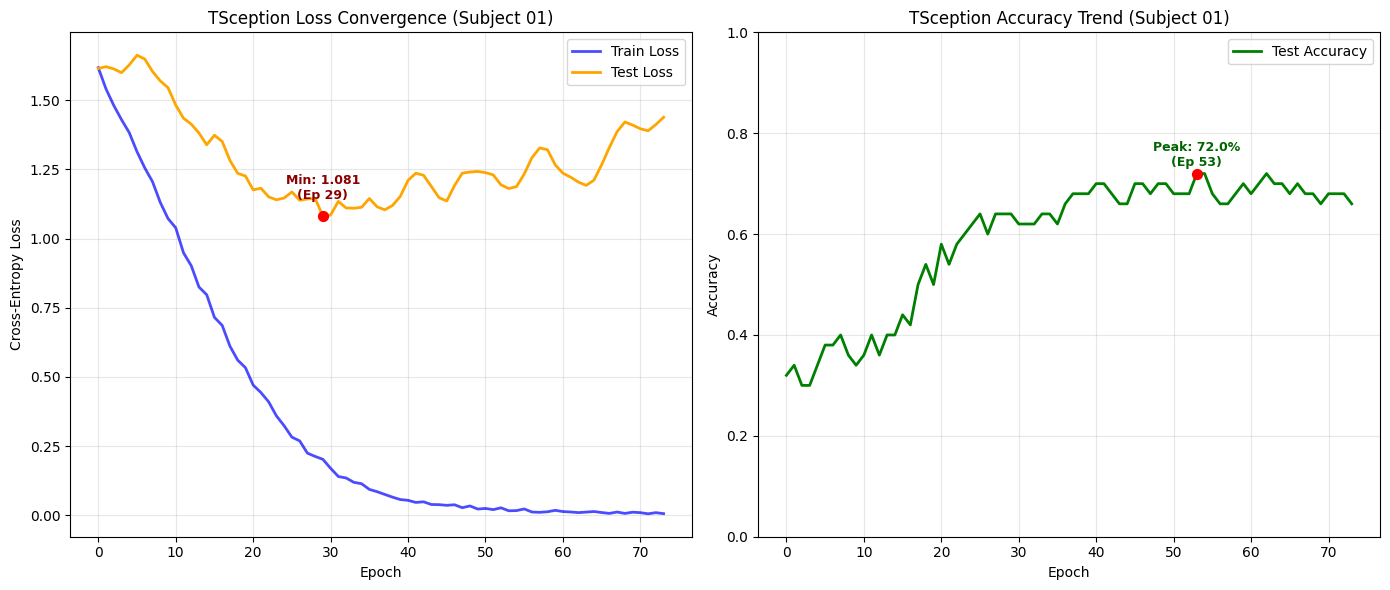

--- Generating Report for TSception baseline: TSception_train_0_test_01 ---


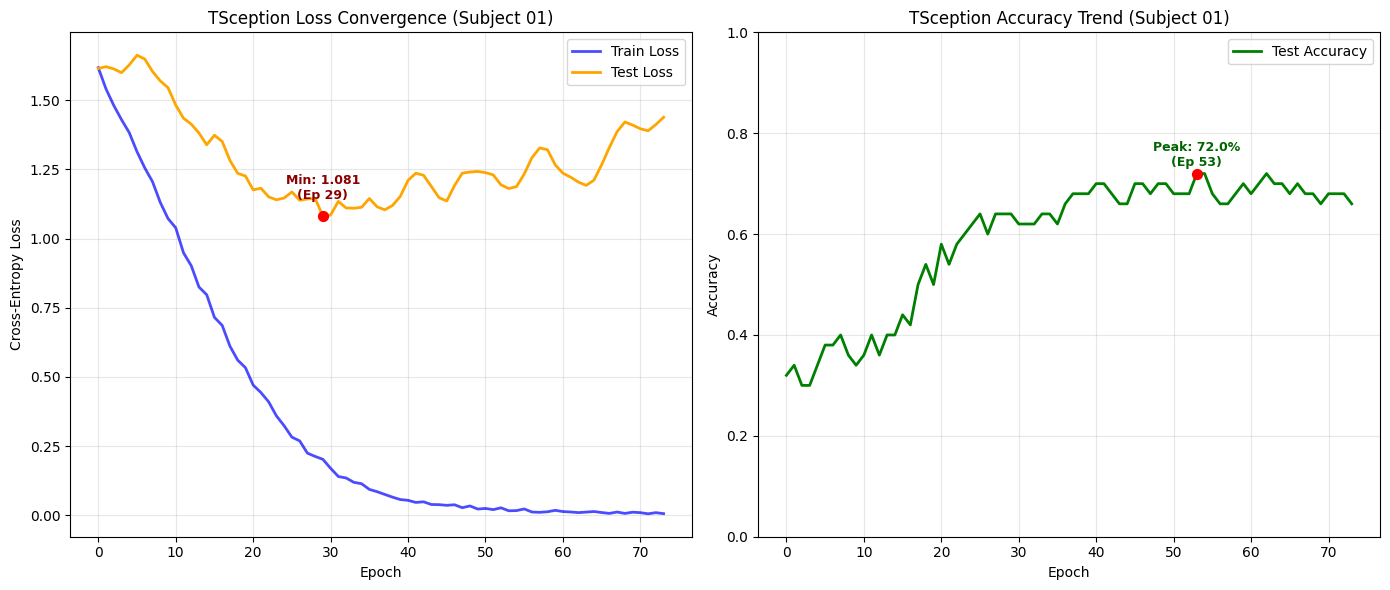


TSCEPTION TRAINING DYNAMICS SUMMARY
-----------------------------------
Peak Accuracy:  72.00% (Epoch 53)
Final Accuracy: 66.00% (Epoch 73)
Best Loss:      1.0812 (Epoch 29)

FINAL INFERENCE REPORT: TSCEPTION (SUBJECT 01)
---------------------------------------------
Inference Accuracy: 72.00%
Macro F1 Score:     0.7180
---------------------------------------------
              precision    recall  f1-score   support

       Hello       0.78      0.70      0.74        10
     Help Me       0.67      0.80      0.73        10
        Stop       0.89      0.80      0.84        10
   Thank You       0.62      0.80      0.70        10
         Yes       0.71      0.50      0.59        10

    accuracy                           0.72        50
   macro avg       0.73      0.72      0.72        50
weighted avg       0.73      0.72      0.72        50



--- Generating Report for TSception baseline: TSception_train_0_test_01 ---


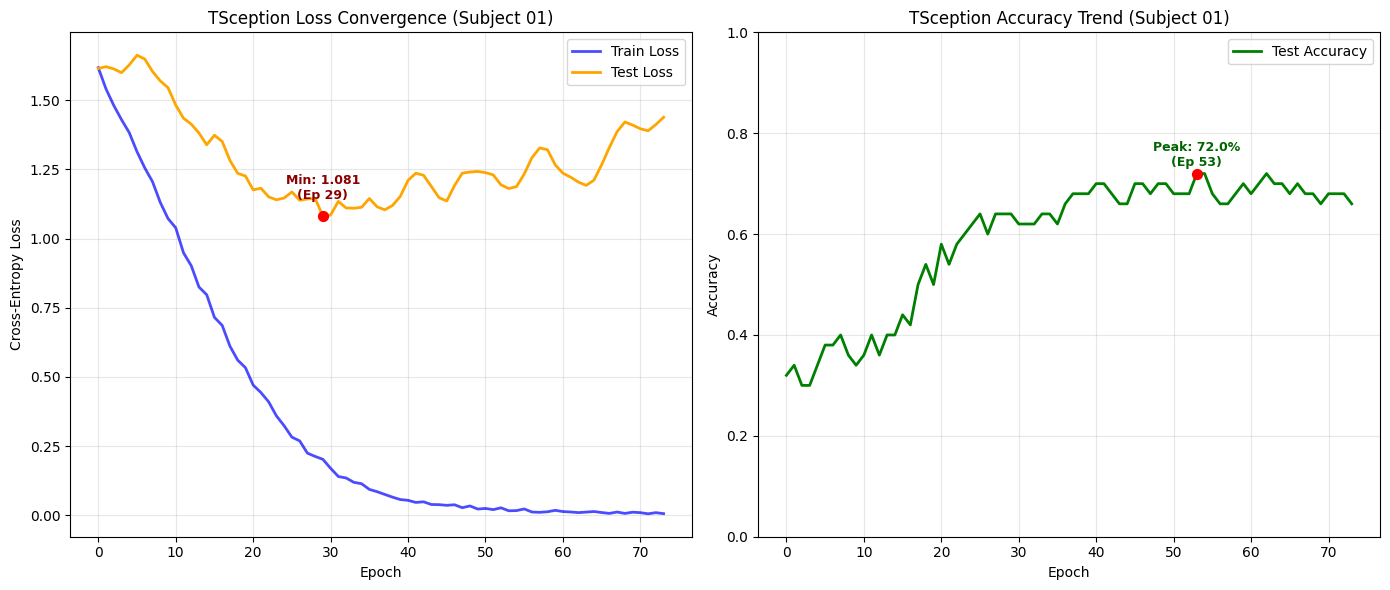


TSCEPTION TRAINING DYNAMICS SUMMARY
-----------------------------------
Peak Accuracy:  72.00% (Epoch 53)
Final Accuracy: 66.00% (Epoch 73)
Best Loss:      1.0812 (Epoch 29)

FINAL INFERENCE REPORT: TSCEPTION (SUBJECT 01)
---------------------------------------------
Inference Accuracy: 72.00%
Macro F1 Score:     0.7180
---------------------------------------------
              precision    recall  f1-score   support

       Hello       0.78      0.70      0.74        10
     Help Me       0.67      0.80      0.73        10
        Stop       0.89      0.80      0.84        10
   Thank You       0.62      0.80      0.70        10
         Yes       0.71      0.50      0.59        10

    accuracy                           0.72        50
   macro avg       0.73      0.72      0.72        50
weighted avg       0.73      0.72      0.72        50



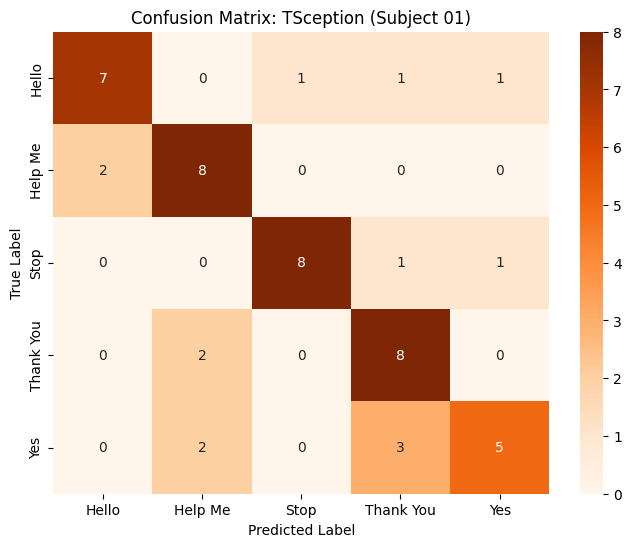

In [25]:
# ==============================================================================
# Loads telemetry data from the TSception comparison run to generate:
# 1. Learning Curves (Loss & Accuracy) with Peak/Min annotations.
# 2. Classification Report (Precision, Recall, F1-Score).
# 3. Confusion Matrix.
# ==============================================================================

TRAIN_INDICES = [0]
TEST_ID = '01'
RUN_NAME = f"TSception_train_{'-'.join(map(str, TRAIN_INDICES))}_test_{TEST_ID}"
LOG_DIR = f"logs/comparison_experiment/{RUN_NAME}"

print(f"--- Generating Report for TSception baseline: {RUN_NAME} ---")

metrics_path = f"{LOG_DIR}/metrics.csv"

if os.path.exists(metrics_path):
    # Load and aggregate metrics by epoch
    metrics_df = pd.read_csv(metrics_path)
    epoch_metrics = metrics_df.groupby('epoch').mean()

    # Identify Best Metrics (Min Loss / Max Accuracy)
    # --------------------------------------------------------------------------
    best_loss_val = None
    best_loss_ep = None
    best_acc_val = None
    best_acc_ep = None

    # Check for validation/test keys and find optima
    loss_key = next((k for k in ['val_loss', 'test_loss'] if k in epoch_metrics.columns), None)
    if loss_key:
        best_loss_val = epoch_metrics[loss_key].min()
        best_loss_ep = epoch_metrics[loss_key].idxmin()

    acc_key = next((k for k in ['val_acc', 'test_acc'] if k in epoch_metrics.columns), None)
    if acc_key:
        best_acc_val = epoch_metrics[acc_key].max()
        best_acc_ep = epoch_metrics[acc_key].idxmax()

    # Plotting
    # --------------------------------------------------------------------------
    plt.figure(figsize=(14, 6))

    # Subplot 1: Loss Trajectory
    plt.subplot(1, 2, 1)
    if 'train_loss' in epoch_metrics.columns:
        plt.plot(epoch_metrics.index, epoch_metrics['train_loss'], label='Train Loss', color='blue', linewidth=2, alpha=0.7)
    
    if loss_key:
        plt.plot(epoch_metrics.index, epoch_metrics[loss_key], label='Test Loss', color='orange', linewidth=2)
        plt.scatter(best_loss_ep, best_loss_val, color='red', s=50, zorder=5)
        plt.text(best_loss_ep, best_loss_val + 0.05, f"Min: {best_loss_val:.3f}\n(Ep {best_loss_ep})", 
                 ha='center', va='bottom', fontsize=9, fontweight='bold', color='darkred')

    plt.title(f'TSception Loss Convergence (Subject {TEST_ID})')
    plt.xlabel('Epoch')
    plt.ylabel('Cross-Entropy Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Subplot 2: Accuracy Trajectory
    plt.subplot(1, 2, 2)
    if acc_key:
        plt.plot(epoch_metrics.index, epoch_metrics[acc_key], label='Test Accuracy', color='green', linewidth=2)
        plt.scatter(best_acc_ep, best_acc_val, color='red', s=50, zorder=5)
        plt.text(best_acc_ep, best_acc_val + 0.01, f"Peak: {best_acc_val:.1%}\n(Ep {best_acc_ep})", 
                 ha='center', va='bottom', fontsize=9, fontweight='bold', color='darkgreen')

    plt.title(f'TSception Accuracy Trend (Subject {TEST_ID})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.0)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    print(f"\nTSCEPTION TRAINING DYNAMICS SUMMARY")
    print("-" * 35)
    if acc_key:
        print(f"Peak Accuracy:  {best_acc_val:.2%} (Epoch {best_acc_ep})")
        print(f"Final Accuracy: {epoch_metrics[acc_key].iloc[-1]:.2%} (Epoch {epoch_metrics.index[-1]})")
    if loss_key:
        print(f"Best Loss:      {best_loss_val:.4f} (Epoch {best_loss_ep})")

else:
    print(f"Metrics file not found: {metrics_path}")

# 3. Quantitative Evaluation (Final Inference)
# ------------------------------------------------------------------------------
results_path = f"{LOG_DIR}/final_test_results.csv"

if os.path.exists(results_path):
    data = np.loadtxt(results_path, delimiter=',')
    
    if data.ndim == 2 and data.shape[1] == 2:
        y_pred, y_true = data[:, 0], data[:, 1]
        classes = ['Hello', 'Help Me', 'Stop', 'Thank You', 'Yes']

        print(f"\nFINAL INFERENCE REPORT: TSCEPTION (SUBJECT {TEST_ID})")
        print("-" * 45)
        print(f"Inference Accuracy: {accuracy_score(y_true, y_pred):.2%}")
        print(f"Macro F1 Score:     {f1_score(y_true, y_pred, average='macro'):.4f}")
        print("-" * 45)
        print(classification_report(y_true, y_pred, target_names=classes))

        # Confusion Matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', 
                    xticklabels=classes, yticklabels=classes)
        plt.title(f'Confusion Matrix: TSception (Subject {TEST_ID})')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

# 14.1 TSCEPTION ZERO-COST GENERALIZABILITY CHECK

In [26]:
# ==============================================================================
# Evaluates the TSception model trained on S01 using S02 test data to determine 
# the model's cross-subject predictive power.
# ==============================================================================

# 1. Load Subject 02 Data (Validation)
target_sub_id = '02'
print(f"--- Testing TSception S01 Model on Subject {target_sub_id} ---")

if target_sub_id in test_library:
    test_loader_s02 = test_library[target_sub_id]
    
    # 2. Run Inference using the TSception model currently in memory
    y_pred, y_true = inference_on_loader(inference_model, test_loader_s02)
    
    # 3. Report Results
    acc = accuracy_score(y_true, y_pred)
    print(f"Cross-Subject Accuracy (TSception S01 -> Test S02): {acc:.2%}")
    print("Interpretation: Low scores indicate high subject-specificity of the neural patterns.")
else:
    print(f"Subject {target_sub_id} not in test library.")

--- Testing TSception S01 Model on Subject 02 ---
Cross-Subject Accuracy (TSception S01 -> Test S02): 24.00%
Interpretation: Low scores indicate high subject-specificity of the neural patterns.


# TSCEPTION TRAINING AND TESTING - SUBJECT 02


In [27]:
# ==============================================================================
# Purpose: Train the comparison model (same as block 12) on Subject 2
# ==============================================================================

pl.seed_everything(42)  # Ensures reproducibility across runs

# 1. Configuration
# ------------------------------------------------------------------------------
MAX_EPOCHS = 200
GPU_ID = 0

# [CONFIGURATION] Select Subject 02 to compare against FAST
TRAIN_SUBJECT_INDICES = [1]   # Subject 02
TEST_SUBJECT_ID = '02'        # Monitor Subject 02

# Distinct log directory for comparison results
run_name = f"TSception_train_{'-'.join(map(str, TRAIN_SUBJECT_INDICES))}_test_{TEST_SUBJECT_ID}"
logger = CSVLogger(save_dir="logs/", name="comparison_experiment", version=run_name)

# 2. Data Preparation (Reusing Logic from Block 8)
# ------------------------------------------------------------------------------
# Reload data to ensure clean global state before training
if 'load_standardized_h5' in globals():
    X, Y = load_standardized_h5('Processed/BCIC2020Track3.h5')
else:
    # Fallback if function not in scope
    import h5py
    X, Y = [], []
    with h5py.File('Processed/BCIC2020Track3.h5', 'r') as f:
        for i in range(1, 16):
            X.append(f[f"{i:02d}"]['X'][()])
            Y.append(f[f"{i:02d}"]['Y'][()])
    X, Y = np.array(X), np.array(Y)

# Isolate Subject Data
X_train_list = [X[i] for i in TRAIN_SUBJECT_INDICES]
Y_train_list = [Y[i] for i in TRAIN_SUBJECT_INDICES]

X_train_combined = np.concatenate(X_train_list, axis=0)
Y_train_combined = np.concatenate(Y_train_list, axis=0)

full_train_loader = DataLoader(
    BasicDataset(X_train_combined, Y_train_combined),
    batch_size=len(X_train_combined),
    shuffle=True, num_workers=2, pin_memory=True
)

target_test_loader = test_library[TEST_SUBJECT_ID]

# 3. Model Initialization (Using TSception)
# ------------------------------------------------------------------------------
model = TSception_Module(num_classes=5, max_epochs=MAX_EPOCHS)

# 4. Trainer Configuration
# ------------------------------------------------------------------------------
early_stop_callback = EarlyStopping(
    monitor="val_acc", stopping_threshold=1.0, mode="max", patience=20, verbose=True
)

checkpoint_callback = ModelCheckpoint(
    monitor="val_acc", mode="max", save_top_k=1, filename="tsception-best", verbose=True
)

trainer = pl.Trainer(
    strategy='auto', accelerator='gpu', devices=[GPU_ID], max_epochs=MAX_EPOCHS,
    logger=logger, callbacks=[early_stop_callback, checkpoint_callback],
    enable_progress_bar=True, enable_checkpointing=True, precision='bf16-mixed', log_every_n_steps=1
)

# 5. Execution
# ------------------------------------------------------------------------------
print(f"Starting TSception Training: Subject {TEST_SUBJECT_ID}")
trainer.fit(model, train_dataloaders=full_train_loader, val_dataloaders=target_test_loader)

# 6. Evaluation & Persistence
# ------------------------------------------------------------------------------
if checkpoint_callback.best_model_path:
    print(f"Reloading Best TSception Model: {checkpoint_callback.best_model_path}")
    best_model = TSception_Module.load_from_checkpoint(
        checkpoint_callback.best_model_path, weights_only=False
    )
    inference_model = best_model.model
else:
    inference_model = model.model

y_pred, y_true = inference_on_loader(inference_model, target_test_loader)

results_path = f"logs/comparison_experiment/{run_name}/final_test_results.csv"
os.makedirs(os.path.dirname(results_path), exist_ok=True)
np.savetxt(results_path, np.array([y_pred, y_true]).T, delimiter=',', fmt='%d')

print(f"\nBlock 15 Complete: TSception Results saved to {results_path}")

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.080, val_loss=1.400, val_acc=0.320]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.080, val_loss=1.400, val_acc=0.320]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.320
Epoch 10, global step 11: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.080, val_loss=1.400, val_acc=0.320]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.320
Epoch 10, global step 11: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=0.990, val_loss=1.360, val_acc=0.400]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.080, val_loss=1.400, val_acc=0.320]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.320
Epoch 10, global step 11: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=0.990, val_loss=1.360, val_acc=0.400]

Metric val_acc improved by 0.080 >= min_delta = 0.0. New best score: 0.400
Epoch 11, global step 12: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.080, val_loss=1.400, val_acc=0.320]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.320
Epoch 10, global step 11: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=0.990, val_loss=1.360, val_acc=0.400]

Metric val_acc improved by 0.080 >= min_delta = 0.0. New best score: 0.400
Epoch 11, global step 12: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_02, train_loss=0.935, val_loss=1.320, val_acc=0.420]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.080, val_loss=1.400, val_acc=0.320]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.320
Epoch 10, global step 11: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=0.990, val_loss=1.360, val_acc=0.400]

Metric val_acc improved by 0.080 >= min_delta = 0.0. New best score: 0.400
Epoch 11, global step 12: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_02, train_loss=0.935, val_loss=1.320, val_acc=0.420]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.420
Epoch 12, global step 13: 'val_acc' reached 0.42000 (best 0.42000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.080, val_loss=1.400, val_acc=0.320]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.320
Epoch 10, global step 11: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=0.990, val_loss=1.360, val_acc=0.400]

Metric val_acc improved by 0.080 >= min_delta = 0.0. New best score: 0.400
Epoch 11, global step 12: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_02, train_loss=0.935, val_loss=1.320, val_acc=0.420]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.420
Epoch 12, global step 13: 'val_acc' reached 0.42000 (best 0.42000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.863, val_loss=1.290, val_acc=0.480]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.080, val_loss=1.400, val_acc=0.320]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.320
Epoch 10, global step 11: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=0.990, val_loss=1.360, val_acc=0.400]

Metric val_acc improved by 0.080 >= min_delta = 0.0. New best score: 0.400
Epoch 11, global step 12: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_02, train_loss=0.935, val_loss=1.320, val_acc=0.420]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.420
Epoch 12, global step 13: 'val_acc' reached 0.42000 (best 0.42000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.863, val_loss=1.290, val_acc=0.480]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.480
Epoch 13, global step 14: 'val_acc' reached 0.48000 (best 0.48000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.080, val_loss=1.400, val_acc=0.320]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.320
Epoch 10, global step 11: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=0.990, val_loss=1.360, val_acc=0.400]

Metric val_acc improved by 0.080 >= min_delta = 0.0. New best score: 0.400
Epoch 11, global step 12: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_02, train_loss=0.935, val_loss=1.320, val_acc=0.420]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.420
Epoch 12, global step 13: 'val_acc' reached 0.42000 (best 0.42000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.863, val_loss=1.290, val_acc=0.480]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.480
Epoch 13, global step 14: 'val_acc' reached 0.48000 (best 0.48000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_02, train_loss=0.815, val_loss=1.260, val_acc=0.480]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.080, val_loss=1.400, val_acc=0.320]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.320
Epoch 10, global step 11: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=0.990, val_loss=1.360, val_acc=0.400]

Metric val_acc improved by 0.080 >= min_delta = 0.0. New best score: 0.400
Epoch 11, global step 12: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_02, train_loss=0.935, val_loss=1.320, val_acc=0.420]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.420
Epoch 12, global step 13: 'val_acc' reached 0.42000 (best 0.42000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.863, val_loss=1.290, val_acc=0.480]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.480
Epoch 13, global step 14: 'val_acc' reached 0.48000 (best 0.48000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_02, train_loss=0.815, val_loss=1.260, val_acc=0.480]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=0.749, val_loss=1.250, val_acc=0.540]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.080, val_loss=1.400, val_acc=0.320]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.320
Epoch 10, global step 11: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=0.990, val_loss=1.360, val_acc=0.400]

Metric val_acc improved by 0.080 >= min_delta = 0.0. New best score: 0.400
Epoch 11, global step 12: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_02, train_loss=0.935, val_loss=1.320, val_acc=0.420]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.420
Epoch 12, global step 13: 'val_acc' reached 0.42000 (best 0.42000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.863, val_loss=1.290, val_acc=0.480]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.480
Epoch 13, global step 14: 'val_acc' reached 0.48000 (best 0.48000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_02, train_loss=0.815, val_loss=1.260, val_acc=0.480]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=0.749, val_loss=1.250, val_acc=0.540]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.540
Epoch 15, global step 16: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.080, val_loss=1.400, val_acc=0.320]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.320
Epoch 10, global step 11: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=0.990, val_loss=1.360, val_acc=0.400]

Metric val_acc improved by 0.080 >= min_delta = 0.0. New best score: 0.400
Epoch 11, global step 12: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_02, train_loss=0.935, val_loss=1.320, val_acc=0.420]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.420
Epoch 12, global step 13: 'val_acc' reached 0.42000 (best 0.42000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.863, val_loss=1.290, val_acc=0.480]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.480
Epoch 13, global step 14: 'val_acc' reached 0.48000 (best 0.48000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_02, train_loss=0.815, val_loss=1.260, val_acc=0.480]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=0.749, val_loss=1.250, val_acc=0.540]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.540
Epoch 15, global step 16: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.695, val_loss=1.230, val_acc=0.580]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.080, val_loss=1.400, val_acc=0.320]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.320
Epoch 10, global step 11: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=0.990, val_loss=1.360, val_acc=0.400]

Metric val_acc improved by 0.080 >= min_delta = 0.0. New best score: 0.400
Epoch 11, global step 12: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_02, train_loss=0.935, val_loss=1.320, val_acc=0.420]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.420
Epoch 12, global step 13: 'val_acc' reached 0.42000 (best 0.42000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.863, val_loss=1.290, val_acc=0.480]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.480
Epoch 13, global step 14: 'val_acc' reached 0.48000 (best 0.48000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_02, train_loss=0.815, val_loss=1.260, val_acc=0.480]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=0.749, val_loss=1.250, val_acc=0.540]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.540
Epoch 15, global step 16: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.695, val_loss=1.230, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 16, global step 17: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.080, val_loss=1.400, val_acc=0.320]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.320
Epoch 10, global step 11: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=0.990, val_loss=1.360, val_acc=0.400]

Metric val_acc improved by 0.080 >= min_delta = 0.0. New best score: 0.400
Epoch 11, global step 12: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_02, train_loss=0.935, val_loss=1.320, val_acc=0.420]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.420
Epoch 12, global step 13: 'val_acc' reached 0.42000 (best 0.42000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.863, val_loss=1.290, val_acc=0.480]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.480
Epoch 13, global step 14: 'val_acc' reached 0.48000 (best 0.48000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_02, train_loss=0.815, val_loss=1.260, val_acc=0.480]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=0.749, val_loss=1.250, val_acc=0.540]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.540
Epoch 15, global step 16: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.695, val_loss=1.230, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 16, global step 17: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, v_num=t_02, train_loss=0.633, val_loss=1.220, val_acc=0.600]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.080, val_loss=1.400, val_acc=0.320]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.320
Epoch 10, global step 11: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=0.990, val_loss=1.360, val_acc=0.400]

Metric val_acc improved by 0.080 >= min_delta = 0.0. New best score: 0.400
Epoch 11, global step 12: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_02, train_loss=0.935, val_loss=1.320, val_acc=0.420]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.420
Epoch 12, global step 13: 'val_acc' reached 0.42000 (best 0.42000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.863, val_loss=1.290, val_acc=0.480]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.480
Epoch 13, global step 14: 'val_acc' reached 0.48000 (best 0.48000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_02, train_loss=0.815, val_loss=1.260, val_acc=0.480]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=0.749, val_loss=1.250, val_acc=0.540]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.540
Epoch 15, global step 16: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.695, val_loss=1.230, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 16, global step 17: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, v_num=t_02, train_loss=0.633, val_loss=1.220, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 17, global step 18: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.080, val_loss=1.400, val_acc=0.320]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.320
Epoch 10, global step 11: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=0.990, val_loss=1.360, val_acc=0.400]

Metric val_acc improved by 0.080 >= min_delta = 0.0. New best score: 0.400
Epoch 11, global step 12: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_02, train_loss=0.935, val_loss=1.320, val_acc=0.420]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.420
Epoch 12, global step 13: 'val_acc' reached 0.42000 (best 0.42000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.863, val_loss=1.290, val_acc=0.480]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.480
Epoch 13, global step 14: 'val_acc' reached 0.48000 (best 0.48000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_02, train_loss=0.815, val_loss=1.260, val_acc=0.480]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=0.749, val_loss=1.250, val_acc=0.540]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.540
Epoch 15, global step 16: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.695, val_loss=1.230, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 16, global step 17: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, v_num=t_02, train_loss=0.633, val_loss=1.220, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 17, global step 18: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=0.585, val_loss=1.210, val_acc=0.600]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.080, val_loss=1.400, val_acc=0.320]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.320
Epoch 10, global step 11: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=0.990, val_loss=1.360, val_acc=0.400]

Metric val_acc improved by 0.080 >= min_delta = 0.0. New best score: 0.400
Epoch 11, global step 12: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_02, train_loss=0.935, val_loss=1.320, val_acc=0.420]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.420
Epoch 12, global step 13: 'val_acc' reached 0.42000 (best 0.42000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.863, val_loss=1.290, val_acc=0.480]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.480
Epoch 13, global step 14: 'val_acc' reached 0.48000 (best 0.48000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_02, train_loss=0.815, val_loss=1.260, val_acc=0.480]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=0.749, val_loss=1.250, val_acc=0.540]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.540
Epoch 15, global step 16: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.695, val_loss=1.230, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 16, global step 17: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, v_num=t_02, train_loss=0.633, val_loss=1.220, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 17, global step 18: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=0.585, val_loss=1.210, val_acc=0.600]

Epoch 18, global step 19: 'val_acc' was not in top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_02, train_loss=0.547, val_loss=1.200, val_acc=0.560]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.080, val_loss=1.400, val_acc=0.320]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.320
Epoch 10, global step 11: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=0.990, val_loss=1.360, val_acc=0.400]

Metric val_acc improved by 0.080 >= min_delta = 0.0. New best score: 0.400
Epoch 11, global step 12: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_02, train_loss=0.935, val_loss=1.320, val_acc=0.420]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.420
Epoch 12, global step 13: 'val_acc' reached 0.42000 (best 0.42000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.863, val_loss=1.290, val_acc=0.480]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.480
Epoch 13, global step 14: 'val_acc' reached 0.48000 (best 0.48000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_02, train_loss=0.815, val_loss=1.260, val_acc=0.480]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=0.749, val_loss=1.250, val_acc=0.540]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.540
Epoch 15, global step 16: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.695, val_loss=1.230, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 16, global step 17: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, v_num=t_02, train_loss=0.633, val_loss=1.220, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 17, global step 18: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=0.585, val_loss=1.210, val_acc=0.600]

Epoch 18, global step 19: 'val_acc' was not in top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_02, train_loss=0.547, val_loss=1.200, val_acc=0.560]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_02, train_loss=0.510, val_loss=1.240, val_acc=0.560]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.080, val_loss=1.400, val_acc=0.320]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.320
Epoch 10, global step 11: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=0.990, val_loss=1.360, val_acc=0.400]

Metric val_acc improved by 0.080 >= min_delta = 0.0. New best score: 0.400
Epoch 11, global step 12: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_02, train_loss=0.935, val_loss=1.320, val_acc=0.420]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.420
Epoch 12, global step 13: 'val_acc' reached 0.42000 (best 0.42000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.863, val_loss=1.290, val_acc=0.480]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.480
Epoch 13, global step 14: 'val_acc' reached 0.48000 (best 0.48000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_02, train_loss=0.815, val_loss=1.260, val_acc=0.480]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=0.749, val_loss=1.250, val_acc=0.540]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.540
Epoch 15, global step 16: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.695, val_loss=1.230, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 16, global step 17: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, v_num=t_02, train_loss=0.633, val_loss=1.220, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 17, global step 18: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=0.585, val_loss=1.210, val_acc=0.600]

Epoch 18, global step 19: 'val_acc' was not in top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_02, train_loss=0.547, val_loss=1.200, val_acc=0.560]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_02, train_loss=0.510, val_loss=1.240, val_acc=0.560]

Epoch 20, global step 21: 'val_acc' was not in top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s, v_num=t_02, train_loss=0.458, val_loss=1.240, val_acc=0.580]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.080, val_loss=1.400, val_acc=0.320]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.320
Epoch 10, global step 11: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=0.990, val_loss=1.360, val_acc=0.400]

Metric val_acc improved by 0.080 >= min_delta = 0.0. New best score: 0.400
Epoch 11, global step 12: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_02, train_loss=0.935, val_loss=1.320, val_acc=0.420]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.420
Epoch 12, global step 13: 'val_acc' reached 0.42000 (best 0.42000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.863, val_loss=1.290, val_acc=0.480]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.480
Epoch 13, global step 14: 'val_acc' reached 0.48000 (best 0.48000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_02, train_loss=0.815, val_loss=1.260, val_acc=0.480]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=0.749, val_loss=1.250, val_acc=0.540]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.540
Epoch 15, global step 16: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.695, val_loss=1.230, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 16, global step 17: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, v_num=t_02, train_loss=0.633, val_loss=1.220, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 17, global step 18: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=0.585, val_loss=1.210, val_acc=0.600]

Epoch 18, global step 19: 'val_acc' was not in top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_02, train_loss=0.547, val_loss=1.200, val_acc=0.560]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_02, train_loss=0.510, val_loss=1.240, val_acc=0.560]

Epoch 20, global step 21: 'val_acc' was not in top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s, v_num=t_02, train_loss=0.458, val_loss=1.240, val_acc=0.580]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_02, train_loss=0.390, val_loss=1.240, val_acc=0.540]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.080, val_loss=1.400, val_acc=0.320]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.320
Epoch 10, global step 11: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=0.990, val_loss=1.360, val_acc=0.400]

Metric val_acc improved by 0.080 >= min_delta = 0.0. New best score: 0.400
Epoch 11, global step 12: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_02, train_loss=0.935, val_loss=1.320, val_acc=0.420]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.420
Epoch 12, global step 13: 'val_acc' reached 0.42000 (best 0.42000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.863, val_loss=1.290, val_acc=0.480]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.480
Epoch 13, global step 14: 'val_acc' reached 0.48000 (best 0.48000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_02, train_loss=0.815, val_loss=1.260, val_acc=0.480]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=0.749, val_loss=1.250, val_acc=0.540]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.540
Epoch 15, global step 16: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.695, val_loss=1.230, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 16, global step 17: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, v_num=t_02, train_loss=0.633, val_loss=1.220, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 17, global step 18: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=0.585, val_loss=1.210, val_acc=0.600]

Epoch 18, global step 19: 'val_acc' was not in top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_02, train_loss=0.547, val_loss=1.200, val_acc=0.560]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_02, train_loss=0.510, val_loss=1.240, val_acc=0.560]

Epoch 20, global step 21: 'val_acc' was not in top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s, v_num=t_02, train_loss=0.458, val_loss=1.240, val_acc=0.580]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_02, train_loss=0.390, val_loss=1.240, val_acc=0.540]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.357, val_loss=1.250, val_acc=0.540]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.080, val_loss=1.400, val_acc=0.320]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.320
Epoch 10, global step 11: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=0.990, val_loss=1.360, val_acc=0.400]

Metric val_acc improved by 0.080 >= min_delta = 0.0. New best score: 0.400
Epoch 11, global step 12: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_02, train_loss=0.935, val_loss=1.320, val_acc=0.420]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.420
Epoch 12, global step 13: 'val_acc' reached 0.42000 (best 0.42000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.863, val_loss=1.290, val_acc=0.480]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.480
Epoch 13, global step 14: 'val_acc' reached 0.48000 (best 0.48000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_02, train_loss=0.815, val_loss=1.260, val_acc=0.480]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=0.749, val_loss=1.250, val_acc=0.540]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.540
Epoch 15, global step 16: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.695, val_loss=1.230, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 16, global step 17: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, v_num=t_02, train_loss=0.633, val_loss=1.220, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 17, global step 18: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=0.585, val_loss=1.210, val_acc=0.600]

Epoch 18, global step 19: 'val_acc' was not in top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_02, train_loss=0.547, val_loss=1.200, val_acc=0.560]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_02, train_loss=0.510, val_loss=1.240, val_acc=0.560]

Epoch 20, global step 21: 'val_acc' was not in top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s, v_num=t_02, train_loss=0.458, val_loss=1.240, val_acc=0.580]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_02, train_loss=0.390, val_loss=1.240, val_acc=0.540]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.357, val_loss=1.250, val_acc=0.540]

Epoch 23, global step 24: 'val_acc' was not in top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.343, val_loss=1.240, val_acc=0.580]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.080, val_loss=1.400, val_acc=0.320]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.320
Epoch 10, global step 11: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=0.990, val_loss=1.360, val_acc=0.400]

Metric val_acc improved by 0.080 >= min_delta = 0.0. New best score: 0.400
Epoch 11, global step 12: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_02, train_loss=0.935, val_loss=1.320, val_acc=0.420]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.420
Epoch 12, global step 13: 'val_acc' reached 0.42000 (best 0.42000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.863, val_loss=1.290, val_acc=0.480]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.480
Epoch 13, global step 14: 'val_acc' reached 0.48000 (best 0.48000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_02, train_loss=0.815, val_loss=1.260, val_acc=0.480]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=0.749, val_loss=1.250, val_acc=0.540]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.540
Epoch 15, global step 16: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.695, val_loss=1.230, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 16, global step 17: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, v_num=t_02, train_loss=0.633, val_loss=1.220, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 17, global step 18: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=0.585, val_loss=1.210, val_acc=0.600]

Epoch 18, global step 19: 'val_acc' was not in top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_02, train_loss=0.547, val_loss=1.200, val_acc=0.560]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_02, train_loss=0.510, val_loss=1.240, val_acc=0.560]

Epoch 20, global step 21: 'val_acc' was not in top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s, v_num=t_02, train_loss=0.458, val_loss=1.240, val_acc=0.580]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_02, train_loss=0.390, val_loss=1.240, val_acc=0.540]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.357, val_loss=1.250, val_acc=0.540]

Epoch 23, global step 24: 'val_acc' was not in top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.343, val_loss=1.240, val_acc=0.580]

Epoch 24, global step 25: 'val_acc' was not in top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=t_02, train_loss=0.314, val_loss=1.250, val_acc=0.560]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.080, val_loss=1.400, val_acc=0.320]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.320
Epoch 10, global step 11: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=0.990, val_loss=1.360, val_acc=0.400]

Metric val_acc improved by 0.080 >= min_delta = 0.0. New best score: 0.400
Epoch 11, global step 12: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_02, train_loss=0.935, val_loss=1.320, val_acc=0.420]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.420
Epoch 12, global step 13: 'val_acc' reached 0.42000 (best 0.42000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.863, val_loss=1.290, val_acc=0.480]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.480
Epoch 13, global step 14: 'val_acc' reached 0.48000 (best 0.48000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_02, train_loss=0.815, val_loss=1.260, val_acc=0.480]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=0.749, val_loss=1.250, val_acc=0.540]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.540
Epoch 15, global step 16: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.695, val_loss=1.230, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 16, global step 17: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, v_num=t_02, train_loss=0.633, val_loss=1.220, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 17, global step 18: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=0.585, val_loss=1.210, val_acc=0.600]

Epoch 18, global step 19: 'val_acc' was not in top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_02, train_loss=0.547, val_loss=1.200, val_acc=0.560]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_02, train_loss=0.510, val_loss=1.240, val_acc=0.560]

Epoch 20, global step 21: 'val_acc' was not in top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s, v_num=t_02, train_loss=0.458, val_loss=1.240, val_acc=0.580]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_02, train_loss=0.390, val_loss=1.240, val_acc=0.540]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.357, val_loss=1.250, val_acc=0.540]

Epoch 23, global step 24: 'val_acc' was not in top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.343, val_loss=1.240, val_acc=0.580]

Epoch 24, global step 25: 'val_acc' was not in top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=t_02, train_loss=0.314, val_loss=1.250, val_acc=0.560]

Epoch 25, global step 26: 'val_acc' was not in top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=0.264, val_loss=1.270, val_acc=0.540]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.080, val_loss=1.400, val_acc=0.320]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.320
Epoch 10, global step 11: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=0.990, val_loss=1.360, val_acc=0.400]

Metric val_acc improved by 0.080 >= min_delta = 0.0. New best score: 0.400
Epoch 11, global step 12: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_02, train_loss=0.935, val_loss=1.320, val_acc=0.420]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.420
Epoch 12, global step 13: 'val_acc' reached 0.42000 (best 0.42000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.863, val_loss=1.290, val_acc=0.480]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.480
Epoch 13, global step 14: 'val_acc' reached 0.48000 (best 0.48000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_02, train_loss=0.815, val_loss=1.260, val_acc=0.480]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=0.749, val_loss=1.250, val_acc=0.540]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.540
Epoch 15, global step 16: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.695, val_loss=1.230, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 16, global step 17: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, v_num=t_02, train_loss=0.633, val_loss=1.220, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 17, global step 18: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=0.585, val_loss=1.210, val_acc=0.600]

Epoch 18, global step 19: 'val_acc' was not in top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_02, train_loss=0.547, val_loss=1.200, val_acc=0.560]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_02, train_loss=0.510, val_loss=1.240, val_acc=0.560]

Epoch 20, global step 21: 'val_acc' was not in top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s, v_num=t_02, train_loss=0.458, val_loss=1.240, val_acc=0.580]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_02, train_loss=0.390, val_loss=1.240, val_acc=0.540]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.357, val_loss=1.250, val_acc=0.540]

Epoch 23, global step 24: 'val_acc' was not in top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.343, val_loss=1.240, val_acc=0.580]

Epoch 24, global step 25: 'val_acc' was not in top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=t_02, train_loss=0.314, val_loss=1.250, val_acc=0.560]

Epoch 25, global step 26: 'val_acc' was not in top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=0.264, val_loss=1.270, val_acc=0.540]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s, v_num=t_02, train_loss=0.236, val_loss=1.260, val_acc=0.560]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.080, val_loss=1.400, val_acc=0.320]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.320
Epoch 10, global step 11: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=0.990, val_loss=1.360, val_acc=0.400]

Metric val_acc improved by 0.080 >= min_delta = 0.0. New best score: 0.400
Epoch 11, global step 12: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_02, train_loss=0.935, val_loss=1.320, val_acc=0.420]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.420
Epoch 12, global step 13: 'val_acc' reached 0.42000 (best 0.42000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.863, val_loss=1.290, val_acc=0.480]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.480
Epoch 13, global step 14: 'val_acc' reached 0.48000 (best 0.48000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_02, train_loss=0.815, val_loss=1.260, val_acc=0.480]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=0.749, val_loss=1.250, val_acc=0.540]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.540
Epoch 15, global step 16: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.695, val_loss=1.230, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 16, global step 17: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, v_num=t_02, train_loss=0.633, val_loss=1.220, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 17, global step 18: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=0.585, val_loss=1.210, val_acc=0.600]

Epoch 18, global step 19: 'val_acc' was not in top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_02, train_loss=0.547, val_loss=1.200, val_acc=0.560]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_02, train_loss=0.510, val_loss=1.240, val_acc=0.560]

Epoch 20, global step 21: 'val_acc' was not in top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s, v_num=t_02, train_loss=0.458, val_loss=1.240, val_acc=0.580]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_02, train_loss=0.390, val_loss=1.240, val_acc=0.540]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.357, val_loss=1.250, val_acc=0.540]

Epoch 23, global step 24: 'val_acc' was not in top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.343, val_loss=1.240, val_acc=0.580]

Epoch 24, global step 25: 'val_acc' was not in top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=t_02, train_loss=0.314, val_loss=1.250, val_acc=0.560]

Epoch 25, global step 26: 'val_acc' was not in top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=0.264, val_loss=1.270, val_acc=0.540]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s, v_num=t_02, train_loss=0.236, val_loss=1.260, val_acc=0.560]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_02, train_loss=0.206, val_loss=1.210, val_acc=0.580]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.080, val_loss=1.400, val_acc=0.320]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.320
Epoch 10, global step 11: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=0.990, val_loss=1.360, val_acc=0.400]

Metric val_acc improved by 0.080 >= min_delta = 0.0. New best score: 0.400
Epoch 11, global step 12: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_02, train_loss=0.935, val_loss=1.320, val_acc=0.420]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.420
Epoch 12, global step 13: 'val_acc' reached 0.42000 (best 0.42000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.863, val_loss=1.290, val_acc=0.480]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.480
Epoch 13, global step 14: 'val_acc' reached 0.48000 (best 0.48000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_02, train_loss=0.815, val_loss=1.260, val_acc=0.480]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=0.749, val_loss=1.250, val_acc=0.540]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.540
Epoch 15, global step 16: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.695, val_loss=1.230, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 16, global step 17: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, v_num=t_02, train_loss=0.633, val_loss=1.220, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 17, global step 18: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=0.585, val_loss=1.210, val_acc=0.600]

Epoch 18, global step 19: 'val_acc' was not in top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_02, train_loss=0.547, val_loss=1.200, val_acc=0.560]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_02, train_loss=0.510, val_loss=1.240, val_acc=0.560]

Epoch 20, global step 21: 'val_acc' was not in top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s, v_num=t_02, train_loss=0.458, val_loss=1.240, val_acc=0.580]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_02, train_loss=0.390, val_loss=1.240, val_acc=0.540]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.357, val_loss=1.250, val_acc=0.540]

Epoch 23, global step 24: 'val_acc' was not in top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.343, val_loss=1.240, val_acc=0.580]

Epoch 24, global step 25: 'val_acc' was not in top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=t_02, train_loss=0.314, val_loss=1.250, val_acc=0.560]

Epoch 25, global step 26: 'val_acc' was not in top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=0.264, val_loss=1.270, val_acc=0.540]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s, v_num=t_02, train_loss=0.236, val_loss=1.260, val_acc=0.560]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_02, train_loss=0.206, val_loss=1.210, val_acc=0.580]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_02, train_loss=0.175, val_loss=1.220, val_acc=0.540]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.080, val_loss=1.400, val_acc=0.320]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.320
Epoch 10, global step 11: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=0.990, val_loss=1.360, val_acc=0.400]

Metric val_acc improved by 0.080 >= min_delta = 0.0. New best score: 0.400
Epoch 11, global step 12: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_02, train_loss=0.935, val_loss=1.320, val_acc=0.420]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.420
Epoch 12, global step 13: 'val_acc' reached 0.42000 (best 0.42000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.863, val_loss=1.290, val_acc=0.480]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.480
Epoch 13, global step 14: 'val_acc' reached 0.48000 (best 0.48000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_02, train_loss=0.815, val_loss=1.260, val_acc=0.480]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=0.749, val_loss=1.250, val_acc=0.540]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.540
Epoch 15, global step 16: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.695, val_loss=1.230, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 16, global step 17: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, v_num=t_02, train_loss=0.633, val_loss=1.220, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 17, global step 18: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=0.585, val_loss=1.210, val_acc=0.600]

Epoch 18, global step 19: 'val_acc' was not in top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_02, train_loss=0.547, val_loss=1.200, val_acc=0.560]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_02, train_loss=0.510, val_loss=1.240, val_acc=0.560]

Epoch 20, global step 21: 'val_acc' was not in top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s, v_num=t_02, train_loss=0.458, val_loss=1.240, val_acc=0.580]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_02, train_loss=0.390, val_loss=1.240, val_acc=0.540]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.357, val_loss=1.250, val_acc=0.540]

Epoch 23, global step 24: 'val_acc' was not in top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.343, val_loss=1.240, val_acc=0.580]

Epoch 24, global step 25: 'val_acc' was not in top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=t_02, train_loss=0.314, val_loss=1.250, val_acc=0.560]

Epoch 25, global step 26: 'val_acc' was not in top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=0.264, val_loss=1.270, val_acc=0.540]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s, v_num=t_02, train_loss=0.236, val_loss=1.260, val_acc=0.560]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_02, train_loss=0.206, val_loss=1.210, val_acc=0.580]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_02, train_loss=0.175, val_loss=1.220, val_acc=0.540]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_02, train_loss=0.174, val_loss=1.300, val_acc=0.560]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.080, val_loss=1.400, val_acc=0.320]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.320
Epoch 10, global step 11: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=0.990, val_loss=1.360, val_acc=0.400]

Metric val_acc improved by 0.080 >= min_delta = 0.0. New best score: 0.400
Epoch 11, global step 12: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_02, train_loss=0.935, val_loss=1.320, val_acc=0.420]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.420
Epoch 12, global step 13: 'val_acc' reached 0.42000 (best 0.42000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.863, val_loss=1.290, val_acc=0.480]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.480
Epoch 13, global step 14: 'val_acc' reached 0.48000 (best 0.48000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_02, train_loss=0.815, val_loss=1.260, val_acc=0.480]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=0.749, val_loss=1.250, val_acc=0.540]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.540
Epoch 15, global step 16: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.695, val_loss=1.230, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 16, global step 17: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, v_num=t_02, train_loss=0.633, val_loss=1.220, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 17, global step 18: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=0.585, val_loss=1.210, val_acc=0.600]

Epoch 18, global step 19: 'val_acc' was not in top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_02, train_loss=0.547, val_loss=1.200, val_acc=0.560]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_02, train_loss=0.510, val_loss=1.240, val_acc=0.560]

Epoch 20, global step 21: 'val_acc' was not in top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s, v_num=t_02, train_loss=0.458, val_loss=1.240, val_acc=0.580]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_02, train_loss=0.390, val_loss=1.240, val_acc=0.540]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.357, val_loss=1.250, val_acc=0.540]

Epoch 23, global step 24: 'val_acc' was not in top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.343, val_loss=1.240, val_acc=0.580]

Epoch 24, global step 25: 'val_acc' was not in top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=t_02, train_loss=0.314, val_loss=1.250, val_acc=0.560]

Epoch 25, global step 26: 'val_acc' was not in top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=0.264, val_loss=1.270, val_acc=0.540]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s, v_num=t_02, train_loss=0.236, val_loss=1.260, val_acc=0.560]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_02, train_loss=0.206, val_loss=1.210, val_acc=0.580]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_02, train_loss=0.175, val_loss=1.220, val_acc=0.540]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_02, train_loss=0.174, val_loss=1.300, val_acc=0.560]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s, v_num=t_02, train_loss=0.157, val_loss=1.280, val_acc=0.580]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.080, val_loss=1.400, val_acc=0.320]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.320
Epoch 10, global step 11: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=0.990, val_loss=1.360, val_acc=0.400]

Metric val_acc improved by 0.080 >= min_delta = 0.0. New best score: 0.400
Epoch 11, global step 12: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_02, train_loss=0.935, val_loss=1.320, val_acc=0.420]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.420
Epoch 12, global step 13: 'val_acc' reached 0.42000 (best 0.42000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.863, val_loss=1.290, val_acc=0.480]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.480
Epoch 13, global step 14: 'val_acc' reached 0.48000 (best 0.48000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_02, train_loss=0.815, val_loss=1.260, val_acc=0.480]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=0.749, val_loss=1.250, val_acc=0.540]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.540
Epoch 15, global step 16: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.695, val_loss=1.230, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 16, global step 17: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, v_num=t_02, train_loss=0.633, val_loss=1.220, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 17, global step 18: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=0.585, val_loss=1.210, val_acc=0.600]

Epoch 18, global step 19: 'val_acc' was not in top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_02, train_loss=0.547, val_loss=1.200, val_acc=0.560]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_02, train_loss=0.510, val_loss=1.240, val_acc=0.560]

Epoch 20, global step 21: 'val_acc' was not in top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s, v_num=t_02, train_loss=0.458, val_loss=1.240, val_acc=0.580]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_02, train_loss=0.390, val_loss=1.240, val_acc=0.540]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.357, val_loss=1.250, val_acc=0.540]

Epoch 23, global step 24: 'val_acc' was not in top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.343, val_loss=1.240, val_acc=0.580]

Epoch 24, global step 25: 'val_acc' was not in top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=t_02, train_loss=0.314, val_loss=1.250, val_acc=0.560]

Epoch 25, global step 26: 'val_acc' was not in top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=0.264, val_loss=1.270, val_acc=0.540]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s, v_num=t_02, train_loss=0.236, val_loss=1.260, val_acc=0.560]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_02, train_loss=0.206, val_loss=1.210, val_acc=0.580]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_02, train_loss=0.175, val_loss=1.220, val_acc=0.540]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_02, train_loss=0.174, val_loss=1.300, val_acc=0.560]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s, v_num=t_02, train_loss=0.157, val_loss=1.280, val_acc=0.580]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_02, train_loss=0.137, val_loss=1.260, val_acc=0.520]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.080, val_loss=1.400, val_acc=0.320]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.320
Epoch 10, global step 11: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=0.990, val_loss=1.360, val_acc=0.400]

Metric val_acc improved by 0.080 >= min_delta = 0.0. New best score: 0.400
Epoch 11, global step 12: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_02, train_loss=0.935, val_loss=1.320, val_acc=0.420]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.420
Epoch 12, global step 13: 'val_acc' reached 0.42000 (best 0.42000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.863, val_loss=1.290, val_acc=0.480]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.480
Epoch 13, global step 14: 'val_acc' reached 0.48000 (best 0.48000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_02, train_loss=0.815, val_loss=1.260, val_acc=0.480]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=0.749, val_loss=1.250, val_acc=0.540]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.540
Epoch 15, global step 16: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.695, val_loss=1.230, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 16, global step 17: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, v_num=t_02, train_loss=0.633, val_loss=1.220, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 17, global step 18: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=0.585, val_loss=1.210, val_acc=0.600]

Epoch 18, global step 19: 'val_acc' was not in top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_02, train_loss=0.547, val_loss=1.200, val_acc=0.560]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_02, train_loss=0.510, val_loss=1.240, val_acc=0.560]

Epoch 20, global step 21: 'val_acc' was not in top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s, v_num=t_02, train_loss=0.458, val_loss=1.240, val_acc=0.580]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_02, train_loss=0.390, val_loss=1.240, val_acc=0.540]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.357, val_loss=1.250, val_acc=0.540]

Epoch 23, global step 24: 'val_acc' was not in top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.343, val_loss=1.240, val_acc=0.580]

Epoch 24, global step 25: 'val_acc' was not in top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=t_02, train_loss=0.314, val_loss=1.250, val_acc=0.560]

Epoch 25, global step 26: 'val_acc' was not in top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=0.264, val_loss=1.270, val_acc=0.540]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s, v_num=t_02, train_loss=0.236, val_loss=1.260, val_acc=0.560]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_02, train_loss=0.206, val_loss=1.210, val_acc=0.580]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_02, train_loss=0.175, val_loss=1.220, val_acc=0.540]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_02, train_loss=0.174, val_loss=1.300, val_acc=0.560]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s, v_num=t_02, train_loss=0.157, val_loss=1.280, val_acc=0.580]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_02, train_loss=0.137, val_loss=1.260, val_acc=0.520]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=0.121, val_loss=1.300, val_acc=0.580]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.080, val_loss=1.400, val_acc=0.320]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.320
Epoch 10, global step 11: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=0.990, val_loss=1.360, val_acc=0.400]

Metric val_acc improved by 0.080 >= min_delta = 0.0. New best score: 0.400
Epoch 11, global step 12: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_02, train_loss=0.935, val_loss=1.320, val_acc=0.420]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.420
Epoch 12, global step 13: 'val_acc' reached 0.42000 (best 0.42000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.863, val_loss=1.290, val_acc=0.480]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.480
Epoch 13, global step 14: 'val_acc' reached 0.48000 (best 0.48000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_02, train_loss=0.815, val_loss=1.260, val_acc=0.480]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=0.749, val_loss=1.250, val_acc=0.540]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.540
Epoch 15, global step 16: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.695, val_loss=1.230, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 16, global step 17: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, v_num=t_02, train_loss=0.633, val_loss=1.220, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 17, global step 18: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=0.585, val_loss=1.210, val_acc=0.600]

Epoch 18, global step 19: 'val_acc' was not in top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_02, train_loss=0.547, val_loss=1.200, val_acc=0.560]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_02, train_loss=0.510, val_loss=1.240, val_acc=0.560]

Epoch 20, global step 21: 'val_acc' was not in top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s, v_num=t_02, train_loss=0.458, val_loss=1.240, val_acc=0.580]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_02, train_loss=0.390, val_loss=1.240, val_acc=0.540]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.357, val_loss=1.250, val_acc=0.540]

Epoch 23, global step 24: 'val_acc' was not in top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.343, val_loss=1.240, val_acc=0.580]

Epoch 24, global step 25: 'val_acc' was not in top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=t_02, train_loss=0.314, val_loss=1.250, val_acc=0.560]

Epoch 25, global step 26: 'val_acc' was not in top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=0.264, val_loss=1.270, val_acc=0.540]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s, v_num=t_02, train_loss=0.236, val_loss=1.260, val_acc=0.560]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_02, train_loss=0.206, val_loss=1.210, val_acc=0.580]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_02, train_loss=0.175, val_loss=1.220, val_acc=0.540]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_02, train_loss=0.174, val_loss=1.300, val_acc=0.560]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s, v_num=t_02, train_loss=0.157, val_loss=1.280, val_acc=0.580]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_02, train_loss=0.137, val_loss=1.260, val_acc=0.520]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=0.121, val_loss=1.300, val_acc=0.580]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_02, train_loss=0.091, val_loss=1.320, val_acc=0.600]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.080, val_loss=1.400, val_acc=0.320]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.320
Epoch 10, global step 11: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=0.990, val_loss=1.360, val_acc=0.400]

Metric val_acc improved by 0.080 >= min_delta = 0.0. New best score: 0.400
Epoch 11, global step 12: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_02, train_loss=0.935, val_loss=1.320, val_acc=0.420]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.420
Epoch 12, global step 13: 'val_acc' reached 0.42000 (best 0.42000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.863, val_loss=1.290, val_acc=0.480]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.480
Epoch 13, global step 14: 'val_acc' reached 0.48000 (best 0.48000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_02, train_loss=0.815, val_loss=1.260, val_acc=0.480]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=0.749, val_loss=1.250, val_acc=0.540]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.540
Epoch 15, global step 16: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.695, val_loss=1.230, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 16, global step 17: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, v_num=t_02, train_loss=0.633, val_loss=1.220, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 17, global step 18: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=0.585, val_loss=1.210, val_acc=0.600]

Epoch 18, global step 19: 'val_acc' was not in top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_02, train_loss=0.547, val_loss=1.200, val_acc=0.560]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_02, train_loss=0.510, val_loss=1.240, val_acc=0.560]

Epoch 20, global step 21: 'val_acc' was not in top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s, v_num=t_02, train_loss=0.458, val_loss=1.240, val_acc=0.580]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_02, train_loss=0.390, val_loss=1.240, val_acc=0.540]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.357, val_loss=1.250, val_acc=0.540]

Epoch 23, global step 24: 'val_acc' was not in top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.343, val_loss=1.240, val_acc=0.580]

Epoch 24, global step 25: 'val_acc' was not in top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=t_02, train_loss=0.314, val_loss=1.250, val_acc=0.560]

Epoch 25, global step 26: 'val_acc' was not in top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=0.264, val_loss=1.270, val_acc=0.540]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s, v_num=t_02, train_loss=0.236, val_loss=1.260, val_acc=0.560]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_02, train_loss=0.206, val_loss=1.210, val_acc=0.580]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_02, train_loss=0.175, val_loss=1.220, val_acc=0.540]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_02, train_loss=0.174, val_loss=1.300, val_acc=0.560]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s, v_num=t_02, train_loss=0.157, val_loss=1.280, val_acc=0.580]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_02, train_loss=0.137, val_loss=1.260, val_acc=0.520]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=0.121, val_loss=1.300, val_acc=0.580]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_02, train_loss=0.091, val_loss=1.320, val_acc=0.600]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_02, train_loss=0.0919, val_loss=1.300, val_acc=0.600]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.080, val_loss=1.400, val_acc=0.320]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.320
Epoch 10, global step 11: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=0.990, val_loss=1.360, val_acc=0.400]

Metric val_acc improved by 0.080 >= min_delta = 0.0. New best score: 0.400
Epoch 11, global step 12: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_02, train_loss=0.935, val_loss=1.320, val_acc=0.420]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.420
Epoch 12, global step 13: 'val_acc' reached 0.42000 (best 0.42000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.863, val_loss=1.290, val_acc=0.480]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.480
Epoch 13, global step 14: 'val_acc' reached 0.48000 (best 0.48000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_02, train_loss=0.815, val_loss=1.260, val_acc=0.480]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=0.749, val_loss=1.250, val_acc=0.540]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.540
Epoch 15, global step 16: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.695, val_loss=1.230, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 16, global step 17: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, v_num=t_02, train_loss=0.633, val_loss=1.220, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 17, global step 18: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=0.585, val_loss=1.210, val_acc=0.600]

Epoch 18, global step 19: 'val_acc' was not in top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_02, train_loss=0.547, val_loss=1.200, val_acc=0.560]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_02, train_loss=0.510, val_loss=1.240, val_acc=0.560]

Epoch 20, global step 21: 'val_acc' was not in top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s, v_num=t_02, train_loss=0.458, val_loss=1.240, val_acc=0.580]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_02, train_loss=0.390, val_loss=1.240, val_acc=0.540]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.357, val_loss=1.250, val_acc=0.540]

Epoch 23, global step 24: 'val_acc' was not in top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.343, val_loss=1.240, val_acc=0.580]

Epoch 24, global step 25: 'val_acc' was not in top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=t_02, train_loss=0.314, val_loss=1.250, val_acc=0.560]

Epoch 25, global step 26: 'val_acc' was not in top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=0.264, val_loss=1.270, val_acc=0.540]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s, v_num=t_02, train_loss=0.236, val_loss=1.260, val_acc=0.560]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_02, train_loss=0.206, val_loss=1.210, val_acc=0.580]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_02, train_loss=0.175, val_loss=1.220, val_acc=0.540]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_02, train_loss=0.174, val_loss=1.300, val_acc=0.560]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s, v_num=t_02, train_loss=0.157, val_loss=1.280, val_acc=0.580]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_02, train_loss=0.137, val_loss=1.260, val_acc=0.520]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=0.121, val_loss=1.300, val_acc=0.580]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_02, train_loss=0.091, val_loss=1.320, val_acc=0.600]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_02, train_loss=0.0919, val_loss=1.300, val_acc=0.600]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_02, train_loss=0.0814, val_loss=1.380, val_acc=0.600]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.080, val_loss=1.400, val_acc=0.320]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.320
Epoch 10, global step 11: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=0.990, val_loss=1.360, val_acc=0.400]

Metric val_acc improved by 0.080 >= min_delta = 0.0. New best score: 0.400
Epoch 11, global step 12: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_02, train_loss=0.935, val_loss=1.320, val_acc=0.420]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.420
Epoch 12, global step 13: 'val_acc' reached 0.42000 (best 0.42000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.863, val_loss=1.290, val_acc=0.480]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.480
Epoch 13, global step 14: 'val_acc' reached 0.48000 (best 0.48000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_02, train_loss=0.815, val_loss=1.260, val_acc=0.480]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=0.749, val_loss=1.250, val_acc=0.540]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.540
Epoch 15, global step 16: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.695, val_loss=1.230, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 16, global step 17: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, v_num=t_02, train_loss=0.633, val_loss=1.220, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 17, global step 18: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=0.585, val_loss=1.210, val_acc=0.600]

Epoch 18, global step 19: 'val_acc' was not in top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_02, train_loss=0.547, val_loss=1.200, val_acc=0.560]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_02, train_loss=0.510, val_loss=1.240, val_acc=0.560]

Epoch 20, global step 21: 'val_acc' was not in top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s, v_num=t_02, train_loss=0.458, val_loss=1.240, val_acc=0.580]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_02, train_loss=0.390, val_loss=1.240, val_acc=0.540]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.357, val_loss=1.250, val_acc=0.540]

Epoch 23, global step 24: 'val_acc' was not in top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.343, val_loss=1.240, val_acc=0.580]

Epoch 24, global step 25: 'val_acc' was not in top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=t_02, train_loss=0.314, val_loss=1.250, val_acc=0.560]

Epoch 25, global step 26: 'val_acc' was not in top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=0.264, val_loss=1.270, val_acc=0.540]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s, v_num=t_02, train_loss=0.236, val_loss=1.260, val_acc=0.560]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_02, train_loss=0.206, val_loss=1.210, val_acc=0.580]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_02, train_loss=0.175, val_loss=1.220, val_acc=0.540]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_02, train_loss=0.174, val_loss=1.300, val_acc=0.560]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s, v_num=t_02, train_loss=0.157, val_loss=1.280, val_acc=0.580]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_02, train_loss=0.137, val_loss=1.260, val_acc=0.520]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=0.121, val_loss=1.300, val_acc=0.580]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_02, train_loss=0.091, val_loss=1.320, val_acc=0.600]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_02, train_loss=0.0919, val_loss=1.300, val_acc=0.600]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_02, train_loss=0.0814, val_loss=1.380, val_acc=0.600]

Epoch 36, global step 37: 'val_acc' was not in top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_02, train_loss=0.0756, val_loss=1.460, val_acc=0.580]

Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.080, val_loss=1.400, val_acc=0.320]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.320
Epoch 10, global step 11: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=0.990, val_loss=1.360, val_acc=0.400]

Metric val_acc improved by 0.080 >= min_delta = 0.0. New best score: 0.400
Epoch 11, global step 12: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_02, train_loss=0.935, val_loss=1.320, val_acc=0.420]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.420
Epoch 12, global step 13: 'val_acc' reached 0.42000 (best 0.42000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.863, val_loss=1.290, val_acc=0.480]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.480
Epoch 13, global step 14: 'val_acc' reached 0.48000 (best 0.48000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_02, train_loss=0.815, val_loss=1.260, val_acc=0.480]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=0.749, val_loss=1.250, val_acc=0.540]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.540
Epoch 15, global step 16: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.695, val_loss=1.230, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 16, global step 17: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, v_num=t_02, train_loss=0.633, val_loss=1.220, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 17, global step 18: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=0.585, val_loss=1.210, val_acc=0.600]

Epoch 18, global step 19: 'val_acc' was not in top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_02, train_loss=0.547, val_loss=1.200, val_acc=0.560]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_02, train_loss=0.510, val_loss=1.240, val_acc=0.560]

Epoch 20, global step 21: 'val_acc' was not in top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s, v_num=t_02, train_loss=0.458, val_loss=1.240, val_acc=0.580]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_02, train_loss=0.390, val_loss=1.240, val_acc=0.540]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.357, val_loss=1.250, val_acc=0.540]

Epoch 23, global step 24: 'val_acc' was not in top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.343, val_loss=1.240, val_acc=0.580]

Epoch 24, global step 25: 'val_acc' was not in top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=t_02, train_loss=0.314, val_loss=1.250, val_acc=0.560]

Epoch 25, global step 26: 'val_acc' was not in top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=0.264, val_loss=1.270, val_acc=0.540]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s, v_num=t_02, train_loss=0.236, val_loss=1.260, val_acc=0.560]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_02, train_loss=0.206, val_loss=1.210, val_acc=0.580]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_02, train_loss=0.175, val_loss=1.220, val_acc=0.540]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_02, train_loss=0.174, val_loss=1.300, val_acc=0.560]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s, v_num=t_02, train_loss=0.157, val_loss=1.280, val_acc=0.580]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_02, train_loss=0.137, val_loss=1.260, val_acc=0.520]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=0.121, val_loss=1.300, val_acc=0.580]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_02, train_loss=0.091, val_loss=1.320, val_acc=0.600]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_02, train_loss=0.0919, val_loss=1.300, val_acc=0.600]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_02, train_loss=0.0814, val_loss=1.380, val_acc=0.600]

Epoch 36, global step 37: 'val_acc' was not in top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_02, train_loss=0.0756, val_loss=1.460, val_acc=0.580]

Monitored metric val_acc did not improve in the last 20 records. Best score: 0.600. Signaling Trainer to stop.
Epoch 37, global step 38: 'val_acc' was not in top 1


Seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model   | TSception          | 115 K  | train | 0    
1 | loss_fn | CrossEntropyLoss   | 0      | train | 0    
2 | acc     | MulticlassAccuracy | 0      | train | 0    
3 | f1      | MulticlassF1Score  | 0      | train | 0    
---------------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.460     Total estimated model params size (MB)
33   

Loaded from Processed/BCIC2020Track3.h5 (15, 350, 64, 800) (15, 350)
Starting TSception Training: Subject 02


/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, v_num=t_02, train_loss=1.640, val_loss=1.610, val_acc=0.200]

Metric val_acc improved. New best score: 0.200
Epoch 0, global step 1: 'val_acc' reached 0.20000 (best 0.20000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=t_02, train_loss=1.550, val_loss=1.630, val_acc=0.200]

Epoch 1, global step 2: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=1.490, val_loss=1.640, val_acc=0.220]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.220
Epoch 2, global step 3: 'val_acc' reached 0.22000 (best 0.22000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=1.440, val_loss=1.630, val_acc=0.240]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.240
Epoch 3, global step 4: 'val_acc' reached 0.24000 (best 0.24000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=1.380, val_loss=1.610, val_acc=0.260]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.260
Epoch 4, global step 5: 'val_acc' reached 0.26000 (best 0.26000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.360, val_loss=1.620, val_acc=0.260]

Epoch 5, global step 6: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=t_02, train_loss=1.290, val_loss=1.620, val_acc=0.260]

Epoch 6, global step 7: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=t_02, train_loss=1.260, val_loss=1.590, val_acc=0.280]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.280
Epoch 7, global step 8: 'val_acc' reached 0.28000 (best 0.28000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.200, val_loss=1.550, val_acc=0.300]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.300
Epoch 8, global step 9: 'val_acc' reached 0.30000 (best 0.30000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=1.150, val_loss=1.470, val_acc=0.260]

Epoch 9, global step 10: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=1.080, val_loss=1.400, val_acc=0.320]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.320
Epoch 10, global step 11: 'val_acc' reached 0.32000 (best 0.32000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=t_02, train_loss=0.990, val_loss=1.360, val_acc=0.400]

Metric val_acc improved by 0.080 >= min_delta = 0.0. New best score: 0.400
Epoch 11, global step 12: 'val_acc' reached 0.40000 (best 0.40000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=t_02, train_loss=0.935, val_loss=1.320, val_acc=0.420]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.420
Epoch 12, global step 13: 'val_acc' reached 0.42000 (best 0.42000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.863, val_loss=1.290, val_acc=0.480]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.480
Epoch 13, global step 14: 'val_acc' reached 0.48000 (best 0.48000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=t_02, train_loss=0.815, val_loss=1.260, val_acc=0.480]

Epoch 14, global step 15: 'val_acc' was not in top 1


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=t_02, train_loss=0.749, val_loss=1.250, val_acc=0.540]

Metric val_acc improved by 0.060 >= min_delta = 0.0. New best score: 0.540
Epoch 15, global step 16: 'val_acc' reached 0.54000 (best 0.54000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.695, val_loss=1.230, val_acc=0.580]

Metric val_acc improved by 0.040 >= min_delta = 0.0. New best score: 0.580
Epoch 16, global step 17: 'val_acc' reached 0.58000 (best 0.58000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, v_num=t_02, train_loss=0.633, val_loss=1.220, val_acc=0.600]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.600
Epoch 17, global step 18: 'val_acc' reached 0.60000 (best 0.60000), saving model to 'logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=t_02, train_loss=0.585, val_loss=1.210, val_acc=0.600]

Epoch 18, global step 19: 'val_acc' was not in top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_02, train_loss=0.547, val_loss=1.200, val_acc=0.560]

Epoch 19, global step 20: 'val_acc' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=t_02, train_loss=0.510, val_loss=1.240, val_acc=0.560]

Epoch 20, global step 21: 'val_acc' was not in top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s, v_num=t_02, train_loss=0.458, val_loss=1.240, val_acc=0.580]

Epoch 21, global step 22: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_02, train_loss=0.390, val_loss=1.240, val_acc=0.540]

Epoch 22, global step 23: 'val_acc' was not in top 1


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.357, val_loss=1.250, val_acc=0.540]

Epoch 23, global step 24: 'val_acc' was not in top 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=t_02, train_loss=0.343, val_loss=1.240, val_acc=0.580]

Epoch 24, global step 25: 'val_acc' was not in top 1


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=t_02, train_loss=0.314, val_loss=1.250, val_acc=0.560]

Epoch 25, global step 26: 'val_acc' was not in top 1


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=t_02, train_loss=0.264, val_loss=1.270, val_acc=0.540]

Epoch 26, global step 27: 'val_acc' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s, v_num=t_02, train_loss=0.236, val_loss=1.260, val_acc=0.560]

Epoch 27, global step 28: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, v_num=t_02, train_loss=0.206, val_loss=1.210, val_acc=0.580]

Epoch 28, global step 29: 'val_acc' was not in top 1


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, v_num=t_02, train_loss=0.175, val_loss=1.220, val_acc=0.540]

Epoch 29, global step 30: 'val_acc' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=t_02, train_loss=0.174, val_loss=1.300, val_acc=0.560]

Epoch 30, global step 31: 'val_acc' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s, v_num=t_02, train_loss=0.157, val_loss=1.280, val_acc=0.580]

Epoch 31, global step 32: 'val_acc' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=t_02, train_loss=0.137, val_loss=1.260, val_acc=0.520]

Epoch 32, global step 33: 'val_acc' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=t_02, train_loss=0.121, val_loss=1.300, val_acc=0.580]

Epoch 33, global step 34: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, v_num=t_02, train_loss=0.091, val_loss=1.320, val_acc=0.600]

Epoch 34, global step 35: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=t_02, train_loss=0.0919, val_loss=1.300, val_acc=0.600]

Epoch 35, global step 36: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=t_02, train_loss=0.0814, val_loss=1.380, val_acc=0.600]

Epoch 36, global step 37: 'val_acc' was not in top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s, v_num=t_02, train_loss=0.0756, val_loss=1.460, val_acc=0.580]

Monitored metric val_acc did not improve in the last 20 records. Best score: 0.600. Signaling Trainer to stop.
Epoch 37, global step 38: 'val_acc' was not in top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=t_02, train_loss=0.0756, val_loss=1.460, val_acc=0.580]
Reloading Best TSception Model: logs/comparison_experiment/TSception_train_1_test_02/checkpoints/tsception-best.ckpt

Block 15 Complete: TSception Results saved to logs/comparison_experiment/TSception_train_1_test_02/final_test_results.csv


# 16. TSCEPTION PERFORMANCE ANALYSIS - SUBJECT 02


--- Generating Report for TSception baseline: TSception_train_1_test_02 ---


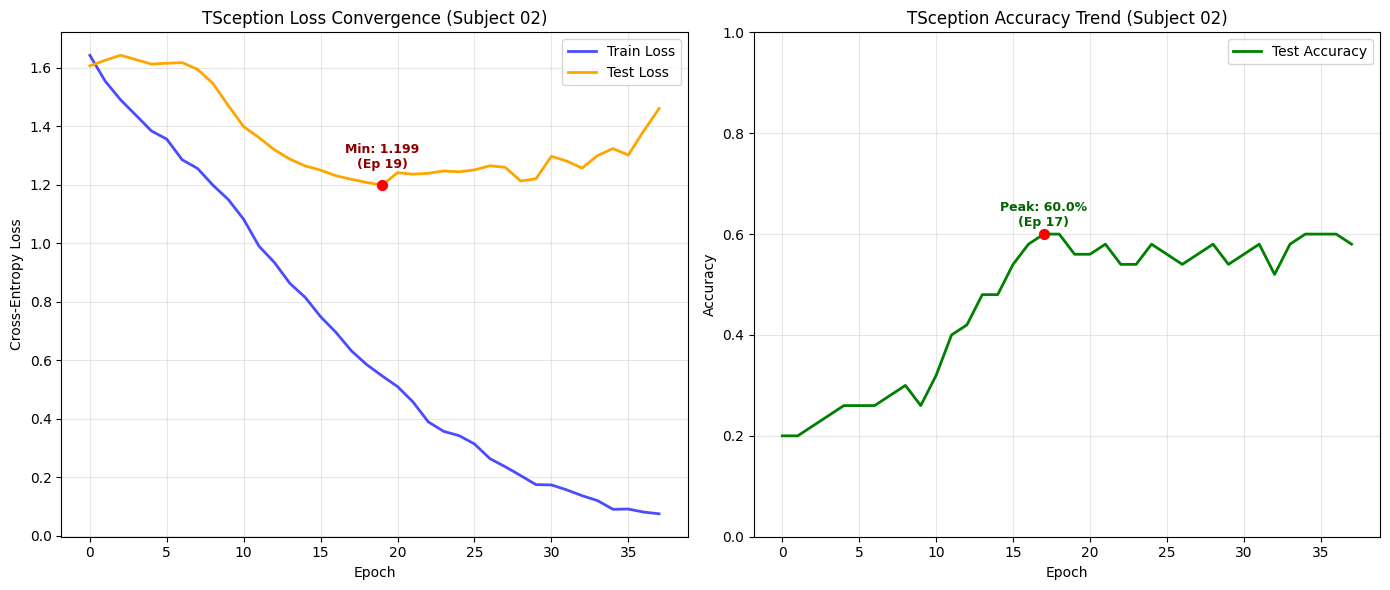

--- Generating Report for TSception baseline: TSception_train_1_test_02 ---


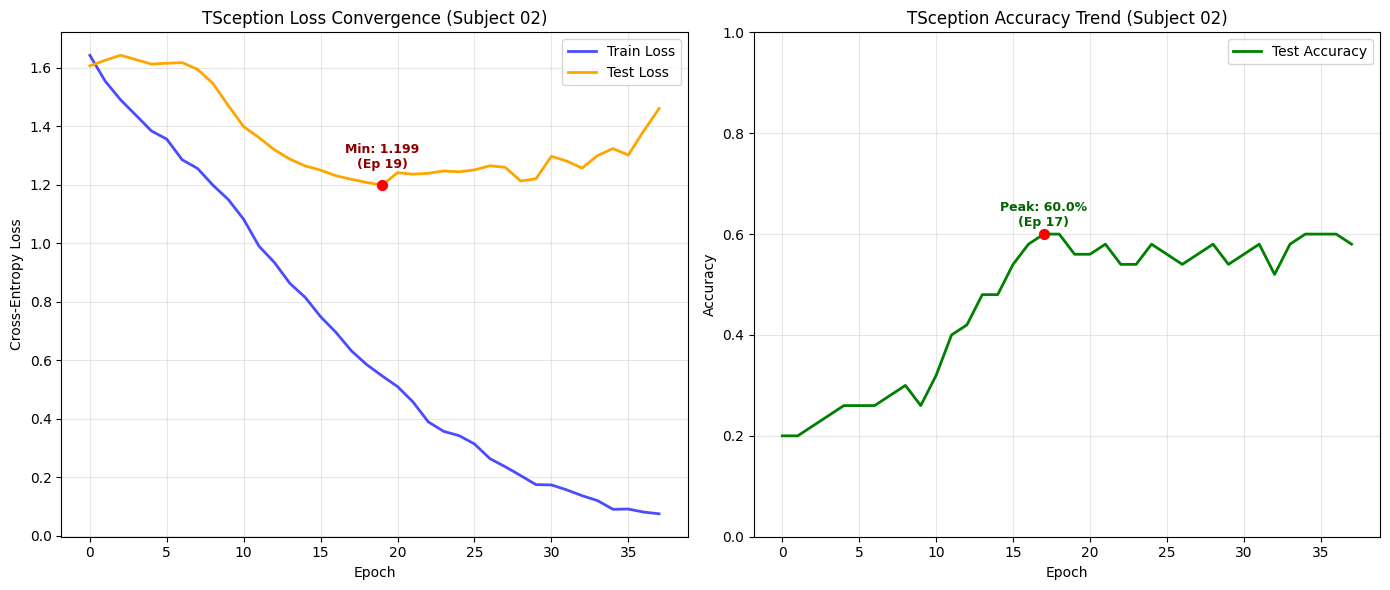


TSCEPTION TRAINING DYNAMICS SUMMARY
-----------------------------------
Peak Accuracy:  60.00% (Epoch 17)
Final Accuracy: 58.00% (Epoch 37)
Best Loss:      1.1991 (Epoch 19)

FINAL INFERENCE REPORT: TSCEPTION (SUBJECT 02)
---------------------------------------------
Inference Accuracy: 60.00%
Macro F1 Score:     0.5678
---------------------------------------------
              precision    recall  f1-score   support

       Hello       0.50      0.20      0.29        10
     Help Me       0.62      0.50      0.56        10
        Stop       0.56      0.90      0.69        10
   Thank You       0.64      0.90      0.75        10
         Yes       0.62      0.50      0.56        10

    accuracy                           0.60        50
   macro avg       0.59      0.60      0.57        50
weighted avg       0.59      0.60      0.57        50



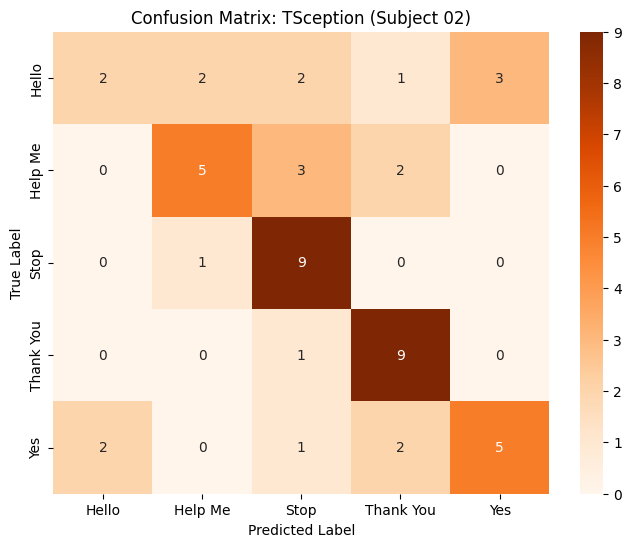

In [28]:
# ==============================================================================
# Loads telemetry data from the TSception comparison run to generate:
# 1. Learning Curves (Loss & Accuracy) with Peak/Min annotations.
# 2. Classification Report (Precision, Recall, F1-Score).
# 3. Confusion Matrix.
# ==============================================================================

TRAIN_INDICES = [1]
TEST_ID = '02'
RUN_NAME = f"TSception_train_{'-'.join(map(str, TRAIN_INDICES))}_test_{TEST_ID}"
LOG_DIR = f"logs/comparison_experiment/{RUN_NAME}"

print(f"--- Generating Report for TSception baseline: {RUN_NAME} ---")

metrics_path = f"{LOG_DIR}/metrics.csv"

if os.path.exists(metrics_path):
    # Load and aggregate metrics by epoch
    metrics_df = pd.read_csv(metrics_path)
    epoch_metrics = metrics_df.groupby('epoch').mean()

    # Identify Best Metrics (Min Loss / Max Accuracy)
    # --------------------------------------------------------------------------
    best_loss_val = None
    best_loss_ep = None
    best_acc_val = None
    best_acc_ep = None

    # Check for validation/test keys and find optima
    loss_key = next((k for k in ['val_loss', 'test_loss'] if k in epoch_metrics.columns), None)
    if loss_key:
        best_loss_val = epoch_metrics[loss_key].min()
        best_loss_ep = epoch_metrics[loss_key].idxmin()

    acc_key = next((k for k in ['val_acc', 'test_acc'] if k in epoch_metrics.columns), None)
    if acc_key:
        best_acc_val = epoch_metrics[acc_key].max()
        best_acc_ep = epoch_metrics[acc_key].idxmax()

    # Plotting
    # --------------------------------------------------------------------------
    plt.figure(figsize=(14, 6))

    # Subplot 1: Loss Trajectory
    plt.subplot(1, 2, 1)
    if 'train_loss' in epoch_metrics.columns:
        plt.plot(epoch_metrics.index, epoch_metrics['train_loss'], label='Train Loss', color='blue', linewidth=2, alpha=0.7)
    
    if loss_key:
        plt.plot(epoch_metrics.index, epoch_metrics[loss_key], label='Test Loss', color='orange', linewidth=2)
        plt.scatter(best_loss_ep, best_loss_val, color='red', s=50, zorder=5)
        plt.text(best_loss_ep, best_loss_val + 0.05, f"Min: {best_loss_val:.3f}\n(Ep {best_loss_ep})", 
                 ha='center', va='bottom', fontsize=9, fontweight='bold', color='darkred')

    plt.title(f'TSception Loss Convergence (Subject {TEST_ID})')
    plt.xlabel('Epoch')
    plt.ylabel('Cross-Entropy Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Subplot 2: Accuracy Trajectory
    plt.subplot(1, 2, 2)
    if acc_key:
        plt.plot(epoch_metrics.index, epoch_metrics[acc_key], label='Test Accuracy', color='green', linewidth=2)
        plt.scatter(best_acc_ep, best_acc_val, color='red', s=50, zorder=5)
        plt.text(best_acc_ep, best_acc_val + 0.01, f"Peak: {best_acc_val:.1%}\n(Ep {best_acc_ep})", 
                 ha='center', va='bottom', fontsize=9, fontweight='bold', color='darkgreen')

    plt.title(f'TSception Accuracy Trend (Subject {TEST_ID})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.0)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    print(f"\nTSCEPTION TRAINING DYNAMICS SUMMARY")
    print("-" * 35)
    if acc_key:
        print(f"Peak Accuracy:  {best_acc_val:.2%} (Epoch {best_acc_ep})")
        print(f"Final Accuracy: {epoch_metrics[acc_key].iloc[-1]:.2%} (Epoch {epoch_metrics.index[-1]})")
    if loss_key:
        print(f"Best Loss:      {best_loss_val:.4f} (Epoch {best_loss_ep})")

else:
    print(f"Metrics file not found: {metrics_path}")

# 3. Quantitative Evaluation (Final Inference)
# ------------------------------------------------------------------------------
results_path = f"{LOG_DIR}/final_test_results.csv"

if os.path.exists(results_path):
    data = np.loadtxt(results_path, delimiter=',')
    
    if data.ndim == 2 and data.shape[1] == 2:
        y_pred, y_true = data[:, 0], data[:, 1]
        classes = ['Hello', 'Help Me', 'Stop', 'Thank You', 'Yes']

        print(f"\nFINAL INFERENCE REPORT: TSCEPTION (SUBJECT {TEST_ID})")
        print("-" * 45)
        print(f"Inference Accuracy: {accuracy_score(y_true, y_pred):.2%}")
        print(f"Macro F1 Score:     {f1_score(y_true, y_pred, average='macro'):.4f}")
        print("-" * 45)
        print(classification_report(y_true, y_pred, target_names=classes))

        # Confusion Matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', 
                    xticklabels=classes, yticklabels=classes)
        plt.title(f'Confusion Matrix: TSception (Subject {TEST_ID})')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

# 17. FAST VS. TSCEPTION PERFORMANCE COMPARISON


Running Generalizability Inference for Subject 01 models...

FINAL ARCHITECTURE COMPARISON: FAST VS. TSCEPTION
Subject     Model Intra-Acc Intra-F1  Conv. Ep Gen S02 Gen S03 Gen S08
     01 TSception    72.00%   0.7180        53  24.00%  10.00%  16.00%
     02 TSception    60.00%   0.5678        17       -       -       -


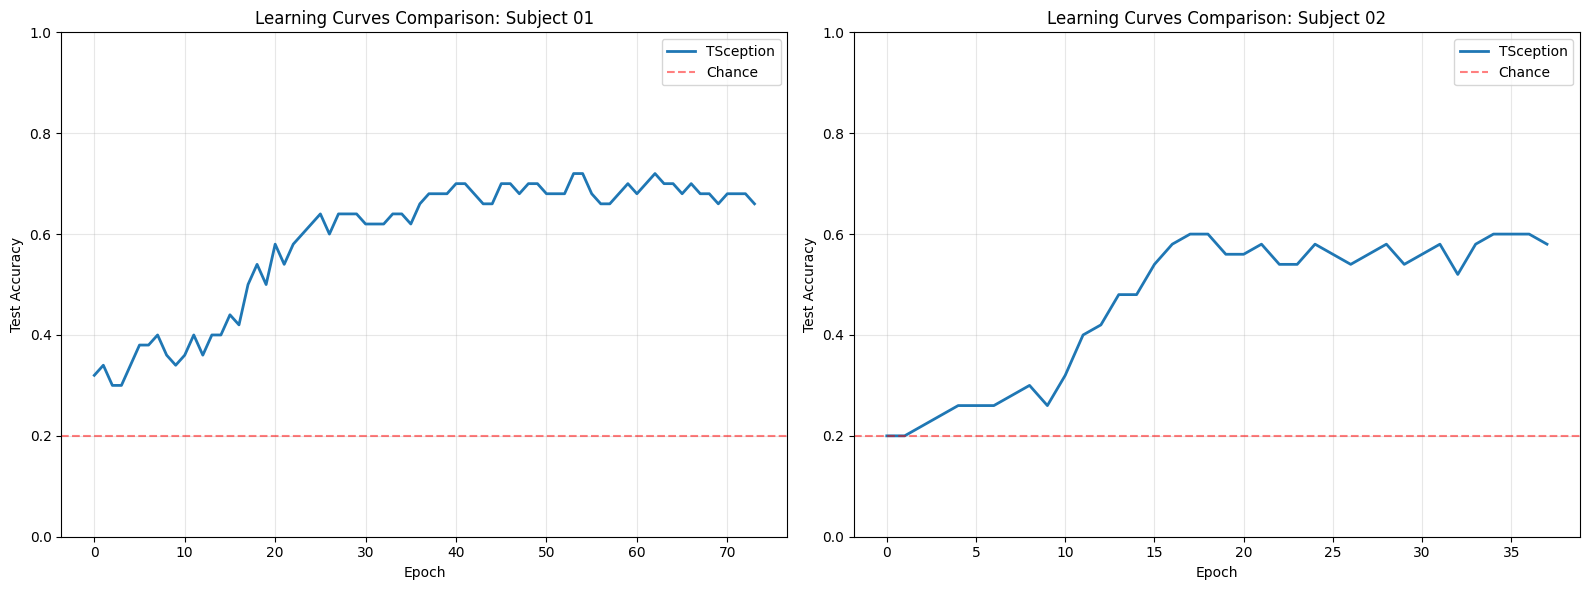


Block 17 Complete: Comparative report and visualizations generated.


: 

In [ ]:
# ==============================================================================
# BLOCK 17: CROSS-ARCHITECTURE COMPARATIVE ANALYSIS
# ==============================================================================
# Purpose: Performs a comprehensive comparison between FAST and TSception.
# Evaluates accuracy, F1-score, convergence speed, and cross-subject generalization.
# ==============================================================================

import pandas as pd
import os
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# 1. Configuration & Path Definitions
# ------------------------------------------------------------------------------
subjects_to_compare = ['01', '02']
gen_target_ids = ['02', '03', '08'] # Subjects for generalizability check
models = ['FAST', 'TSception']

# Paths to logs
log_roots = {
    'FAST': 'logs/final_experiment',
    'TSception': 'logs/comparison_experiment'
}

def get_best_metrics(model_type, sub_id):
    """Extracts peak accuracy, F1, and convergence epoch from CSV logs."""
    sub_idx = int(sub_id) - 1
    if model_type == 'FAST':
        path = f"{log_roots['FAST']}/train_{sub_idx}_test_{sub_id}/metrics.csv"
    else:
        path = f"{log_roots['TSception']}/TSception_train_{sub_idx}_test_{sub_id}/metrics.csv"
    
    if not os.path.exists(path):
        return None
    
    df = pd.read_csv(path)
    # Average metrics per epoch (Lightning logs multiple steps per epoch)
    epoch_df = df.groupby('epoch').mean()
    
    acc_key = next((k for k in ['val_acc', 'test_acc'] if k in epoch_df.columns), None)
    if not acc_key: return None
    
    best_acc = epoch_df[acc_key].max()
    best_ep = epoch_df[acc_key].idxmax()
    
    # Reload final test results to get proper F1 (more accurate than averaged log)
    if model_type == 'FAST':
        res_path = f"{log_roots['FAST']}/train_{sub_idx}_test_{sub_id}/final_test_results.csv"
    else:
        res_path = f"{log_roots['TSception']}/TSception_train_{sub_idx}_test_{sub_id}/final_test_results.csv"
        
    f1 = 0.0
    if os.path.exists(res_path):
        data = np.loadtxt(res_path, delimiter=',')
        f1 = f1_score(data[:, 1], data[:, 0], average='macro')
        
    return {"Acc": best_acc, "F1": f1, "Epoch": best_ep}

# 2. Generalizability Performance (S01 Model -> Others)
# ------------------------------------------------------------------------------
gen_results = {model: {} for model in models}

def run_gen_test(model_type, train_sub_id, test_sub_ids):
    """Loads Subject 01 model and tests on others to measure generalizability."""
    # Find checkpoint
    if model_type == 'FAST':
        ckpt_dir = f"{log_roots['FAST']}/train_0_test_01/checkpoints/"
    else:
        ckpt_dir = f"{log_roots['TSception']}/TSception_train_0_test_01/checkpoints/"
    
    if not os.path.exists(ckpt_dir): 
        print(f"Warning: Checkpoint directory not found for {model_type}")
        return
        
    ckpts = [f for f in os.listdir(ckpt_dir) if f.endswith('.ckpt')]
    if not ckpts: return
    full_path = os.path.join(ckpt_dir, ckpts[0])
    
    # Load Model (Fix: Passing required positional arguments for EEG_Encoder_Module)
    try:
        if model_type == 'FAST':
            m_module = EEG_Encoder_Module.load_from_checkpoint(
                full_path, 
                config=config, 
                max_epochs=MAX_EPOCHS, 
                niter_per_ep=1, # Dummy value for inference
                weights_only=False
            )
        else:
            m_module = TSception_Module.load_from_checkpoint(
                full_path, 
                weights_only=False
            )
    except Exception as e:
        print(f"Failed to load {model_type} checkpoint: {e}")
        return
    
    m_module.eval()
    m_module.to('cuda' if torch.cuda.is_available() else 'cpu')
    
    for tid in test_sub_ids:
        if tid in test_library:
            y_pred, y_true = inference_on_loader(m_module.model, test_library[tid])
            gen_results[model_type][tid] = accuracy_score(y_true, y_pred)

print("Running Generalizability Inference for Subject 01 models...")
run_gen_test('FAST', '01', gen_target_ids)
run_gen_test('TSception', '01', gen_target_ids)

# 3. Data Aggregation & Table Generation
# ------------------------------------------------------------------------------
comparison_data = []

for sub_id in subjects_to_compare:
    for model_name in models:
        m = get_best_metrics(model_name, sub_id)
        if m:
            row = {
                "Subject": sub_id,
                "Model": model_name,
                "Intra-Acc": f"{m['Acc']:.2%}",
                "Intra-F1": f"{m['F1']:.4f}",
                "Conv. Ep": int(m['Epoch']),
            }
            # Add generalizability (only relevant for models trained on Subject 01)
            if sub_id == '01':
                for tid in gen_target_ids:
                    acc = gen_results[model_name].get(tid, 0.0)
                    row[f"Gen S{tid}"] = f"{acc:.2%}" if acc > 0 else "N/A"
            else:
                for tid in gen_target_ids: row[f"Gen S{tid}"] = "-"
            
            comparison_data.append(row)

report_df = pd.DataFrame(comparison_data)

print("\n" + "="*95)
print("FINAL ARCHITECTURE COMPARISON: FAST VS. TSCEPTION")
print("="*95)
print(report_df.to_string(index=False))
print("="*95)

# 4. Comparative Visualizations
# ------------------------------------------------------------------------------
plt.figure(figsize=(16, 6))

for i, sub_id in enumerate(subjects_to_compare):
    plt.subplot(1, 2, i+1)
    for model_name in models:
        sub_idx = int(sub_id) - 1
        prefix = "TSception_" if model_name == "TSception" else ""
        root = log_roots[model_name]
        p = f"{root}/{prefix}train_{sub_idx}_test_{sub_id}/metrics.csv"
        
        if os.path.exists(p):
            df = pd.read_csv(p).groupby('epoch').mean()
            acc_key = next((k for k in ['val_acc', 'test_acc'] if k in df.columns), None)
            if acc_key:
                plt.plot(df.index, df[acc_key], label=f'{model_name}', linewidth=2)
            
    plt.title(f'Learning Curves Comparison: Subject {sub_id}')
    plt.axhline(y=0.20, color='red', linestyle='--', alpha=0.5, label='Chance')
    plt.ylabel('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylim(0, 1.0)
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nBlock 17 Complete: Comparative report and visualizations generated.")